<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 8th exercise: <font color="#C70039">Work with a regular Generative Adversarial Network (GAN)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Student: Nicolas Rehbach
* Matriculation Number: 11133387
* Date:   04.12.2022

<img src="https://www.researchgate.net/publication/338509383/figure/fig1/AS:845792709464064@1578664104008/Overview-of-generative-adversarial-network-GAN.ppm" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
The code implements a regular GAN that generates images using a random latent vector as input. While it works great we do not know the mapping of latent vector to the generated image.

Conditional GANs, however, can be used to supply a label during taining so the latent vector can be associated with a specific label - making the generation of images predictable. 

The below coded GAN is using the so-called cifar10 data set, which is standard to many machine learning applications (60,000 32x32 color images in 10 different classes: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).
Following the code trains and generates images based on that cifar10 data set, that is included in the Keras package. 
Further information on the data set can be found here: <a href="https://en.wikipedia.org/wiki/CIFAR-10"> cifar10 data set (wiki)</a>

The code is adapted from the code by Jason Brownlee from his blogs on <a href="https://machinelearningmastery.com/">https://machinelearningmastery.com/</a>.
I seriously urge everyone to follow his blogs and get inspired. Hence, original credit goes to Jason Brownlee. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. train the GAN with a higher dimension of the latent space and over more epochs. Are the results improving? 
5. What could be done to further improve the quality of the generated images? 
---------------------------------

### General understanding of Generative Adverserial Networks 

Based on https://www.youtube.com/watch?v=5WoItGTWV54&t=3078s and https://dl.acm.org/doi/pdf/10.1145/3422622

- designed to solve the generative modelling problem
	- study a collection of training examples and learn the probability distribution that generated them
- GANs are a unsupervised learning model
- Generative modeling:
	- training examples x are drawn from an unknown distribution $p_{data}(x)$ 
	- Goal of the generative model is to learn a $p_{model}(x)$ that approximates $p_{data}(x)$ as closely as possible
	- most popular approach to generative modeling is maximum likelihood estimation
		- minimizing th KL divergence between $p_{data}$ and $p_{model}$
- Some models learn only a tractable sample generation process -> implicit generative models
- Also GANs are implicit generative models

- GANs are based on a game between two machine learning models, typically implemented by NNs
- One network called the generator defined $p_{model}(x)$ implicitly
	- not necessarily able to evaluate the density function $p_{model}$
- The generator is defined by a prior distribution p(z) over a vector z that serves as input to the generator function $G(z; \theta^G)$ where $\theta^G$ is a set of learnable parameters defining the generator's strategy in the game
    - z can be thought of as a source of randomness in an otherwise deterministic system
	- The main role of our generator is to learn the function $G(z)$ that transforms such unstructured noise z into realistic samples
- The other player is the discriminator
	- examines sample x and returns some estimate $D(x; \theta^{D})$ of whether x is real or fake
	- Each player plays its own game: the discrminator is encouraged to correctly classify data as real or fake and the generator tries to generate samples, which the discriminator incorrectly classifies as real
- The generator learns via the discriminators gradient, as if the counterfeiters have a mole among the police reporting the specific methods that the police uses to detect the fakes 
- Each players cost is a function of the other players parameters but each player may control its own parameters 
- GANs can be seen as a way for machine learning to learn its own cost function

- Discriminator wants to maximize the objective function such as the discriminator output D(x) is close to 1 (real) and the discriminator output for generated fake data is close to 0 (fake)
- The generator wants to minimize the objective function such that discriminator output for generated fake data is close to 1 (discriminator is fooled into thinking generated G(z) is real)

**- If $G(z)$ is the output of the generator and $D(G(z))$ is the output of the discriminator then the error function for the generator is $-ln(D(G(z)))$ and the error function for the discriminator is $-ln(1-D(G(z)))$**

Minimax objective function:

Classic idea:

We alternate between: 1. Gradient ascent on the discriminator (maximize to 1) Gradient descent on the generator (minimize to 0)

Standard in practice: we use Gradient ascent on the generator (maximize the likelihood of discriminator being wrong). Works much better.

### GAN
#### Imports

In [1]:
#normal numpy imports
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

#plotting
import matplotlib.pyplot as plt

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # Adam our optimizer, worked out well in the Autoencoder for visual data
from tensorflow.keras.models import Sequential # Sequential, to define our model variable. each layer has exactly one input tensor and one output tensor.
from tensorflow.keras.layers import Dense # Dense, a fully connected layer
from tensorflow.keras.layers import Reshape # To reshape our pictures
from tensorflow.keras.layers import Flatten # To flatten the pictures -> flattens the dimensions of many into one
from tensorflow.keras.layers import Conv2D #2d Convolutional layer
from tensorflow.keras.layers import Conv2DTranspose # Transposing of the Convolutional layer
from tensorflow.keras.layers import LeakyReLU # Leaky ReLU to overcome "dead Relu". Instead of 0 a small negative number is returned
from tensorflow.keras.layers import Dropout # Deactivate neurons to counter overfitting
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets.cifar10 import load_data

# this import is needed because there is a problem with the Secure Socket Layer (SSL) certificate, 
# It can be resolved using the below line of code
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Build the GAN architeture

Use the "functional" way of defining the model for the conditional gan but use "sequential" for descriminator and generator as they are straight forward.

#### Define the standalone discriminator model

Given an input image, the Discriminator outputs the likelihood of the image being real.
Binary classification - true or false (1 or 0). So use the sigmoid activation.

In [2]:
#defning our discriminator, the input is of shape 32x32 and RGB
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential(name="discriminator")

    # we add Layers and a Leaky Relu of alpha 0.2 (our negative slope coefficient)
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))
    
    # we flatten the output to a one dimensional vector of 8192
    model.add(Flatten()) #shape of 8192
    # we drop 0.4 (so 40%?) of our input neurons 
    model.add(Dropout(0.4))
    # our final layer is a Dense layer with a sigmoid activation. Why shape of 1?
    model.add(Dense(1, activation='sigmoid')) #shape of 1
    
    # Compile model since it is going to be trained directly and choose the optimizer
    # Loss function is binary_crossentropy since we want 0 or 1 as output
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

test_discriminator = define_discriminator()
print(test_discriminator.summary())

2023-01-13 16:34:38.338750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-13 16:34:38.339311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)         

/Users/nicolasrehbach/miniforge3/envs/aml/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#### Define the standalone generator model
Given the latent vector input, the Generator produces an image.(here: 32x32)
The latent_dim, for example, can be 100, 1D array of size 100. 

Only Dense and conv2dlayers are being used. But the network can be more complicated based on the problem you are trying to solve. For example, you can use VGG as the basis for a super resolution GAN. 

In [3]:
# We start with a lower resolution (8x8) of noise and upsample the data. 

#latent_dim is the dimension of the latent vector (e.g., 100 - see below)
def define_generator(latent_dim):    
    
    model = Sequential(name="generator")

    # Reshape the input latent vector into an 8x8 image as a starting point. 
    # Hence n_nodes for the Dense layer are e.g. 128x8x8, so when reshaping the output 
    # it would be 8x8x128 and that can be slowly upscaled to a 32x32 image as the output.
    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with a 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  #8x8x128 data set from the latent vector. 
    # upsample to 16x16
    
    #Conv2DTranspose: combines the UpSampling2D and Conv2D layer
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model  # the generator model not compiled as it is not directly trained as the discriminator.
                  # the generator is being trained via a GAN combined model (see below)

test_generator = define_generator(latent_dim=100)
print(test_generator.summary())

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                               

Now, define the combined generator and discriminator model, for updating the generator.
The discriminator is trained separately so here only the generator will be trained by keeping the discriminator constant. 

In [4]:
def define_gan(generator, discriminator):
    # The discriminator is trained separately (see above). Hence, set it to not trainable.
    discriminator.trainable = False  
    
    # Now, connect the generator and the discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    # Compile the combined model and Choose an optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

### Load data
Load the data set and plot parts of it in order to get a quick understanding.

CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

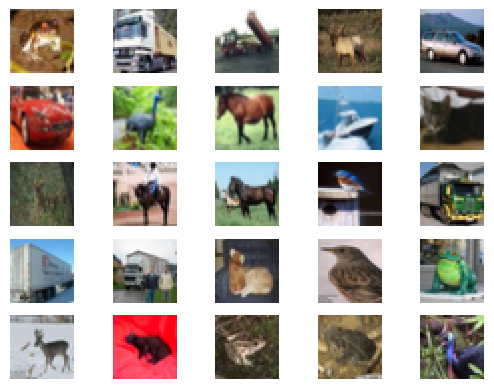

In [5]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25=5x5 example images
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

In [6]:
# Load the cifar images and build a training data set
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    # convert to float and scale.
    X = trainX.astype('float32')
    # the generator uses tanh as activation function (see above), 
    # so we need to rescale from [0,255] to [-1,1]
    # original images to -1 to 1 to match the output of generator.
    X = (X - 127.5) / 127.5  
    
    return X

In [7]:
# Pick a batch of random real samples to train the GAN
# In fact, train the GAN on a half batch of real images and another half batch of fake images. 
# For each real image assign the label=1 and for fake assign the label=0. 
def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    x = dataset[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) # label=1 indicates that the image is a real one
    return x, y

In [8]:
# Generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
# Use the generator to generate n fake examples, with class labels
# Supply the generator, latent_dim and number of samples as input.
# Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    x = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  # label=0 indicates that the image is a fake one
    return x, y

### Training function for the generator and discriminator
Loop through a number of epochs to train the discriminator by first selecting a random batch of images from the true/real data set. Then, generate a set of images using the generator. Feed both sets of images into the discriminator. Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

In [10]:
# for the training we need: generative model, discriminative model, filename(saving), data, the latent dimension
# the amount of epochs (standard 100 later on we update it), batch size is 128
def train(g_model, d_model, gan_model, filename, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch) # we use the dataset size / 128 as batchs per epoch
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
    # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
            # Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            # train_on_batch allows you to update weights based on a collection 
            # of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples as valid ones.
            # This is where the generator is trying to trick discriminator into believing that 
            # the generated image is true (hence value of 1 for y)
            y_gan = ones((n_batch, 1))
            
            # The generator is part of the combined model where it got directly linked with the discriminator
            # Train the generator with latent_dim as x and 1 as y. 
            # Again, 1 as the output as it is adversarial and if the generator did a great
            # job of fooling the discriminator, then the output would be 1 (true).
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                 (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    # save the generator model
    g_model.save(filename)

### Train the GAN

In [26]:
# size of the latent space
latent_dim = 500
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
n_epochs=100 #5
model_filename = "cifar_GAN." + str(latent_dim) + str(n_epochs) + "_epochs.model"
train(generator, discriminator, gan_model, model_filename, dataset, latent_dim, n_epochs)


1/2 [==============>...............] - ETA: 0s

2023-01-02 09:59:32.338943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-02 09:59:32.503323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 61ms/step


2023-01-02 09:59:32.885598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch>1, Batch 1/390, d1=0.676, d2=0.697 g=0.690
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 2/390, d1=0.618, d2=0.708 g=0.679
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 3/390, d1=0.568, d2=0.727 g=0.661
2/2 [==============================] - 0s 40ms/step
Epoch>1, Batch 4/390, d1=0.513, d2=0.754 g=0.640
2/2 [==============================] - 0s 40ms/step
Epoch>1, Batch 5/390, d1=0.455, d2=0.791 g=0.618
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 6/390, d1=0.405, d2=0.835 g=0.598
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 7/390, d1=0.389, d2=0.860 g=0.597
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 8/390, d1=0.345, d2=0.846 g=0.638
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 9/390, d1=0.367, d2=0.781 g=0.712
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 10/390, d1=0.322, d2=0.674 g=0.839
2/2 [==============================] - 0s

2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 82/390, d1=0.419, d2=0.235 g=1.834
2/2 [==============================] - 0s 40ms/step
Epoch>1, Batch 83/390, d1=0.467, d2=0.247 g=1.779
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 84/390, d1=0.425, d2=0.278 g=1.599
2/2 [==============================] - 0s 40ms/step
Epoch>1, Batch 85/390, d1=0.270, d2=0.365 g=1.349
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 86/390, d1=0.371, d2=0.474 g=1.036
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 87/390, d1=0.247, d2=0.585 g=0.849
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 88/390, d1=0.257, d2=0.661 g=0.764
2/2 [==============================] - 0s 39ms/step
Epoch>1, Batch 89/390, d1=0.183, d2=0.729 g=0.717
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 90/390, d1=0.222, d2=0.816 g=0.661
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 91/390, d1=0.20

2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 162/390, d1=0.264, d2=0.365 g=1.322
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 163/390, d1=0.193, d2=0.380 g=1.312
2/2 [==============================] - 0s 46ms/step
Epoch>1, Batch 164/390, d1=0.183, d2=0.395 g=1.275
2/2 [==============================] - 0s 44ms/step
Epoch>1, Batch 165/390, d1=0.191, d2=0.430 g=1.174
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 166/390, d1=0.247, d2=0.578 g=1.072
2/2 [==============================] - 0s 46ms/step
Epoch>1, Batch 167/390, d1=0.169, d2=0.857 g=1.012
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 168/390, d1=0.202, d2=0.902 g=1.141
2/2 [==============================] - 0s 46ms/step
Epoch>1, Batch 169/390, d1=0.272, d2=0.800 g=1.657
2/2 [==============================] - 0s 43ms/step
Epoch>1, Batch 170/390, d1=0.514, d2=0.397 g=2.159
2/2 [==============================] - 0s 44ms/step
Epoch>1, Batch 171/39

2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 242/390, d1=0.588, d2=0.605 g=1.793
2/2 [==============================] - 0s 40ms/step
Epoch>1, Batch 243/390, d1=0.520, d2=0.310 g=1.873
2/2 [==============================] - 0s 43ms/step
Epoch>1, Batch 244/390, d1=0.527, d2=0.317 g=1.962
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 245/390, d1=0.697, d2=0.328 g=1.959
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 246/390, d1=0.808, d2=0.299 g=1.973
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 247/390, d1=0.647, d2=0.382 g=2.086
2/2 [==============================] - 0s 43ms/step
Epoch>1, Batch 248/390, d1=0.790, d2=0.224 g=1.870
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 249/390, d1=0.838, d2=0.297 g=1.809
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 250/390, d1=0.682, d2=0.246 g=1.813
2/2 [==============================] - 0s 40ms/step
Epoch>1, Batch 251/39

2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 322/390, d1=0.510, d2=0.624 g=0.919
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 323/390, d1=0.529, d2=0.631 g=0.948
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 324/390, d1=0.522, d2=0.613 g=0.918
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 325/390, d1=0.560, d2=0.641 g=0.902
2/2 [==============================] - 0s 43ms/step
Epoch>1, Batch 326/390, d1=0.531, d2=0.613 g=0.935
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 327/390, d1=0.534, d2=0.556 g=0.860
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 328/390, d1=0.497, d2=0.637 g=0.895
2/2 [==============================] - 0s 42ms/step
Epoch>1, Batch 329/390, d1=0.629, d2=0.681 g=0.824
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 330/390, d1=0.556, d2=0.696 g=0.822
2/2 [==============================] - 0s 41ms/step
Epoch>1, Batch 331/39

2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 12/390, d1=0.797, d2=0.505 g=1.273
2/2 [==============================] - 0s 42ms/step
Epoch>2, Batch 13/390, d1=0.763, d2=0.410 g=1.316
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 14/390, d1=0.768, d2=0.410 g=1.398
2/2 [==============================] - 0s 42ms/step
Epoch>2, Batch 15/390, d1=0.775, d2=0.394 g=1.388
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 16/390, d1=0.735, d2=0.453 g=1.400
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 17/390, d1=0.785, d2=0.412 g=1.331
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 18/390, d1=0.746, d2=0.534 g=1.184
2/2 [==============================] - 0s 42ms/step
Epoch>2, Batch 19/390, d1=0.761, d2=0.531 g=1.071
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 20/390, d1=0.764, d2=0.619 g=0.944
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 21/390, d1=0.68

2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 172/390, d1=0.824, d2=0.423 g=1.242
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 173/390, d1=0.848, d2=0.444 g=1.160
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 174/390, d1=0.773, d2=0.503 g=1.099
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 175/390, d1=0.770, d2=0.541 g=0.981
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 176/390, d1=0.750, d2=0.629 g=0.874
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 177/390, d1=0.755, d2=0.645 g=0.794
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 178/390, d1=0.744, d2=0.696 g=0.777
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 179/390, d1=0.746, d2=0.671 g=0.766
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 180/390, d1=0.718, d2=0.651 g=0.764
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 181/39

2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 252/390, d1=0.740, d2=0.617 g=0.860
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 253/390, d1=0.735, d2=0.583 g=0.890
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 254/390, d1=0.737, d2=0.575 g=0.897
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 255/390, d1=0.707, d2=0.599 g=0.884
2/2 [==============================] - 0s 45ms/step
Epoch>2, Batch 256/390, d1=0.712, d2=0.589 g=0.850
2/2 [==============================] - 0s 42ms/step
Epoch>2, Batch 257/390, d1=0.704, d2=0.634 g=0.812
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 258/390, d1=0.712, d2=0.651 g=0.780
2/2 [==============================] - 0s 48ms/step
Epoch>2, Batch 259/390, d1=0.643, d2=0.665 g=0.760
2/2 [==============================] - 0s 44ms/step
Epoch>2, Batch 260/390, d1=0.654, d2=0.678 g=0.757
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 261/39

2/2 [==============================] - 0s 42ms/step
Epoch>2, Batch 332/390, d1=0.736, d2=0.642 g=0.821
2/2 [==============================] - 0s 42ms/step
Epoch>2, Batch 333/390, d1=0.707, d2=0.666 g=0.792
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 334/390, d1=0.739, d2=0.636 g=0.796
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 335/390, d1=0.742, d2=0.680 g=0.778
2/2 [==============================] - 0s 40ms/step
Epoch>2, Batch 336/390, d1=0.724, d2=0.669 g=0.766
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 337/390, d1=0.715, d2=0.655 g=0.768
2/2 [==============================] - 0s 42ms/step
Epoch>2, Batch 338/390, d1=0.707, d2=0.685 g=0.750
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 339/390, d1=0.690, d2=0.666 g=0.758
2/2 [==============================] - 0s 43ms/step
Epoch>2, Batch 340/390, d1=0.699, d2=0.701 g=0.751
2/2 [==============================] - 0s 41ms/step
Epoch>2, Batch 341/39

2/2 [==============================] - 0s 41ms/step
Epoch>3, Batch 22/390, d1=0.692, d2=0.524 g=1.053
2/2 [==============================] - 0s 41ms/step
Epoch>3, Batch 23/390, d1=0.665, d2=0.492 g=0.996
2/2 [==============================] - 0s 40ms/step
Epoch>3, Batch 24/390, d1=0.735, d2=0.494 g=1.017
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 25/390, d1=0.697, d2=0.511 g=0.979
2/2 [==============================] - 0s 41ms/step
Epoch>3, Batch 26/390, d1=0.676, d2=0.545 g=0.932
2/2 [==============================] - 0s 40ms/step
Epoch>3, Batch 27/390, d1=0.654, d2=0.559 g=0.874
2/2 [==============================] - 0s 42ms/step
Epoch>3, Batch 28/390, d1=0.739, d2=0.657 g=0.821
2/2 [==============================] - 0s 40ms/step
Epoch>3, Batch 29/390, d1=0.711, d2=0.718 g=0.750
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 30/390, d1=0.710, d2=0.744 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 31/390, d1=0.68

2/2 [==============================] - 0s 41ms/step
Epoch>3, Batch 182/390, d1=0.646, d2=0.566 g=0.898
2/2 [==============================] - 0s 41ms/step
Epoch>3, Batch 183/390, d1=0.652, d2=0.640 g=0.902
2/2 [==============================] - 0s 42ms/step
Epoch>3, Batch 184/390, d1=0.664, d2=0.627 g=0.890
2/2 [==============================] - 0s 40ms/step
Epoch>3, Batch 185/390, d1=0.670, d2=0.629 g=0.876
2/2 [==============================] - 0s 40ms/step
Epoch>3, Batch 186/390, d1=0.639, d2=0.591 g=0.871
2/2 [==============================] - 0s 41ms/step
Epoch>3, Batch 187/390, d1=0.726, d2=0.626 g=0.909
2/2 [==============================] - 0s 41ms/step
Epoch>3, Batch 188/390, d1=0.677, d2=0.617 g=0.886
2/2 [==============================] - 0s 40ms/step
Epoch>3, Batch 189/390, d1=0.673, d2=0.594 g=0.869
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 190/390, d1=0.684, d2=0.616 g=0.902
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 191/39

2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 262/390, d1=0.684, d2=0.625 g=0.850
2/2 [==============================] - 0s 44ms/step
Epoch>3, Batch 263/390, d1=0.681, d2=0.628 g=0.855
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 264/390, d1=0.697, d2=0.619 g=0.831
2/2 [==============================] - 0s 45ms/step
Epoch>3, Batch 265/390, d1=0.664, d2=0.676 g=0.825
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 266/390, d1=0.692, d2=0.666 g=0.788
2/2 [==============================] - 0s 42ms/step
Epoch>3, Batch 267/390, d1=0.658, d2=0.695 g=0.767
2/2 [==============================] - 0s 42ms/step
Epoch>3, Batch 268/390, d1=0.679, d2=0.744 g=0.767
2/2 [==============================] - 0s 42ms/step
Epoch>3, Batch 269/390, d1=0.685, d2=0.728 g=0.794
2/2 [==============================] - 0s 44ms/step
Epoch>3, Batch 270/390, d1=0.685, d2=0.681 g=0.803
2/2 [==============================] - 0s 42ms/step
Epoch>3, Batch 271/39

2/2 [==============================] - 0s 42ms/step
Epoch>3, Batch 342/390, d1=0.615, d2=0.770 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>3, Batch 343/390, d1=0.569, d2=0.879 g=0.617
2/2 [==============================] - 0s 44ms/step
Epoch>3, Batch 344/390, d1=0.611, d2=0.894 g=0.638
2/2 [==============================] - 0s 45ms/step
Epoch>3, Batch 345/390, d1=0.513, d2=0.960 g=0.588
2/2 [==============================] - 0s 45ms/step
Epoch>3, Batch 346/390, d1=0.606, d2=0.860 g=0.621
2/2 [==============================] - 0s 45ms/step
Epoch>3, Batch 347/390, d1=0.633, d2=0.898 g=0.627
2/2 [==============================] - 0s 45ms/step
Epoch>3, Batch 348/390, d1=0.644, d2=0.810 g=0.720
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 349/390, d1=0.613, d2=0.713 g=0.766
2/2 [==============================] - 0s 43ms/step
Epoch>3, Batch 350/390, d1=0.631, d2=0.647 g=0.850
2/2 [==============================] - 0s 46ms/step
Epoch>3, Batch 351/39

2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 32/390, d1=0.699, d2=0.750 g=0.685
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 33/390, d1=0.706, d2=0.760 g=0.704
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 34/390, d1=0.667, d2=0.759 g=0.715
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 35/390, d1=0.680, d2=0.763 g=0.713
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 36/390, d1=0.705, d2=0.747 g=0.730
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 37/390, d1=0.684, d2=0.699 g=0.764
2/2 [==============================] - 0s 43ms/step
Epoch>4, Batch 38/390, d1=0.693, d2=0.651 g=0.803
2/2 [==============================] - 0s 43ms/step
Epoch>4, Batch 39/390, d1=0.694, d2=0.629 g=0.847
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 40/390, d1=0.719, d2=0.608 g=0.850
2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 41/390, d1=0.73

2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 192/390, d1=0.669, d2=0.626 g=0.836
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 193/390, d1=0.681, d2=0.623 g=0.851
2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 194/390, d1=0.651, d2=0.611 g=0.853
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 195/390, d1=0.680, d2=0.615 g=0.869
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 196/390, d1=0.650, d2=0.602 g=0.867
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 197/390, d1=0.646, d2=0.580 g=0.889
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 198/390, d1=0.632, d2=0.598 g=0.900
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 199/390, d1=0.577, d2=0.595 g=0.923
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 200/390, d1=0.592, d2=0.628 g=0.862
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 201/39

2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 272/390, d1=0.656, d2=0.647 g=0.864
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 273/390, d1=0.633, d2=0.648 g=0.867
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 274/390, d1=0.701, d2=0.621 g=0.877
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 275/390, d1=0.649, d2=0.685 g=0.906
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 276/390, d1=0.678, d2=0.668 g=0.934
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 277/390, d1=0.709, d2=0.600 g=0.987
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 278/390, d1=0.727, d2=0.573 g=0.990
2/2 [==============================] - 0s 41ms/step
Epoch>4, Batch 279/390, d1=0.725, d2=0.604 g=0.968
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 280/390, d1=0.746, d2=0.612 g=0.990
2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 281/39

2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 352/390, d1=0.714, d2=0.612 g=0.887
2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 353/390, d1=0.746, d2=0.681 g=0.835
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 354/390, d1=0.664, d2=0.731 g=0.774
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 355/390, d1=0.687, d2=0.714 g=0.790
2/2 [==============================] - 0s 43ms/step
Epoch>4, Batch 356/390, d1=0.642, d2=0.717 g=0.818
2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 357/390, d1=0.652, d2=0.608 g=0.925
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 358/390, d1=0.644, d2=0.527 g=1.083
2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 359/390, d1=0.734, d2=0.469 g=1.108
2/2 [==============================] - 0s 40ms/step
Epoch>4, Batch 360/390, d1=0.657, d2=0.453 g=1.151
2/2 [==============================] - 0s 42ms/step
Epoch>4, Batch 361/39

2/2 [==============================] - 0s 40ms/step
Epoch>5, Batch 122/390, d1=0.670, d2=0.603 g=0.882
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 123/390, d1=0.671, d2=0.611 g=0.882
2/2 [==============================] - 0s 40ms/step
Epoch>5, Batch 124/390, d1=0.624, d2=0.609 g=0.890
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 125/390, d1=0.626, d2=0.595 g=0.906
2/2 [==============================] - 0s 40ms/step
Epoch>5, Batch 126/390, d1=0.594, d2=0.575 g=0.905
2/2 [==============================] - 0s 40ms/step
Epoch>5, Batch 127/390, d1=0.596, d2=0.576 g=0.901
2/2 [==============================] - 0s 42ms/step
Epoch>5, Batch 128/390, d1=0.628, d2=0.643 g=0.888
2/2 [==============================] - 0s 42ms/step
Epoch>5, Batch 129/390, d1=0.657, d2=0.639 g=0.849
2/2 [==============================] - 0s 42ms/step
Epoch>5, Batch 130/390, d1=0.597, d2=0.701 g=0.796
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 131/39

2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 202/390, d1=0.707, d2=0.572 g=1.030
2/2 [==============================] - 0s 40ms/step
Epoch>5, Batch 203/390, d1=0.706, d2=0.573 g=1.076
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 204/390, d1=0.742, d2=0.542 g=1.012
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 205/390, d1=0.713, d2=0.646 g=0.862
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 206/390, d1=0.628, d2=0.763 g=0.778
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 207/390, d1=0.727, d2=0.812 g=0.672
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 208/390, d1=0.710, d2=0.849 g=0.732
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 209/390, d1=0.705, d2=0.725 g=0.792
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 210/390, d1=0.770, d2=0.710 g=0.895
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 211/39

2/2 [==============================] - 0s 44ms/step
Epoch>5, Batch 282/390, d1=0.698, d2=0.629 g=0.848
2/2 [==============================] - 0s 42ms/step
Epoch>5, Batch 283/390, d1=0.692, d2=0.594 g=0.874
2/2 [==============================] - 0s 44ms/step
Epoch>5, Batch 284/390, d1=0.699, d2=0.588 g=0.910
2/2 [==============================] - 0s 45ms/step
Epoch>5, Batch 285/390, d1=0.689, d2=0.599 g=0.925
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 286/390, d1=0.736, d2=0.603 g=0.890
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 287/390, d1=0.654, d2=0.633 g=0.876
2/2 [==============================] - 0s 44ms/step
Epoch>5, Batch 288/390, d1=0.745, d2=0.629 g=0.808
2/2 [==============================] - 0s 42ms/step
Epoch>5, Batch 289/390, d1=0.793, d2=0.713 g=0.725
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 290/390, d1=0.724, d2=0.817 g=0.644
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 291/39

2/2 [==============================] - 0s 45ms/step
Epoch>5, Batch 362/390, d1=0.713, d2=0.743 g=0.707
2/2 [==============================] - 0s 44ms/step
Epoch>5, Batch 363/390, d1=0.718, d2=0.747 g=0.726
2/2 [==============================] - 0s 42ms/step
Epoch>5, Batch 364/390, d1=0.729, d2=0.709 g=0.750
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 365/390, d1=0.702, d2=0.660 g=0.810
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 366/390, d1=0.721, d2=0.623 g=0.837
2/2 [==============================] - 0s 42ms/step
Epoch>5, Batch 367/390, d1=0.740, d2=0.655 g=0.828
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 368/390, d1=0.753, d2=0.677 g=0.792
2/2 [==============================] - 0s 43ms/step
Epoch>5, Batch 369/390, d1=0.687, d2=0.725 g=0.764
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 370/390, d1=0.722, d2=0.711 g=0.774
2/2 [==============================] - 0s 41ms/step
Epoch>5, Batch 371/39

2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 132/390, d1=0.674, d2=0.620 g=0.854
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 133/390, d1=0.668, d2=0.632 g=0.806
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 134/390, d1=0.652, d2=0.659 g=0.768
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 135/390, d1=0.703, d2=0.694 g=0.717
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 136/390, d1=0.702, d2=0.764 g=0.663
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 137/390, d1=0.662, d2=0.785 g=0.667
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 138/390, d1=0.657, d2=0.785 g=0.648
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 139/390, d1=0.670, d2=0.773 g=0.680
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 140/390, d1=0.713, d2=0.759 g=0.696
2/2 [==============================] - 0s 42ms/step
Epoch>6, Batch 141/39

2/2 [==============================] - 0s 44ms/step
Epoch>6, Batch 212/390, d1=0.636, d2=0.786 g=0.686
2/2 [==============================] - 0s 44ms/step
Epoch>6, Batch 213/390, d1=0.662, d2=0.751 g=0.728
2/2 [==============================] - 0s 42ms/step
Epoch>6, Batch 214/390, d1=0.666, d2=0.675 g=0.810
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 215/390, d1=0.670, d2=0.612 g=0.886
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 216/390, d1=0.713, d2=0.577 g=0.890
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 217/390, d1=0.655, d2=0.602 g=0.876
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 218/390, d1=0.722, d2=0.635 g=0.841
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 219/390, d1=0.683, d2=0.701 g=0.768
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 220/390, d1=0.678, d2=0.736 g=0.688
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 221/39

2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 292/390, d1=0.682, d2=0.615 g=0.842
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 293/390, d1=0.677, d2=0.654 g=0.788
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 294/390, d1=0.675, d2=0.717 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 295/390, d1=0.705, d2=0.754 g=0.674
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 296/390, d1=0.639, d2=0.807 g=0.635
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 297/390, d1=0.679, d2=0.801 g=0.638
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 298/390, d1=0.632, d2=0.792 g=0.659
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 299/390, d1=0.639, d2=0.786 g=0.690
2/2 [==============================] - 0s 41ms/step
Epoch>6, Batch 300/390, d1=0.623, d2=0.718 g=0.764
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 301/39

2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 372/390, d1=0.645, d2=0.819 g=0.651
2/2 [==============================] - 0s 42ms/step
Epoch>6, Batch 373/390, d1=0.661, d2=0.801 g=0.646
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 374/390, d1=0.659, d2=0.762 g=0.683
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 375/390, d1=0.655, d2=0.743 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>6, Batch 376/390, d1=0.667, d2=0.722 g=0.724
2/2 [==============================] - 0s 43ms/step
Epoch>6, Batch 377/390, d1=0.646, d2=0.683 g=0.766
2/2 [==============================] - 0s 47ms/step
Epoch>6, Batch 378/390, d1=0.636, d2=0.650 g=0.792
2/2 [==============================] - 0s 47ms/step
Epoch>6, Batch 379/390, d1=0.673, d2=0.626 g=0.834
2/2 [==============================] - 0s 44ms/step
Epoch>6, Batch 380/390, d1=0.658, d2=0.605 g=0.829
2/2 [==============================] - 0s 46ms/step
Epoch>6, Batch 381/39

2/2 [==============================] - 0s 46ms/step
Epoch>7, Batch 142/390, d1=0.634, d2=0.681 g=0.762
2/2 [==============================] - 0s 46ms/step
Epoch>7, Batch 143/390, d1=0.700, d2=0.655 g=0.765
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 144/390, d1=0.662, d2=0.675 g=0.774
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 145/390, d1=0.691, d2=0.645 g=0.758
2/2 [==============================] - 0s 46ms/step
Epoch>7, Batch 146/390, d1=0.726, d2=0.669 g=0.754
2/2 [==============================] - 0s 46ms/step
Epoch>7, Batch 147/390, d1=0.685, d2=0.673 g=0.742
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 148/390, d1=0.684, d2=0.706 g=0.729
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 149/390, d1=0.669, d2=0.744 g=0.686
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 150/390, d1=0.661, d2=0.831 g=0.679
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 151/39

2/2 [==============================] - 0s 41ms/step
Epoch>7, Batch 222/390, d1=0.751, d2=0.511 g=1.025
2/2 [==============================] - 0s 42ms/step
Epoch>7, Batch 223/390, d1=0.661, d2=0.535 g=0.978
2/2 [==============================] - 0s 41ms/step
Epoch>7, Batch 224/390, d1=0.697, d2=0.543 g=0.955
2/2 [==============================] - 0s 41ms/step
Epoch>7, Batch 225/390, d1=0.682, d2=0.546 g=0.920
2/2 [==============================] - 0s 41ms/step
Epoch>7, Batch 226/390, d1=0.693, d2=0.586 g=0.865
2/2 [==============================] - 0s 41ms/step
Epoch>7, Batch 227/390, d1=0.656, d2=0.605 g=0.840
2/2 [==============================] - 0s 42ms/step
Epoch>7, Batch 228/390, d1=0.605, d2=0.641 g=0.826
2/2 [==============================] - 0s 40ms/step
Epoch>7, Batch 229/390, d1=0.645, d2=0.677 g=0.794
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 230/390, d1=0.738, d2=0.725 g=0.737
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 231/39

2/2 [==============================] - 0s 46ms/step
Epoch>7, Batch 302/390, d1=0.807, d2=0.521 g=1.197
2/2 [==============================] - 0s 46ms/step
Epoch>7, Batch 303/390, d1=0.802, d2=0.460 g=1.247
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 304/390, d1=0.829, d2=0.461 g=1.184
2/2 [==============================] - 0s 43ms/step
Epoch>7, Batch 305/390, d1=0.808, d2=0.498 g=1.069
2/2 [==============================] - 0s 44ms/step
Epoch>7, Batch 306/390, d1=0.763, d2=0.562 g=0.974
2/2 [==============================] - 0s 43ms/step
Epoch>7, Batch 307/390, d1=0.765, d2=0.587 g=0.914
2/2 [==============================] - 0s 45ms/step
Epoch>7, Batch 308/390, d1=0.766, d2=0.594 g=0.934
2/2 [==============================] - 0s 43ms/step
Epoch>7, Batch 309/390, d1=0.753, d2=0.576 g=0.956
2/2 [==============================] - 0s 43ms/step
Epoch>7, Batch 310/390, d1=0.745, d2=0.554 g=0.943
2/2 [==============================] - 0s 42ms/step
Epoch>7, Batch 311/39

2/2 [==============================] - 0s 42ms/step
Epoch>7, Batch 382/390, d1=0.710, d2=0.616 g=0.841
2/2 [==============================] - 0s 42ms/step
Epoch>7, Batch 383/390, d1=0.748, d2=0.632 g=0.838
2/2 [==============================] - 0s 40ms/step
Epoch>7, Batch 384/390, d1=0.668, d2=0.610 g=0.870
2/2 [==============================] - 0s 42ms/step
Epoch>7, Batch 385/390, d1=0.751, d2=0.603 g=0.881
2/2 [==============================] - 0s 40ms/step
Epoch>7, Batch 386/390, d1=0.739, d2=0.578 g=0.884
2/2 [==============================] - 0s 42ms/step
Epoch>7, Batch 387/390, d1=0.727, d2=0.597 g=0.866
2/2 [==============================] - 0s 41ms/step
Epoch>7, Batch 388/390, d1=0.717, d2=0.566 g=0.874
2/2 [==============================] - 0s 41ms/step
Epoch>7, Batch 389/390, d1=0.675, d2=0.575 g=0.872
2/2 [==============================] - 0s 40ms/step
Epoch>7, Batch 390/390, d1=0.746, d2=0.565 g=0.871
2/2 [==============================] - 0s 43ms/step
Epoch>8, Batch 1/390,

2/2 [==============================] - 0s 42ms/step
Epoch>8, Batch 152/390, d1=0.660, d2=0.721 g=0.690
2/2 [==============================] - 0s 45ms/step
Epoch>8, Batch 153/390, d1=0.663, d2=0.757 g=0.691
2/2 [==============================] - 0s 49ms/step
Epoch>8, Batch 154/390, d1=0.702, d2=0.746 g=0.682
2/2 [==============================] - 0s 41ms/step
Epoch>8, Batch 155/390, d1=0.637, d2=0.750 g=0.666
2/2 [==============================] - 0s 40ms/step
Epoch>8, Batch 156/390, d1=0.691, d2=0.774 g=0.654
2/2 [==============================] - 0s 43ms/step
Epoch>8, Batch 157/390, d1=0.669, d2=0.761 g=0.656
2/2 [==============================] - 0s 41ms/step
Epoch>8, Batch 158/390, d1=0.639, d2=0.781 g=0.682
2/2 [==============================] - 0s 42ms/step
Epoch>8, Batch 159/390, d1=0.640, d2=0.787 g=0.674
2/2 [==============================] - 0s 42ms/step
Epoch>8, Batch 160/390, d1=0.650, d2=0.712 g=0.718
2/2 [==============================] - 0s 44ms/step
Epoch>8, Batch 161/39

2/2 [==============================] - 0s 47ms/step
Epoch>8, Batch 232/390, d1=0.579, d2=0.606 g=0.844
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 233/390, d1=0.557, d2=0.662 g=0.825
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 234/390, d1=0.570, d2=0.656 g=0.773
2/2 [==============================] - 0s 44ms/step
Epoch>8, Batch 235/390, d1=0.524, d2=0.745 g=0.730
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 236/390, d1=0.603, d2=0.797 g=0.662
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 237/390, d1=0.588, d2=0.836 g=0.663
2/2 [==============================] - 0s 43ms/step
Epoch>8, Batch 238/390, d1=0.581, d2=0.869 g=0.668
2/2 [==============================] - 0s 44ms/step
Epoch>8, Batch 239/390, d1=0.576, d2=0.835 g=0.707
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 240/390, d1=0.646, d2=0.796 g=0.783
2/2 [==============================] - 0s 47ms/step
Epoch>8, Batch 241/39

2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 312/390, d1=0.791, d2=0.580 g=0.989
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 313/390, d1=0.812, d2=0.588 g=1.009
2/2 [==============================] - 0s 45ms/step
Epoch>8, Batch 314/390, d1=0.832, d2=0.585 g=1.127
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 315/390, d1=0.767, d2=0.549 g=1.082
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 316/390, d1=0.734, d2=0.494 g=1.115
2/2 [==============================] - 0s 45ms/step
Epoch>8, Batch 317/390, d1=0.733, d2=0.496 g=1.104
2/2 [==============================] - 0s 45ms/step
Epoch>8, Batch 318/390, d1=0.737, d2=0.528 g=1.104
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 319/390, d1=0.716, d2=0.514 g=1.088
2/2 [==============================] - 0s 43ms/step
Epoch>8, Batch 320/390, d1=0.698, d2=0.570 g=1.018
2/2 [==============================] - 0s 46ms/step
Epoch>8, Batch 321/39

2/2 [==============================] - 0s 44ms/step
Epoch>9, Batch 2/390, d1=0.690, d2=0.628 g=0.871
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 3/390, d1=0.694, d2=0.623 g=0.858
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 4/390, d1=0.685, d2=0.593 g=0.869
2/2 [==============================] - 0s 44ms/step
Epoch>9, Batch 5/390, d1=0.700, d2=0.602 g=0.892
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 6/390, d1=0.751, d2=0.598 g=0.904
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 7/390, d1=0.761, d2=0.577 g=0.902
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 8/390, d1=0.671, d2=0.564 g=0.941
2/2 [==============================] - 0s 46ms/step
Epoch>9, Batch 9/390, d1=0.706, d2=0.568 g=0.945
2/2 [==============================] - 0s 43ms/step
Epoch>9, Batch 10/390, d1=0.710, d2=0.544 g=0.933
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 11/390, d1=0.725, d2=0.

2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 162/390, d1=0.645, d2=0.649 g=0.809
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 163/390, d1=0.673, d2=0.633 g=0.810
2/2 [==============================] - 0s 47ms/step
Epoch>9, Batch 164/390, d1=0.677, d2=0.637 g=0.812
2/2 [==============================] - 0s 48ms/step
Epoch>9, Batch 165/390, d1=0.617, d2=0.621 g=0.796
2/2 [==============================] - 0s 48ms/step
Epoch>9, Batch 166/390, d1=0.668, d2=0.653 g=0.810
2/2 [==============================] - 0s 47ms/step
Epoch>9, Batch 167/390, d1=0.658, d2=0.633 g=0.823
2/2 [==============================] - 0s 47ms/step
Epoch>9, Batch 168/390, d1=0.703, d2=0.645 g=0.831
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 169/390, d1=0.683, d2=0.604 g=0.832
2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 170/390, d1=0.683, d2=0.623 g=0.839
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch 171/39

2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch 242/390, d1=0.696, d2=0.623 g=0.869
2/2 [==============================] - 0s 47ms/step
Epoch>9, Batch 243/390, d1=0.708, d2=0.616 g=0.862
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch 244/390, d1=0.684, d2=0.628 g=0.869
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch 245/390, d1=0.663, d2=0.606 g=0.865
2/2 [==============================] - 0s 53ms/step
Epoch>9, Batch 246/390, d1=0.637, d2=0.658 g=0.826
2/2 [==============================] - 0s 54ms/step
Epoch>9, Batch 247/390, d1=0.697, d2=0.652 g=0.782
2/2 [==============================] - 0s 52ms/step
Epoch>9, Batch 248/390, d1=0.674, d2=0.677 g=0.774
2/2 [==============================] - 0s 52ms/step
Epoch>9, Batch 249/390, d1=0.637, d2=0.685 g=0.781
2/2 [==============================] - 0s 54ms/step
Epoch>9, Batch 250/390, d1=0.608, d2=0.657 g=0.754
2/2 [==============================] - 0s 52ms/step
Epoch>9, Batch 251/39

2/2 [==============================] - 0s 45ms/step
Epoch>9, Batch 322/390, d1=0.688, d2=0.612 g=0.883
2/2 [==============================] - 0s 51ms/step
Epoch>9, Batch 323/390, d1=0.723, d2=0.641 g=0.862
2/2 [==============================] - 0s 48ms/step
Epoch>9, Batch 324/390, d1=0.683, d2=0.629 g=0.857
2/2 [==============================] - 0s 51ms/step
Epoch>9, Batch 325/390, d1=0.712, d2=0.659 g=0.885
2/2 [==============================] - 0s 52ms/step
Epoch>9, Batch 326/390, d1=0.716, d2=0.614 g=0.891
2/2 [==============================] - 0s 54ms/step
Epoch>9, Batch 327/390, d1=0.717, d2=0.600 g=0.918
2/2 [==============================] - 0s 54ms/step
Epoch>9, Batch 328/390, d1=0.710, d2=0.583 g=0.930
2/2 [==============================] - 0s 54ms/step
Epoch>9, Batch 329/390, d1=0.628, d2=0.607 g=0.919
2/2 [==============================] - 0s 53ms/step
Epoch>9, Batch 330/390, d1=0.746, d2=0.570 g=0.897
2/2 [==============================] - 0s 49ms/step
Epoch>9, Batch 331/39

2/2 [==============================] - 0s 46ms/step
Epoch>10, Batch 12/390, d1=0.693, d2=0.617 g=0.892
2/2 [==============================] - 0s 48ms/step
Epoch>10, Batch 13/390, d1=0.759, d2=0.617 g=0.845
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 14/390, d1=0.671, d2=0.638 g=0.819
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 15/390, d1=0.717, d2=0.685 g=0.778
2/2 [==============================] - 0s 46ms/step
Epoch>10, Batch 16/390, d1=0.666, d2=0.672 g=0.757
2/2 [==============================] - 0s 48ms/step
Epoch>10, Batch 17/390, d1=0.680, d2=0.712 g=0.754
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 18/390, d1=0.644, d2=0.727 g=0.780
2/2 [==============================] - 0s 48ms/step
Epoch>10, Batch 19/390, d1=0.661, d2=0.692 g=0.813
2/2 [==============================] - 0s 48ms/step
Epoch>10, Batch 20/390, d1=0.683, d2=0.661 g=0.822
2/2 [==============================] - 0s 46ms/step
Epoch>10, Batch 21/39

2/2 [==============================] - 0s 48ms/step
Epoch>10, Batch 92/390, d1=0.674, d2=0.619 g=0.821
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 93/390, d1=0.683, d2=0.624 g=0.858
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 94/390, d1=0.742, d2=0.616 g=0.840
2/2 [==============================] - 0s 49ms/step
Epoch>10, Batch 95/390, d1=0.765, d2=0.622 g=0.812
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 96/390, d1=0.799, d2=0.675 g=0.785
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 97/390, d1=0.715, d2=0.675 g=0.785
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 98/390, d1=0.709, d2=0.652 g=0.780
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 99/390, d1=0.758, d2=0.693 g=0.760
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 100/390, d1=0.688, d2=0.703 g=0.757
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 101/

2/2 [==============================] - 0s 50ms/step
Epoch>10, Batch 171/390, d1=0.760, d2=0.644 g=0.826
2/2 [==============================] - 0s 50ms/step
Epoch>10, Batch 172/390, d1=0.708, d2=0.660 g=0.785
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 173/390, d1=0.659, d2=0.694 g=0.794
2/2 [==============================] - 0s 47ms/step
Epoch>10, Batch 174/390, d1=0.761, d2=0.725 g=0.732
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 175/390, d1=0.657, d2=0.760 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>10, Batch 176/390, d1=0.687, d2=0.758 g=0.685
2/2 [==============================] - 0s 54ms/step
Epoch>10, Batch 177/390, d1=0.682, d2=0.770 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>10, Batch 178/390, d1=0.732, d2=0.768 g=0.706
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 179/390, d1=0.700, d2=0.739 g=0.691
2/2 [==============================] - 0s 44ms/step
Epoch>10, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>10, Batch 250/390, d1=0.728, d2=0.677 g=0.789
2/2 [==============================] - 0s 49ms/step
Epoch>10, Batch 251/390, d1=0.765, d2=0.665 g=0.808
2/2 [==============================] - 0s 53ms/step
Epoch>10, Batch 252/390, d1=0.762, d2=0.643 g=0.876
2/2 [==============================] - 0s 48ms/step
Epoch>10, Batch 253/390, d1=0.780, d2=0.619 g=0.884
2/2 [==============================] - 0s 53ms/step
Epoch>10, Batch 254/390, d1=0.787, d2=0.633 g=0.907
2/2 [==============================] - 0s 52ms/step
Epoch>10, Batch 255/390, d1=0.715, d2=0.579 g=0.913
2/2 [==============================] - 0s 50ms/step
Epoch>10, Batch 256/390, d1=0.750, d2=0.554 g=0.918
2/2 [==============================] - 0s 52ms/step
Epoch>10, Batch 257/390, d1=0.745, d2=0.545 g=0.915
2/2 [==============================] - 0s 55ms/step
Epoch>10, Batch 258/390, d1=0.787, d2=0.556 g=0.906
2/2 [==============================] - 0s 53ms/step
Epoch>10, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 329/390, d1=0.712, d2=0.622 g=0.863
2/2 [==============================] - 0s 44ms/step
Epoch>10, Batch 330/390, d1=0.725, d2=0.602 g=0.865
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 331/390, d1=0.767, d2=0.596 g=0.894
2/2 [==============================] - 0s 43ms/step
Epoch>10, Batch 332/390, d1=0.755, d2=0.598 g=0.859
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 333/390, d1=0.781, d2=0.587 g=0.873
2/2 [==============================] - 0s 44ms/step
Epoch>10, Batch 334/390, d1=0.780, d2=0.623 g=0.871
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 335/390, d1=0.791, d2=0.599 g=0.879
2/2 [==============================] - 0s 46ms/step
Epoch>10, Batch 336/390, d1=0.796, d2=0.597 g=0.878
2/2 [==============================] - 0s 45ms/step
Epoch>10, Batch 337/390, d1=0.779, d2=0.582 g=0.883
2/2 [==============================] - 0s 45ms/step
Epoch>10, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 98/390, d1=0.695, d2=0.646 g=0.811
2/2 [==============================] - 0s 47ms/step
Epoch>11, Batch 99/390, d1=0.677, d2=0.688 g=0.784
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 100/390, d1=0.710, d2=0.708 g=0.766
2/2 [==============================] - 0s 47ms/step
Epoch>11, Batch 101/390, d1=0.675, d2=0.688 g=0.762
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 102/390, d1=0.681, d2=0.680 g=0.797
2/2 [==============================] - 0s 48ms/step
Epoch>11, Batch 103/390, d1=0.676, d2=0.636 g=0.809
2/2 [==============================] - 0s 50ms/step
Epoch>11, Batch 104/390, d1=0.658, d2=0.636 g=0.806
2/2 [==============================] - 0s 51ms/step
Epoch>11, Batch 105/390, d1=0.669, d2=0.644 g=0.832
2/2 [==============================] - 0s 51ms/step
Epoch>11, Batch 106/390, d1=0.665, d2=0.600 g=0.829
2/2 [==============================] - 0s 52ms/step
Epoch>11, Batc

2/2 [==============================] - 0s 46ms/step
Epoch>11, Batch 177/390, d1=0.711, d2=0.670 g=0.773
2/2 [==============================] - 0s 43ms/step
Epoch>11, Batch 178/390, d1=0.686, d2=0.689 g=0.758
2/2 [==============================] - 0s 45ms/step
Epoch>11, Batch 179/390, d1=0.771, d2=0.724 g=0.709
2/2 [==============================] - 0s 44ms/step
Epoch>11, Batch 180/390, d1=0.699, d2=0.769 g=0.708
2/2 [==============================] - 0s 44ms/step
Epoch>11, Batch 181/390, d1=0.717, d2=0.785 g=0.739
2/2 [==============================] - 0s 43ms/step
Epoch>11, Batch 182/390, d1=0.715, d2=0.710 g=0.820
2/2 [==============================] - 0s 44ms/step
Epoch>11, Batch 183/390, d1=0.746, d2=0.661 g=0.829
2/2 [==============================] - 0s 43ms/step
Epoch>11, Batch 184/390, d1=0.772, d2=0.632 g=0.830
2/2 [==============================] - 0s 45ms/step
Epoch>11, Batch 185/390, d1=0.739, d2=0.642 g=0.813
2/2 [==============================] - 0s 45ms/step
Epoch>11, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>11, Batch 256/390, d1=0.700, d2=0.702 g=0.754
2/2 [==============================] - 0s 51ms/step
Epoch>11, Batch 257/390, d1=0.700, d2=0.682 g=0.777
2/2 [==============================] - 0s 47ms/step
Epoch>11, Batch 258/390, d1=0.667, d2=0.667 g=0.775
2/2 [==============================] - 0s 51ms/step
Epoch>11, Batch 259/390, d1=0.648, d2=0.686 g=0.756
2/2 [==============================] - 0s 50ms/step
Epoch>11, Batch 260/390, d1=0.664, d2=0.657 g=0.778
2/2 [==============================] - 0s 48ms/step
Epoch>11, Batch 261/390, d1=0.652, d2=0.692 g=0.743
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 262/390, d1=0.667, d2=0.673 g=0.767
2/2 [==============================] - 0s 48ms/step
Epoch>11, Batch 263/390, d1=0.633, d2=0.672 g=0.771
2/2 [==============================] - 0s 45ms/step
Epoch>11, Batch 264/390, d1=0.694, d2=0.676 g=0.789
2/2 [==============================] - 0s 48ms/step
Epoch>11, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 335/390, d1=0.686, d2=0.665 g=0.757
2/2 [==============================] - 0s 47ms/step
Epoch>11, Batch 336/390, d1=0.685, d2=0.660 g=0.757
2/2 [==============================] - 0s 51ms/step
Epoch>11, Batch 337/390, d1=0.726, d2=0.676 g=0.751
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 338/390, d1=0.712, d2=0.669 g=0.723
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 339/390, d1=0.691, d2=0.680 g=0.747
2/2 [==============================] - 0s 48ms/step
Epoch>11, Batch 340/390, d1=0.676, d2=0.700 g=0.742
2/2 [==============================] - 0s 47ms/step
Epoch>11, Batch 341/390, d1=0.706, d2=0.698 g=0.746
2/2 [==============================] - 0s 49ms/step
Epoch>11, Batch 342/390, d1=0.687, d2=0.678 g=0.734
2/2 [==============================] - 0s 46ms/step
Epoch>11, Batch 343/390, d1=0.679, d2=0.671 g=0.744
2/2 [==============================] - 0s 48ms/step
Epoch>11, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 104/390, d1=0.688, d2=0.669 g=0.744
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 105/390, d1=0.701, d2=0.701 g=0.752
2/2 [==============================] - 0s 46ms/step
Epoch>12, Batch 106/390, d1=0.709, d2=0.689 g=0.691
2/2 [==============================] - 0s 46ms/step
Epoch>12, Batch 107/390, d1=0.670, d2=0.709 g=0.732
2/2 [==============================] - 0s 47ms/step
Epoch>12, Batch 108/390, d1=0.683, d2=0.716 g=0.723
2/2 [==============================] - 0s 44ms/step
Epoch>12, Batch 109/390, d1=0.715, d2=0.729 g=0.713
2/2 [==============================] - 0s 46ms/step
Epoch>12, Batch 110/390, d1=0.686, d2=0.718 g=0.709
2/2 [==============================] - 0s 45ms/step
Epoch>12, Batch 111/390, d1=0.656, d2=0.735 g=0.728
2/2 [==============================] - 0s 47ms/step
Epoch>12, Batch 112/390, d1=0.705, d2=0.718 g=0.754
2/2 [==============================] - 0s 44ms/step
Epoch>12, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>12, Batch 183/390, d1=0.714, d2=0.731 g=0.754
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 184/390, d1=0.748, d2=0.741 g=0.759
2/2 [==============================] - 0s 47ms/step
Epoch>12, Batch 185/390, d1=0.741, d2=0.698 g=0.770
2/2 [==============================] - 0s 51ms/step
Epoch>12, Batch 186/390, d1=0.736, d2=0.674 g=0.774
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 187/390, d1=0.750, d2=0.674 g=0.776
2/2 [==============================] - 0s 49ms/step
Epoch>12, Batch 188/390, d1=0.734, d2=0.652 g=0.827
2/2 [==============================] - 0s 49ms/step
Epoch>12, Batch 189/390, d1=0.761, d2=0.640 g=0.850
2/2 [==============================] - 0s 51ms/step
Epoch>12, Batch 190/390, d1=0.741, d2=0.595 g=0.835
2/2 [==============================] - 0s 55ms/step
Epoch>12, Batch 191/390, d1=0.725, d2=0.655 g=0.846
2/2 [==============================] - 0s 53ms/step
Epoch>12, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>12, Batch 262/390, d1=0.738, d2=0.664 g=0.763
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 263/390, d1=0.727, d2=0.662 g=0.779
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 264/390, d1=0.735, d2=0.685 g=0.776
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 265/390, d1=0.720, d2=0.671 g=0.748
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 266/390, d1=0.668, d2=0.699 g=0.731
2/2 [==============================] - 0s 47ms/step
Epoch>12, Batch 267/390, d1=0.710, d2=0.723 g=0.726
2/2 [==============================] - 0s 45ms/step
Epoch>12, Batch 268/390, d1=0.706, d2=0.731 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 269/390, d1=0.660, d2=0.698 g=0.747
2/2 [==============================] - 0s 47ms/step
Epoch>12, Batch 270/390, d1=0.712, d2=0.734 g=0.728
2/2 [==============================] - 0s 46ms/step
Epoch>12, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>12, Batch 341/390, d1=0.707, d2=0.668 g=0.830
2/2 [==============================] - 0s 46ms/step
Epoch>12, Batch 342/390, d1=0.784, d2=0.714 g=0.734
2/2 [==============================] - 0s 46ms/step
Epoch>12, Batch 343/390, d1=0.696, d2=0.717 g=0.736
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 344/390, d1=0.693, d2=0.708 g=0.761
2/2 [==============================] - 0s 47ms/step
Epoch>12, Batch 345/390, d1=0.675, d2=0.662 g=0.799
2/2 [==============================] - 0s 46ms/step
Epoch>12, Batch 346/390, d1=0.698, d2=0.659 g=0.805
2/2 [==============================] - 0s 45ms/step
Epoch>12, Batch 347/390, d1=0.729, d2=0.638 g=0.791
2/2 [==============================] - 0s 48ms/step
Epoch>12, Batch 348/390, d1=0.680, d2=0.673 g=0.804
2/2 [==============================] - 0s 45ms/step
Epoch>12, Batch 349/390, d1=0.713, d2=0.652 g=0.809
2/2 [==============================] - 0s 44ms/step
Epoch>12, Ba

Epoch>13, Batch 109/390, d1=0.640, d2=0.679 g=0.754
2/2 [==============================] - 0s 47ms/step
Epoch>13, Batch 110/390, d1=0.663, d2=0.674 g=0.758
2/2 [==============================] - 0s 47ms/step
Epoch>13, Batch 111/390, d1=0.645, d2=0.683 g=0.755
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch 112/390, d1=0.652, d2=0.698 g=0.752
2/2 [==============================] - 0s 47ms/step
Epoch>13, Batch 113/390, d1=0.684, d2=0.713 g=0.755
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch 114/390, d1=0.678, d2=0.714 g=0.749
2/2 [==============================] - 0s 44ms/step
Epoch>13, Batch 115/390, d1=0.698, d2=0.708 g=0.725
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch 116/390, d1=0.686, d2=0.705 g=0.726
2/2 [==============================] - 0s 44ms/step
Epoch>13, Batch 117/390, d1=0.658, d2=0.701 g=0.732
2/2 [==============================] - 0s 44ms/step
Epoch>13, Batch 118/390, d1=0.677, d2=0.695 g=0.754
2/2 [=======

2/2 [==============================] - 0s 45ms/step
Epoch>13, Batch 267/390, d1=0.627, d2=0.728 g=0.722
2/2 [==============================] - 0s 45ms/step
Epoch>13, Batch 268/390, d1=0.649, d2=0.703 g=0.705
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch 269/390, d1=0.631, d2=0.703 g=0.724
2/2 [==============================] - 0s 46ms/step
Epoch>13, Batch 270/390, d1=0.635, d2=0.730 g=0.723
2/2 [==============================] - 0s 44ms/step
Epoch>13, Batch 271/390, d1=0.643, d2=0.705 g=0.723
2/2 [==============================] - 0s 45ms/step
Epoch>13, Batch 272/390, d1=0.628, d2=0.689 g=0.742
2/2 [==============================] - 0s 45ms/step
Epoch>13, Batch 273/390, d1=0.639, d2=0.717 g=0.730
2/2 [==============================] - 0s 46ms/step
Epoch>13, Batch 274/390, d1=0.655, d2=0.737 g=0.728
2/2 [==============================] - 0s 45ms/step
Epoch>13, Batch 275/390, d1=0.667, d2=0.707 g=0.728
2/2 [==============================] - 0s 49ms/step
Epoch>13, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>13, Batch 346/390, d1=0.703, d2=0.648 g=0.776
2/2 [==============================] - 0s 51ms/step
Epoch>13, Batch 347/390, d1=0.702, d2=0.659 g=0.771
2/2 [==============================] - 0s 50ms/step
Epoch>13, Batch 348/390, d1=0.696, d2=0.690 g=0.749
2/2 [==============================] - 0s 50ms/step
Epoch>13, Batch 349/390, d1=0.680, d2=0.697 g=0.768
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch 350/390, d1=0.714, d2=0.715 g=0.736
2/2 [==============================] - 0s 50ms/step
Epoch>13, Batch 351/390, d1=0.690, d2=0.715 g=0.721
2/2 [==============================] - 0s 46ms/step
Epoch>13, Batch 352/390, d1=0.690, d2=0.709 g=0.736
2/2 [==============================] - 0s 48ms/step
Epoch>13, Batch 353/390, d1=0.667, d2=0.683 g=0.775
2/2 [==============================] - 0s 46ms/step
Epoch>13, Batch 354/390, d1=0.685, d2=0.639 g=0.814
2/2 [==============================] - 0s 49ms/step
Epoch>13, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>14, Batch 114/390, d1=0.643, d2=0.664 g=0.851
2/2 [==============================] - 0s 47ms/step
Epoch>14, Batch 115/390, d1=0.648, d2=0.706 g=0.816
2/2 [==============================] - 0s 47ms/step
Epoch>14, Batch 116/390, d1=0.656, d2=0.672 g=0.791
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 117/390, d1=0.665, d2=0.669 g=0.788
2/2 [==============================] - 0s 51ms/step
Epoch>14, Batch 118/390, d1=0.662, d2=0.710 g=0.840
2/2 [==============================] - 0s 46ms/step
Epoch>14, Batch 119/390, d1=0.713, d2=0.611 g=0.874
2/2 [==============================] - 0s 47ms/step
Epoch>14, Batch 120/390, d1=0.691, d2=0.591 g=0.877
2/2 [==============================] - 0s 46ms/step
Epoch>14, Batch 121/390, d1=0.707, d2=0.605 g=0.853
2/2 [==============================] - 0s 46ms/step
Epoch>14, Batch 122/390, d1=0.660, d2=0.693 g=0.817
2/2 [==============================] - 0s 45ms/step
Epoch>14, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>14, Batch 193/390, d1=0.626, d2=0.727 g=0.737
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 194/390, d1=0.608, d2=0.712 g=0.732
2/2 [==============================] - 0s 48ms/step
Epoch>14, Batch 195/390, d1=0.647, d2=0.689 g=0.757
2/2 [==============================] - 0s 48ms/step
Epoch>14, Batch 196/390, d1=0.619, d2=0.715 g=0.753
2/2 [==============================] - 0s 50ms/step
Epoch>14, Batch 197/390, d1=0.611, d2=0.690 g=0.748
2/2 [==============================] - 0s 48ms/step
Epoch>14, Batch 198/390, d1=0.615, d2=0.698 g=0.748
2/2 [==============================] - 0s 52ms/step
Epoch>14, Batch 199/390, d1=0.644, d2=0.719 g=0.745
2/2 [==============================] - 0s 53ms/step
Epoch>14, Batch 200/390, d1=0.612, d2=0.727 g=0.735
2/2 [==============================] - 0s 54ms/step
Epoch>14, Batch 201/390, d1=0.618, d2=0.724 g=0.725
2/2 [==============================] - 0s 53ms/step
Epoch>14, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>14, Batch 272/390, d1=0.725, d2=0.667 g=0.848
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 273/390, d1=0.691, d2=0.623 g=0.879
2/2 [==============================] - 0s 43ms/step
Epoch>14, Batch 274/390, d1=0.702, d2=0.575 g=0.885
2/2 [==============================] - 0s 46ms/step
Epoch>14, Batch 275/390, d1=0.688, d2=0.603 g=0.861
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 276/390, d1=0.670, d2=0.596 g=0.874
2/2 [==============================] - 0s 42ms/step
Epoch>14, Batch 277/390, d1=0.688, d2=0.597 g=0.908
2/2 [==============================] - 0s 44ms/step
Epoch>14, Batch 278/390, d1=0.658, d2=0.593 g=0.895
2/2 [==============================] - 0s 44ms/step
Epoch>14, Batch 279/390, d1=0.660, d2=0.683 g=0.815
2/2 [==============================] - 0s 44ms/step
Epoch>14, Batch 280/390, d1=0.629, d2=0.704 g=0.756
2/2 [==============================] - 0s 44ms/step
Epoch>14, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>14, Batch 351/390, d1=0.654, d2=0.706 g=0.776
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 352/390, d1=0.676, d2=0.669 g=0.793
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 353/390, d1=0.709, d2=0.660 g=0.790
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 354/390, d1=0.652, d2=0.694 g=0.744
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 355/390, d1=0.696, d2=0.704 g=0.760
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 356/390, d1=0.656, d2=0.733 g=0.793
2/2 [==============================] - 0s 45ms/step
Epoch>14, Batch 357/390, d1=0.712, d2=0.747 g=0.774
2/2 [==============================] - 0s 43ms/step
Epoch>14, Batch 358/390, d1=0.665, d2=0.636 g=0.851
2/2 [==============================] - 0s 43ms/step
Epoch>14, Batch 359/390, d1=0.694, d2=0.647 g=0.969
2/2 [==============================] - 0s 46ms/step
Epoch>14, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 119/390, d1=0.712, d2=0.631 g=0.809
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 120/390, d1=0.701, d2=0.638 g=0.831
2/2 [==============================] - 0s 45ms/step
Epoch>15, Batch 121/390, d1=0.698, d2=0.631 g=0.813
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 122/390, d1=0.688, d2=0.623 g=0.811
2/2 [==============================] - 0s 42ms/step
Epoch>15, Batch 123/390, d1=0.644, d2=0.635 g=0.812
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 124/390, d1=0.668, d2=0.646 g=0.787
2/2 [==============================] - 0s 42ms/step
Epoch>15, Batch 125/390, d1=0.662, d2=0.641 g=0.802
2/2 [==============================] - 0s 44ms/step
Epoch>15, Batch 126/390, d1=0.670, d2=0.661 g=0.811
2/2 [==============================] - 0s 44ms/step
Epoch>15, Batch 127/390, d1=0.692, d2=0.635 g=0.860
2/2 [==============================] - 0s 43ms/step
Epoch>15, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>15, Batch 198/390, d1=0.708, d2=0.693 g=0.767
2/2 [==============================] - 0s 42ms/step
Epoch>15, Batch 199/390, d1=0.741, d2=0.714 g=0.746
2/2 [==============================] - 0s 44ms/step
Epoch>15, Batch 200/390, d1=0.696, d2=0.680 g=0.764
2/2 [==============================] - 0s 46ms/step
Epoch>15, Batch 201/390, d1=0.697, d2=0.709 g=0.762
2/2 [==============================] - 0s 45ms/step
Epoch>15, Batch 202/390, d1=0.725, d2=0.682 g=0.766
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 203/390, d1=0.735, d2=0.661 g=0.797
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 204/390, d1=0.733, d2=0.653 g=0.812
2/2 [==============================] - 0s 44ms/step
Epoch>15, Batch 205/390, d1=0.714, d2=0.658 g=0.833
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 206/390, d1=0.706, d2=0.622 g=0.844
2/2 [==============================] - 0s 43ms/step
Epoch>15, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>15, Batch 277/390, d1=0.713, d2=0.616 g=0.905
2/2 [==============================] - 0s 45ms/step
Epoch>15, Batch 278/390, d1=0.723, d2=0.570 g=0.963
2/2 [==============================] - 0s 46ms/step
Epoch>15, Batch 279/390, d1=0.711, d2=0.538 g=0.985
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 280/390, d1=0.712, d2=0.575 g=0.959
2/2 [==============================] - 0s 45ms/step
Epoch>15, Batch 281/390, d1=0.782, d2=0.568 g=0.935
2/2 [==============================] - 0s 44ms/step
Epoch>15, Batch 282/390, d1=0.682, d2=0.569 g=0.942
2/2 [==============================] - 0s 45ms/step
Epoch>15, Batch 283/390, d1=0.664, d2=0.581 g=0.888
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 284/390, d1=0.698, d2=0.592 g=0.873
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 285/390, d1=0.672, d2=0.613 g=0.908
2/2 [==============================] - 0s 43ms/step
Epoch>15, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>15, Batch 356/390, d1=0.704, d2=0.678 g=0.818
2/2 [==============================] - 0s 44ms/step
Epoch>15, Batch 357/390, d1=0.634, d2=0.762 g=0.811
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 358/390, d1=0.616, d2=0.751 g=0.805
2/2 [==============================] - 0s 43ms/step
Epoch>15, Batch 359/390, d1=0.653, d2=0.702 g=0.824
2/2 [==============================] - 0s 53ms/step
Epoch>15, Batch 360/390, d1=0.654, d2=0.643 g=0.880
2/2 [==============================] - 0s 42ms/step
Epoch>15, Batch 361/390, d1=0.737, d2=0.673 g=0.873
2/2 [==============================] - 0s 44ms/step
Epoch>15, Batch 362/390, d1=0.736, d2=0.645 g=0.842
2/2 [==============================] - 0s 42ms/step
Epoch>15, Batch 363/390, d1=0.711, d2=0.607 g=0.875
2/2 [==============================] - 0s 42ms/step
Epoch>15, Batch 364/390, d1=0.719, d2=0.641 g=0.856
2/2 [==============================] - 0s 43ms/step
Epoch>15, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>16, Batch 124/390, d1=0.654, d2=0.628 g=0.856
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 125/390, d1=0.632, d2=0.626 g=0.844
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 126/390, d1=0.656, d2=0.660 g=0.805
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 127/390, d1=0.626, d2=0.679 g=0.757
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 128/390, d1=0.637, d2=0.724 g=0.740
2/2 [==============================] - 0s 46ms/step
Epoch>16, Batch 129/390, d1=0.645, d2=0.718 g=0.750
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 130/390, d1=0.670, d2=0.744 g=0.746
2/2 [==============================] - 0s 44ms/step
Epoch>16, Batch 131/390, d1=0.625, d2=0.714 g=0.778
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 132/390, d1=0.656, d2=0.703 g=0.776
2/2 [==============================] - 0s 47ms/step
Epoch>16, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>16, Batch 203/390, d1=0.654, d2=0.730 g=0.725
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 204/390, d1=0.686, d2=0.689 g=0.796
2/2 [==============================] - 0s 47ms/step
Epoch>16, Batch 205/390, d1=0.711, d2=0.644 g=0.852
2/2 [==============================] - 0s 46ms/step
Epoch>16, Batch 206/390, d1=0.708, d2=0.606 g=0.896
2/2 [==============================] - 0s 44ms/step
Epoch>16, Batch 207/390, d1=0.711, d2=0.583 g=0.890
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 208/390, d1=0.695, d2=0.585 g=0.859
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 209/390, d1=0.698, d2=0.617 g=0.844
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 210/390, d1=0.683, d2=0.615 g=0.801
2/2 [==============================] - 0s 44ms/step
Epoch>16, Batch 211/390, d1=0.707, d2=0.674 g=0.767
2/2 [==============================] - 0s 42ms/step
Epoch>16, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 282/390, d1=0.780, d2=0.616 g=0.832
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 283/390, d1=0.776, d2=0.665 g=0.841
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 284/390, d1=0.751, d2=0.622 g=0.813
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 285/390, d1=0.792, d2=0.629 g=0.835
2/2 [==============================] - 0s 42ms/step
Epoch>16, Batch 286/390, d1=0.759, d2=0.638 g=0.838
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 287/390, d1=0.805, d2=0.646 g=0.835
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 288/390, d1=0.733, d2=0.606 g=0.832
2/2 [==============================] - 0s 46ms/step
Epoch>16, Batch 289/390, d1=0.749, d2=0.643 g=0.822
2/2 [==============================] - 0s 46ms/step
Epoch>16, Batch 290/390, d1=0.710, d2=0.634 g=0.802
2/2 [==============================] - 0s 46ms/step
Epoch>16, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 361/390, d1=0.706, d2=0.728 g=0.739
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 362/390, d1=0.707, d2=0.714 g=0.792
2/2 [==============================] - 0s 45ms/step
Epoch>16, Batch 363/390, d1=0.703, d2=0.656 g=0.783
2/2 [==============================] - 0s 44ms/step
Epoch>16, Batch 364/390, d1=0.700, d2=0.694 g=0.785
2/2 [==============================] - 0s 43ms/step
Epoch>16, Batch 365/390, d1=0.676, d2=0.684 g=0.844
2/2 [==============================] - 0s 46ms/step
Epoch>16, Batch 366/390, d1=0.684, d2=0.662 g=0.831
2/2 [==============================] - 0s 42ms/step
Epoch>16, Batch 367/390, d1=0.692, d2=0.646 g=0.826
2/2 [==============================] - 0s 46ms/step
Epoch>16, Batch 368/390, d1=0.701, d2=0.629 g=0.854
2/2 [==============================] - 0s 44ms/step
Epoch>16, Batch 369/390, d1=0.707, d2=0.631 g=0.820
2/2 [==============================] - 0s 44ms/step
Epoch>16, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>17, Batch 129/390, d1=0.749, d2=0.641 g=0.816
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 130/390, d1=0.755, d2=0.640 g=0.841
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 131/390, d1=0.741, d2=0.616 g=0.855
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 132/390, d1=0.753, d2=0.594 g=0.825
2/2 [==============================] - 0s 44ms/step
Epoch>17, Batch 133/390, d1=0.749, d2=0.617 g=0.816
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 134/390, d1=0.767, d2=0.610 g=0.828
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 135/390, d1=0.731, d2=0.676 g=0.816
2/2 [==============================] - 0s 44ms/step
Epoch>17, Batch 136/390, d1=0.749, d2=0.641 g=0.836
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 137/390, d1=0.740, d2=0.620 g=0.842
2/2 [==============================] - 0s 43ms/step
Epoch>17, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>17, Batch 208/390, d1=0.688, d2=0.672 g=0.795
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 209/390, d1=0.690, d2=0.682 g=0.813
2/2 [==============================] - 0s 43ms/step
Epoch>17, Batch 210/390, d1=0.727, d2=0.672 g=0.819
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 211/390, d1=0.756, d2=0.651 g=0.800
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 212/390, d1=0.724, d2=0.637 g=0.793
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 213/390, d1=0.721, d2=0.631 g=0.804
2/2 [==============================] - 0s 47ms/step
Epoch>17, Batch 214/390, d1=0.708, d2=0.663 g=0.795
2/2 [==============================] - 0s 48ms/step
Epoch>17, Batch 215/390, d1=0.715, d2=0.675 g=0.810
2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch 216/390, d1=0.697, d2=0.660 g=0.789
2/2 [==============================] - 0s 46ms/step
Epoch>17, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>17, Batch 287/390, d1=0.697, d2=0.676 g=0.753
2/2 [==============================] - 0s 47ms/step
Epoch>17, Batch 288/390, d1=0.718, d2=0.654 g=0.730
2/2 [==============================] - 0s 47ms/step
Epoch>17, Batch 289/390, d1=0.685, d2=0.677 g=0.762
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 290/390, d1=0.696, d2=0.683 g=0.757
2/2 [==============================] - 0s 48ms/step
Epoch>17, Batch 291/390, d1=0.705, d2=0.668 g=0.733
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 292/390, d1=0.710, d2=0.705 g=0.748
2/2 [==============================] - 0s 48ms/step
Epoch>17, Batch 293/390, d1=0.706, d2=0.681 g=0.754
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 294/390, d1=0.713, d2=0.698 g=0.748
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 295/390, d1=0.720, d2=0.678 g=0.756
2/2 [==============================] - 0s 45ms/step
Epoch>17, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>17, Batch 366/390, d1=0.693, d2=0.649 g=0.775
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 367/390, d1=0.672, d2=0.678 g=0.784
2/2 [==============================] - 0s 44ms/step
Epoch>17, Batch 368/390, d1=0.701, d2=0.660 g=0.766
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 369/390, d1=0.672, d2=0.699 g=0.751
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 370/390, d1=0.711, d2=0.733 g=0.727
2/2 [==============================] - 0s 46ms/step
Epoch>17, Batch 371/390, d1=0.659, d2=0.679 g=0.720
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 372/390, d1=0.684, d2=0.699 g=0.710
2/2 [==============================] - 0s 44ms/step
Epoch>17, Batch 373/390, d1=0.630, d2=0.722 g=0.725
2/2 [==============================] - 0s 45ms/step
Epoch>17, Batch 374/390, d1=0.676, d2=0.749 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>17, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>18, Batch 134/390, d1=0.714, d2=0.732 g=0.707
2/2 [==============================] - 0s 53ms/step
Epoch>18, Batch 135/390, d1=0.692, d2=0.717 g=0.714
2/2 [==============================] - 0s 52ms/step
Epoch>18, Batch 136/390, d1=0.717, d2=0.780 g=0.678
2/2 [==============================] - 0s 50ms/step
Epoch>18, Batch 137/390, d1=0.695, d2=0.778 g=0.680
2/2 [==============================] - 0s 51ms/step
Epoch>18, Batch 138/390, d1=0.699, d2=0.741 g=0.707
2/2 [==============================] - 0s 47ms/step
Epoch>18, Batch 139/390, d1=0.717, d2=0.719 g=0.744
2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 140/390, d1=0.745, d2=0.703 g=0.770
2/2 [==============================] - 0s 48ms/step
Epoch>18, Batch 141/390, d1=0.717, d2=0.690 g=0.753
2/2 [==============================] - 0s 47ms/step
Epoch>18, Batch 142/390, d1=0.724, d2=0.663 g=0.763
2/2 [==============================] - 0s 47ms/step
Epoch>18, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>18, Batch 213/390, d1=0.684, d2=0.720 g=0.718
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 214/390, d1=0.708, d2=0.705 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 215/390, d1=0.695, d2=0.742 g=0.706
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 216/390, d1=0.688, d2=0.724 g=0.718
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 217/390, d1=0.688, d2=0.706 g=0.721
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 218/390, d1=0.665, d2=0.707 g=0.752
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 219/390, d1=0.659, d2=0.693 g=0.725
2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 220/390, d1=0.712, d2=0.801 g=0.721
2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 221/390, d1=0.742, d2=0.707 g=0.740
2/2 [==============================] - 0s 43ms/step
Epoch>18, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 292/390, d1=0.664, d2=0.672 g=0.761
2/2 [==============================] - 0s 45ms/step
Epoch>18, Batch 293/390, d1=0.699, d2=0.684 g=0.769
2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 294/390, d1=0.702, d2=0.676 g=0.763
2/2 [==============================] - 0s 47ms/step
Epoch>18, Batch 295/390, d1=0.717, d2=0.683 g=0.756
2/2 [==============================] - 0s 47ms/step
Epoch>18, Batch 296/390, d1=0.716, d2=0.665 g=0.771
2/2 [==============================] - 0s 45ms/step
Epoch>18, Batch 297/390, d1=0.739, d2=0.690 g=0.763
2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 298/390, d1=0.718, d2=0.699 g=0.774
2/2 [==============================] - 0s 45ms/step
Epoch>18, Batch 299/390, d1=0.747, d2=0.693 g=0.783
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 300/390, d1=0.739, d2=0.688 g=0.795
2/2 [==============================] - 0s 49ms/step
Epoch>18, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 371/390, d1=0.699, d2=0.669 g=0.763
2/2 [==============================] - 0s 47ms/step
Epoch>18, Batch 372/390, d1=0.693, d2=0.674 g=0.773
2/2 [==============================] - 0s 43ms/step
Epoch>18, Batch 373/390, d1=0.695, d2=0.664 g=0.781
2/2 [==============================] - 0s 45ms/step
Epoch>18, Batch 374/390, d1=0.695, d2=0.656 g=0.781
2/2 [==============================] - 0s 45ms/step
Epoch>18, Batch 375/390, d1=0.712, d2=0.656 g=0.777
2/2 [==============================] - 0s 53ms/step
Epoch>18, Batch 376/390, d1=0.723, d2=0.664 g=0.773
2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 377/390, d1=0.741, d2=0.652 g=0.775
2/2 [==============================] - 0s 46ms/step
Epoch>18, Batch 378/390, d1=0.746, d2=0.655 g=0.783
2/2 [==============================] - 0s 44ms/step
Epoch>18, Batch 379/390, d1=0.737, d2=0.655 g=0.763
2/2 [==============================] - 0s 46ms/step
Epoch>18, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>19, Batch 139/390, d1=0.691, d2=0.783 g=0.688
2/2 [==============================] - 0s 52ms/step
Epoch>19, Batch 140/390, d1=0.707, d2=0.724 g=0.718
2/2 [==============================] - 0s 52ms/step
Epoch>19, Batch 141/390, d1=0.682, d2=0.704 g=0.719
2/2 [==============================] - 0s 51ms/step
Epoch>19, Batch 142/390, d1=0.707, d2=0.681 g=0.739
2/2 [==============================] - 0s 48ms/step
Epoch>19, Batch 143/390, d1=0.701, d2=0.687 g=0.754
2/2 [==============================] - 0s 51ms/step
Epoch>19, Batch 144/390, d1=0.725, d2=0.676 g=0.748
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch 145/390, d1=0.707, d2=0.693 g=0.731
2/2 [==============================] - 0s 45ms/step
Epoch>19, Batch 146/390, d1=0.696, d2=0.711 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>19, Batch 147/390, d1=0.721, d2=0.724 g=0.741
2/2 [==============================] - 0s 47ms/step
Epoch>19, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>19, Batch 218/390, d1=0.706, d2=0.658 g=0.807
2/2 [==============================] - 0s 47ms/step
Epoch>19, Batch 219/390, d1=0.726, d2=0.642 g=0.823
2/2 [==============================] - 0s 47ms/step
Epoch>19, Batch 220/390, d1=0.727, d2=0.623 g=0.826
2/2 [==============================] - 0s 47ms/step
Epoch>19, Batch 221/390, d1=0.685, d2=0.652 g=0.835
2/2 [==============================] - 0s 51ms/step
Epoch>19, Batch 222/390, d1=0.717, d2=0.636 g=0.813
2/2 [==============================] - 0s 55ms/step
Epoch>19, Batch 223/390, d1=0.711, d2=0.682 g=0.772
2/2 [==============================] - 0s 55ms/step
Epoch>19, Batch 224/390, d1=0.708, d2=0.716 g=0.742
2/2 [==============================] - 0s 55ms/step
Epoch>19, Batch 225/390, d1=0.677, d2=0.690 g=0.731
2/2 [==============================] - 0s 58ms/step
Epoch>19, Batch 226/390, d1=0.715, d2=0.715 g=0.714
2/2 [==============================] - 0s 58ms/step
Epoch>19, Ba

2/2 [==============================] - 0s 58ms/step
Epoch>19, Batch 297/390, d1=0.712, d2=0.682 g=0.748
2/2 [==============================] - 0s 58ms/step
Epoch>19, Batch 298/390, d1=0.714, d2=0.668 g=0.749
2/2 [==============================] - 0s 59ms/step
Epoch>19, Batch 299/390, d1=0.726, d2=0.663 g=0.757
2/2 [==============================] - 0s 56ms/step
Epoch>19, Batch 300/390, d1=0.748, d2=0.677 g=0.749
2/2 [==============================] - 0s 56ms/step
Epoch>19, Batch 301/390, d1=0.714, d2=0.707 g=0.740
2/2 [==============================] - 0s 55ms/step
Epoch>19, Batch 302/390, d1=0.725, d2=0.748 g=0.714
2/2 [==============================] - 0s 56ms/step
Epoch>19, Batch 303/390, d1=0.691, d2=0.727 g=0.702
2/2 [==============================] - 0s 58ms/step
Epoch>19, Batch 304/390, d1=0.688, d2=0.747 g=0.708
2/2 [==============================] - 0s 56ms/step
Epoch>19, Batch 305/390, d1=0.700, d2=0.726 g=0.732
2/2 [==============================] - 0s 53ms/step
Epoch>19, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch 376/390, d1=0.717, d2=0.660 g=0.790
2/2 [==============================] - 0s 48ms/step
Epoch>19, Batch 377/390, d1=0.719, d2=0.666 g=0.791
2/2 [==============================] - 0s 47ms/step
Epoch>19, Batch 378/390, d1=0.744, d2=0.644 g=0.813
2/2 [==============================] - 0s 50ms/step
Epoch>19, Batch 379/390, d1=0.752, d2=0.624 g=0.818
2/2 [==============================] - 0s 48ms/step
Epoch>19, Batch 380/390, d1=0.740, d2=0.627 g=0.848
2/2 [==============================] - 0s 50ms/step
Epoch>19, Batch 381/390, d1=0.773, d2=0.613 g=0.840
2/2 [==============================] - 0s 49ms/step
Epoch>19, Batch 382/390, d1=0.788, d2=0.611 g=0.839
2/2 [==============================] - 0s 48ms/step
Epoch>19, Batch 383/390, d1=0.743, d2=0.633 g=0.816
2/2 [==============================] - 0s 47ms/step
Epoch>19, Batch 384/390, d1=0.770, d2=0.647 g=0.777
2/2 [==============================] - 0s 47ms/step
Epoch>19, Ba

Epoch>20, Batch 65/390, d1=0.689, d2=0.673 g=0.775
2/2 [==============================] - 0s 48ms/step
Epoch>20, Batch 66/390, d1=0.667, d2=0.663 g=0.770
2/2 [==============================] - 0s 45ms/step
Epoch>20, Batch 67/390, d1=0.671, d2=0.685 g=0.763
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 68/390, d1=0.680, d2=0.686 g=0.756
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 69/390, d1=0.663, d2=0.708 g=0.709
2/2 [==============================] - 0s 49ms/step
Epoch>20, Batch 70/390, d1=0.674, d2=0.738 g=0.708
2/2 [==============================] - 0s 48ms/step
Epoch>20, Batch 71/390, d1=0.678, d2=0.756 g=0.667
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 72/390, d1=0.675, d2=0.758 g=0.680
2/2 [==============================] - 0s 49ms/step
Epoch>20, Batch 73/390, d1=0.706, d2=0.738 g=0.698
2/2 [==============================] - 0s 50ms/step
Epoch>20, Batch 74/390, d1=0.696, d2=0.745 g=0.724
2/2 [=================

2/2 [==============================] - 0s 49ms/step
Epoch>20, Batch 145/390, d1=0.690, d2=0.701 g=0.737
2/2 [==============================] - 0s 48ms/step
Epoch>20, Batch 146/390, d1=0.698, d2=0.682 g=0.724
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 147/390, d1=0.672, d2=0.707 g=0.721
2/2 [==============================] - 0s 49ms/step
Epoch>20, Batch 148/390, d1=0.696, d2=0.705 g=0.736
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 149/390, d1=0.679, d2=0.679 g=0.726
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 150/390, d1=0.657, d2=0.699 g=0.736
2/2 [==============================] - 0s 49ms/step
Epoch>20, Batch 151/390, d1=0.661, d2=0.685 g=0.728
2/2 [==============================] - 0s 48ms/step
Epoch>20, Batch 152/390, d1=0.653, d2=0.688 g=0.739
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 153/390, d1=0.663, d2=0.682 g=0.735
2/2 [==============================] - 0s 47ms/step
Epoch>20, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 224/390, d1=0.674, d2=0.647 g=0.773
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 225/390, d1=0.670, d2=0.646 g=0.770
2/2 [==============================] - 0s 48ms/step
Epoch>20, Batch 226/390, d1=0.643, d2=0.651 g=0.775
2/2 [==============================] - 0s 49ms/step
Epoch>20, Batch 227/390, d1=0.658, d2=0.647 g=0.775
2/2 [==============================] - 0s 51ms/step
Epoch>20, Batch 228/390, d1=0.651, d2=0.648 g=0.769
2/2 [==============================] - 0s 51ms/step
Epoch>20, Batch 229/390, d1=0.663, d2=0.654 g=0.768
2/2 [==============================] - 0s 52ms/step
Epoch>20, Batch 230/390, d1=0.637, d2=0.674 g=0.775
2/2 [==============================] - 0s 52ms/step
Epoch>20, Batch 231/390, d1=0.667, d2=0.687 g=0.743
2/2 [==============================] - 0s 55ms/step
Epoch>20, Batch 232/390, d1=0.629, d2=0.698 g=0.729
2/2 [==============================] - 0s 56ms/step
Epoch>20, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>20, Batch 303/390, d1=0.689, d2=0.702 g=0.734
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 304/390, d1=0.716, d2=0.668 g=0.762
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 305/390, d1=0.742, d2=0.685 g=0.768
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 306/390, d1=0.690, d2=0.669 g=0.755
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 307/390, d1=0.682, d2=0.665 g=0.784
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 308/390, d1=0.691, d2=0.650 g=0.770
2/2 [==============================] - 0s 45ms/step
Epoch>20, Batch 309/390, d1=0.687, d2=0.672 g=0.747
2/2 [==============================] - 0s 45ms/step
Epoch>20, Batch 310/390, d1=0.685, d2=0.690 g=0.736
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 311/390, d1=0.702, d2=0.693 g=0.734
2/2 [==============================] - 0s 44ms/step
Epoch>20, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>20, Batch 382/390, d1=0.724, d2=0.688 g=0.709
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 383/390, d1=0.726, d2=0.704 g=0.731
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 384/390, d1=0.684, d2=0.677 g=0.736
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 385/390, d1=0.695, d2=0.683 g=0.737
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 386/390, d1=0.676, d2=0.704 g=0.735
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 387/390, d1=0.663, d2=0.707 g=0.715
2/2 [==============================] - 0s 47ms/step
Epoch>20, Batch 388/390, d1=0.696, d2=0.709 g=0.707
2/2 [==============================] - 0s 46ms/step
Epoch>20, Batch 389/390, d1=0.669, d2=0.711 g=0.728
2/2 [==============================] - 0s 44ms/step
Epoch>20, Batch 390/390, d1=0.686, d2=0.686 g=0.740
2/2 [==============================] - 0s 46ms/step
Epoch>21, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>21, Batch 72/390, d1=0.697, d2=0.645 g=0.810
2/2 [==============================] - 0s 46ms/step
Epoch>21, Batch 73/390, d1=0.715, d2=0.655 g=0.799
2/2 [==============================] - 0s 47ms/step
Epoch>21, Batch 74/390, d1=0.745, d2=0.637 g=0.770
2/2 [==============================] - 0s 48ms/step
Epoch>21, Batch 75/390, d1=0.716, d2=0.664 g=0.771
2/2 [==============================] - 0s 46ms/step
Epoch>21, Batch 76/390, d1=0.693, d2=0.664 g=0.756
2/2 [==============================] - 0s 46ms/step
Epoch>21, Batch 77/390, d1=0.705, d2=0.655 g=0.751
2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 78/390, d1=0.701, d2=0.662 g=0.751
2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 79/390, d1=0.699, d2=0.708 g=0.716
2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 80/390, d1=0.656, d2=0.721 g=0.720
2/2 [==============================] - 0s 46ms/step
Epoch>21, Batch 81/39

2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 230/390, d1=0.681, d2=0.698 g=0.736
2/2 [==============================] - 0s 46ms/step
Epoch>21, Batch 231/390, d1=0.664, d2=0.706 g=0.749
2/2 [==============================] - 0s 47ms/step
Epoch>21, Batch 232/390, d1=0.682, d2=0.692 g=0.785
2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 233/390, d1=0.670, d2=0.693 g=0.764
2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 234/390, d1=0.697, d2=0.715 g=0.745
2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 235/390, d1=0.734, d2=0.715 g=0.726
2/2 [==============================] - 0s 47ms/step
Epoch>21, Batch 236/390, d1=0.722, d2=0.710 g=0.745
2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 237/390, d1=0.711, d2=0.735 g=0.728
2/2 [==============================] - 0s 47ms/step
Epoch>21, Batch 238/390, d1=0.682, d2=0.710 g=0.765
2/2 [==============================] - 0s 47ms/step
Epoch>21, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 309/390, d1=0.655, d2=0.680 g=0.731
2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 310/390, d1=0.668, d2=0.691 g=0.738
2/2 [==============================] - 0s 43ms/step
Epoch>21, Batch 311/390, d1=0.670, d2=0.693 g=0.739
2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 312/390, d1=0.649, d2=0.685 g=0.732
2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 313/390, d1=0.617, d2=0.692 g=0.730
2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 314/390, d1=0.661, d2=0.690 g=0.740
2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 315/390, d1=0.626, d2=0.726 g=0.716
2/2 [==============================] - 0s 47ms/step
Epoch>21, Batch 316/390, d1=0.655, d2=0.704 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>21, Batch 317/390, d1=0.639, d2=0.744 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>21, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>21, Batch 388/390, d1=0.708, d2=0.685 g=0.758
2/2 [==============================] - 0s 47ms/step
Epoch>21, Batch 389/390, d1=0.694, d2=0.644 g=0.782
2/2 [==============================] - 0s 49ms/step
Epoch>21, Batch 390/390, d1=0.692, d2=0.667 g=0.773
2/2 [==============================] - 0s 48ms/step
Epoch>22, Batch 1/390, d1=0.679, d2=0.649 g=0.774
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 2/390, d1=0.682, d2=0.653 g=0.776
2/2 [==============================] - 0s 49ms/step
Epoch>22, Batch 3/390, d1=0.661, d2=0.637 g=0.790
2/2 [==============================] - 0s 52ms/step
Epoch>22, Batch 4/390, d1=0.676, d2=0.634 g=0.778
2/2 [==============================] - 0s 52ms/step
Epoch>22, Batch 5/390, d1=0.691, d2=0.649 g=0.769
2/2 [==============================] - 0s 50ms/step
Epoch>22, Batch 6/390, d1=0.691, d2=0.666 g=0.742
2/2 [==============================] - 0s 51ms/step
Epoch>22, Batch 7/390, d

2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 78/390, d1=0.715, d2=0.704 g=0.748
2/2 [==============================] - 0s 51ms/step
Epoch>22, Batch 79/390, d1=0.763, d2=0.680 g=0.752
2/2 [==============================] - 0s 45ms/step
Epoch>22, Batch 80/390, d1=0.738, d2=0.676 g=0.756
2/2 [==============================] - 0s 50ms/step
Epoch>22, Batch 81/390, d1=0.711, d2=0.647 g=0.762
2/2 [==============================] - 0s 46ms/step
Epoch>22, Batch 82/390, d1=0.738, d2=0.652 g=0.783
2/2 [==============================] - 0s 48ms/step
Epoch>22, Batch 83/390, d1=0.708, d2=0.677 g=0.794
2/2 [==============================] - 0s 48ms/step
Epoch>22, Batch 84/390, d1=0.704, d2=0.631 g=0.795
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 85/390, d1=0.729, d2=0.657 g=0.787
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 86/390, d1=0.693, d2=0.653 g=0.779
2/2 [==============================] - 0s 46ms/step
Epoch>22, Batch 87/39

2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 157/390, d1=0.766, d2=0.677 g=0.790
2/2 [==============================] - 0s 45ms/step
Epoch>22, Batch 158/390, d1=0.745, d2=0.633 g=0.810
2/2 [==============================] - 0s 48ms/step
Epoch>22, Batch 159/390, d1=0.751, d2=0.630 g=0.819
2/2 [==============================] - 0s 46ms/step
Epoch>22, Batch 160/390, d1=0.744, d2=0.635 g=0.817
2/2 [==============================] - 0s 46ms/step
Epoch>22, Batch 161/390, d1=0.742, d2=0.652 g=0.783
2/2 [==============================] - 0s 44ms/step
Epoch>22, Batch 162/390, d1=0.728, d2=0.662 g=0.762
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 163/390, d1=0.734, d2=0.723 g=0.708
2/2 [==============================] - 0s 45ms/step
Epoch>22, Batch 164/390, d1=0.719, d2=0.731 g=0.673
2/2 [==============================] - 0s 45ms/step
Epoch>22, Batch 165/390, d1=0.672, d2=0.742 g=0.668
2/2 [==============================] - 0s 48ms/step
Epoch>22, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 236/390, d1=0.667, d2=0.705 g=0.734
2/2 [==============================] - 0s 51ms/step
Epoch>22, Batch 237/390, d1=0.696, d2=0.694 g=0.730
2/2 [==============================] - 0s 48ms/step
Epoch>22, Batch 238/390, d1=0.681, d2=0.689 g=0.737
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 239/390, d1=0.699, d2=0.671 g=0.757
2/2 [==============================] - 0s 46ms/step
Epoch>22, Batch 240/390, d1=0.695, d2=0.664 g=0.765
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 241/390, d1=0.721, d2=0.655 g=0.751
2/2 [==============================] - 0s 45ms/step
Epoch>22, Batch 242/390, d1=0.714, d2=0.676 g=0.750
2/2 [==============================] - 0s 46ms/step
Epoch>22, Batch 243/390, d1=0.694, d2=0.688 g=0.731
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 244/390, d1=0.705, d2=0.688 g=0.735
2/2 [==============================] - 0s 43ms/step
Epoch>22, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>22, Batch 315/390, d1=0.668, d2=0.697 g=0.727
2/2 [==============================] - 0s 49ms/step
Epoch>22, Batch 316/390, d1=0.688, d2=0.681 g=0.743
2/2 [==============================] - 0s 50ms/step
Epoch>22, Batch 317/390, d1=0.693, d2=0.686 g=0.716
2/2 [==============================] - 0s 52ms/step
Epoch>22, Batch 318/390, d1=0.656, d2=0.707 g=0.715
2/2 [==============================] - 0s 47ms/step
Epoch>22, Batch 319/390, d1=0.676, d2=0.694 g=0.710
2/2 [==============================] - 0s 50ms/step
Epoch>22, Batch 320/390, d1=0.683, d2=0.708 g=0.704
2/2 [==============================] - 0s 49ms/step
Epoch>22, Batch 321/390, d1=0.661, d2=0.714 g=0.701
2/2 [==============================] - 0s 50ms/step
Epoch>22, Batch 322/390, d1=0.659, d2=0.705 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>22, Batch 323/390, d1=0.658, d2=0.722 g=0.712
2/2 [==============================] - 0s 49ms/step
Epoch>22, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 4/390, d1=0.674, d2=0.736 g=0.720
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 5/390, d1=0.665, d2=0.714 g=0.708
2/2 [==============================] - 0s 47ms/step
Epoch>23, Batch 6/390, d1=0.628, d2=0.731 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 7/390, d1=0.660, d2=0.724 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 8/390, d1=0.663, d2=0.744 g=0.665
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 9/390, d1=0.657, d2=0.747 g=0.678
2/2 [==============================] - 0s 47ms/step
Epoch>23, Batch 10/390, d1=0.663, d2=0.742 g=0.681
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 11/390, d1=0.671, d2=0.764 g=0.677
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 12/390, d1=0.677, d2=0.743 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 13/390, d1=

2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 84/390, d1=0.691, d2=0.771 g=0.657
2/2 [==============================] - 0s 44ms/step
Epoch>23, Batch 85/390, d1=0.718, d2=0.786 g=0.668
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 86/390, d1=0.730, d2=0.764 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 87/390, d1=0.722, d2=0.740 g=0.707
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 88/390, d1=0.725, d2=0.708 g=0.736
2/2 [==============================] - 0s 44ms/step
Epoch>23, Batch 89/390, d1=0.758, d2=0.697 g=0.757
2/2 [==============================] - 0s 44ms/step
Epoch>23, Batch 90/390, d1=0.772, d2=0.659 g=0.783
2/2 [==============================] - 0s 42ms/step
Epoch>23, Batch 91/390, d1=0.755, d2=0.634 g=0.822
2/2 [==============================] - 0s 44ms/step
Epoch>23, Batch 92/390, d1=0.758, d2=0.601 g=0.864
2/2 [==============================] - 0s 43ms/step
Epoch>23, Batch 93/39

2/2 [==============================] - 0s 43ms/step
Epoch>23, Batch 163/390, d1=0.657, d2=0.687 g=0.776
2/2 [==============================] - 0s 47ms/step
Epoch>23, Batch 164/390, d1=0.667, d2=0.690 g=0.743
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 165/390, d1=0.647, d2=0.737 g=0.762
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 166/390, d1=0.690, d2=0.667 g=0.788
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 167/390, d1=0.663, d2=0.655 g=0.775
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 168/390, d1=0.684, d2=0.675 g=0.767
2/2 [==============================] - 0s 47ms/step
Epoch>23, Batch 169/390, d1=0.661, d2=0.669 g=0.768
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 170/390, d1=0.701, d2=0.678 g=0.758
2/2 [==============================] - 0s 44ms/step
Epoch>23, Batch 171/390, d1=0.688, d2=0.676 g=0.768
2/2 [==============================] - 0s 46ms/step
Epoch>23, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 242/390, d1=0.742, d2=0.676 g=0.804
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 243/390, d1=0.774, d2=0.620 g=0.839
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 244/390, d1=0.768, d2=0.584 g=0.868
2/2 [==============================] - 0s 48ms/step
Epoch>23, Batch 245/390, d1=0.762, d2=0.574 g=0.895
2/2 [==============================] - 0s 48ms/step
Epoch>23, Batch 246/390, d1=0.759, d2=0.572 g=0.890
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 247/390, d1=0.743, d2=0.569 g=0.885
2/2 [==============================] - 0s 47ms/step
Epoch>23, Batch 248/390, d1=0.739, d2=0.590 g=0.838
2/2 [==============================] - 0s 47ms/step
Epoch>23, Batch 249/390, d1=0.740, d2=0.636 g=0.802
2/2 [==============================] - 0s 48ms/step
Epoch>23, Batch 250/390, d1=0.735, d2=0.646 g=0.778
2/2 [==============================] - 0s 47ms/step
Epoch>23, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 321/390, d1=0.676, d2=0.669 g=0.755
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 322/390, d1=0.693, d2=0.679 g=0.737
2/2 [==============================] - 0s 44ms/step
Epoch>23, Batch 323/390, d1=0.671, d2=0.685 g=0.732
2/2 [==============================] - 0s 44ms/step
Epoch>23, Batch 324/390, d1=0.702, d2=0.708 g=0.735
2/2 [==============================] - 0s 43ms/step
Epoch>23, Batch 325/390, d1=0.677, d2=0.708 g=0.715
2/2 [==============================] - 0s 43ms/step
Epoch>23, Batch 326/390, d1=0.690, d2=0.718 g=0.710
2/2 [==============================] - 0s 45ms/step
Epoch>23, Batch 327/390, d1=0.692, d2=0.719 g=0.734
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 328/390, d1=0.701, d2=0.716 g=0.733
2/2 [==============================] - 0s 46ms/step
Epoch>23, Batch 329/390, d1=0.723, d2=0.686 g=0.739
2/2 [==============================] - 0s 51ms/step
Epoch>23, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>24, Batch 10/390, d1=0.710, d2=0.675 g=0.742
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 11/390, d1=0.689, d2=0.660 g=0.756
2/2 [==============================] - 0s 48ms/step
Epoch>24, Batch 12/390, d1=0.724, d2=0.686 g=0.741
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 13/390, d1=0.707, d2=0.689 g=0.739
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 14/390, d1=0.697, d2=0.678 g=0.744
2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 15/390, d1=0.704, d2=0.673 g=0.753
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 16/390, d1=0.689, d2=0.661 g=0.761
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 17/390, d1=0.689, d2=0.644 g=0.786
2/2 [==============================] - 0s 48ms/step
Epoch>24, Batch 18/390, d1=0.718, d2=0.643 g=0.798
2/2 [==============================] - 0s 47ms/step
Epoch>24, Batch 19/39

2/2 [==============================] - 0s 50ms/step
Epoch>24, Batch 90/390, d1=0.697, d2=0.713 g=0.730
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 91/390, d1=0.712, d2=0.824 g=0.742
2/2 [==============================] - 0s 51ms/step
Epoch>24, Batch 92/390, d1=0.733, d2=0.692 g=0.815
2/2 [==============================] - 0s 47ms/step
Epoch>24, Batch 93/390, d1=0.741, d2=0.637 g=0.819
2/2 [==============================] - 0s 48ms/step
Epoch>24, Batch 94/390, d1=0.752, d2=0.655 g=0.844
2/2 [==============================] - 0s 47ms/step
Epoch>24, Batch 95/390, d1=0.696, d2=0.702 g=0.802
2/2 [==============================] - 0s 47ms/step
Epoch>24, Batch 96/390, d1=0.710, d2=0.639 g=0.851
2/2 [==============================] - 0s 50ms/step
Epoch>24, Batch 97/390, d1=0.671, d2=0.699 g=0.854
2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 98/390, d1=0.667, d2=0.764 g=0.802
2/2 [==============================] - 0s 43ms/step
Epoch>24, Batch 99/39

2/2 [==============================] - 0s 43ms/step
Epoch>24, Batch 169/390, d1=0.674, d2=0.705 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 170/390, d1=0.670, d2=0.685 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 171/390, d1=0.671, d2=0.708 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 172/390, d1=0.692, d2=0.721 g=0.689
2/2 [==============================] - 0s 43ms/step
Epoch>24, Batch 173/390, d1=0.653, d2=0.725 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 174/390, d1=0.660, d2=0.717 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 175/390, d1=0.674, d2=0.697 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>24, Batch 176/390, d1=0.667, d2=0.728 g=0.685
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 177/390, d1=0.677, d2=0.748 g=0.706
2/2 [==============================] - 0s 45ms/step
Epoch>24, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 248/390, d1=0.702, d2=0.666 g=0.775
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 249/390, d1=0.711, d2=0.649 g=0.796
2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 250/390, d1=0.724, d2=0.619 g=0.798
2/2 [==============================] - 0s 47ms/step
Epoch>24, Batch 251/390, d1=0.713, d2=0.645 g=0.795
2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 252/390, d1=0.727, d2=0.658 g=0.778
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 253/390, d1=0.713, d2=0.644 g=0.771
2/2 [==============================] - 0s 48ms/step
Epoch>24, Batch 254/390, d1=0.713, d2=0.678 g=0.746
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 255/390, d1=0.713, d2=0.681 g=0.733
2/2 [==============================] - 0s 47ms/step
Epoch>24, Batch 256/390, d1=0.714, d2=0.709 g=0.710
2/2 [==============================] - 0s 44ms/step
Epoch>24, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 327/390, d1=0.687, d2=0.723 g=0.723
2/2 [==============================] - 0s 43ms/step
Epoch>24, Batch 328/390, d1=0.701, d2=0.712 g=0.716
2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 329/390, d1=0.689, d2=0.690 g=0.719
2/2 [==============================] - 0s 43ms/step
Epoch>24, Batch 330/390, d1=0.691, d2=0.701 g=0.730
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 331/390, d1=0.679, d2=0.681 g=0.732
2/2 [==============================] - 0s 43ms/step
Epoch>24, Batch 332/390, d1=0.680, d2=0.679 g=0.747
2/2 [==============================] - 0s 44ms/step
Epoch>24, Batch 333/390, d1=0.683, d2=0.687 g=0.748
2/2 [==============================] - 0s 45ms/step
Epoch>24, Batch 334/390, d1=0.706, d2=0.673 g=0.742
2/2 [==============================] - 0s 46ms/step
Epoch>24, Batch 335/390, d1=0.702, d2=0.676 g=0.746
2/2 [==============================] - 0s 46ms/step
Epoch>24, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>25, Batch 96/390, d1=0.701, d2=0.729 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>25, Batch 97/390, d1=0.688, d2=0.706 g=0.710
2/2 [==============================] - 0s 48ms/step
Epoch>25, Batch 98/390, d1=0.701, d2=0.711 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>25, Batch 99/390, d1=0.689, d2=0.724 g=0.697
2/2 [==============================] - 0s 47ms/step
Epoch>25, Batch 100/390, d1=0.678, d2=0.730 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 101/390, d1=0.690, d2=0.710 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 102/390, d1=0.693, d2=0.709 g=0.708
2/2 [==============================] - 0s 47ms/step
Epoch>25, Batch 103/390, d1=0.695, d2=0.712 g=0.704
2/2 [==============================] - 0s 48ms/step
Epoch>25, Batch 104/390, d1=0.688, d2=0.703 g=0.689
2/2 [==============================] - 0s 44ms/step
Epoch>25, Batch 

2/2 [==============================] - 0s 43ms/step
Epoch>25, Batch 175/390, d1=0.666, d2=0.706 g=0.709
2/2 [==============================] - 0s 44ms/step
Epoch>25, Batch 176/390, d1=0.665, d2=0.712 g=0.717
2/2 [==============================] - 0s 44ms/step
Epoch>25, Batch 177/390, d1=0.677, d2=0.718 g=0.726
2/2 [==============================] - 0s 44ms/step
Epoch>25, Batch 178/390, d1=0.686, d2=0.717 g=0.708
2/2 [==============================] - 0s 42ms/step
Epoch>25, Batch 179/390, d1=0.666, d2=0.693 g=0.709
2/2 [==============================] - 0s 43ms/step
Epoch>25, Batch 180/390, d1=0.673, d2=0.704 g=0.726
2/2 [==============================] - 0s 43ms/step
Epoch>25, Batch 181/390, d1=0.653, d2=0.699 g=0.715
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 182/390, d1=0.646, d2=0.716 g=0.690
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 183/390, d1=0.675, d2=0.739 g=0.693
2/2 [==============================] - 0s 44ms/step
Epoch>25, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 254/390, d1=0.707, d2=0.687 g=0.709
2/2 [==============================] - 0s 44ms/step
Epoch>25, Batch 255/390, d1=0.705, d2=0.689 g=0.725
2/2 [==============================] - 0s 43ms/step
Epoch>25, Batch 256/390, d1=0.679, d2=0.694 g=0.721
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 257/390, d1=0.692, d2=0.692 g=0.726
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 258/390, d1=0.682, d2=0.691 g=0.711
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 259/390, d1=0.678, d2=0.716 g=0.709
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 260/390, d1=0.674, d2=0.717 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>25, Batch 261/390, d1=0.671, d2=0.715 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>25, Batch 262/390, d1=0.675, d2=0.730 g=0.683
2/2 [==============================] - 0s 45ms/step
Epoch>25, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>25, Batch 333/390, d1=0.702, d2=0.690 g=0.717
2/2 [==============================] - 0s 47ms/step
Epoch>25, Batch 334/390, d1=0.716, d2=0.698 g=0.728
2/2 [==============================] - 0s 43ms/step
Epoch>25, Batch 335/390, d1=0.689, d2=0.692 g=0.730
2/2 [==============================] - 0s 47ms/step
Epoch>25, Batch 336/390, d1=0.719, d2=0.684 g=0.725
2/2 [==============================] - 0s 45ms/step
Epoch>25, Batch 337/390, d1=0.711, d2=0.694 g=0.745
2/2 [==============================] - 0s 44ms/step
Epoch>25, Batch 338/390, d1=0.714, d2=0.692 g=0.734
2/2 [==============================] - 0s 46ms/step
Epoch>25, Batch 339/390, d1=0.699, d2=0.689 g=0.727
2/2 [==============================] - 0s 46ms/step
Epoch>25, Batch 340/390, d1=0.694, d2=0.697 g=0.728
2/2 [==============================] - 0s 44ms/step
Epoch>25, Batch 341/390, d1=0.713, d2=0.681 g=0.719
2/2 [==============================] - 0s 46ms/step
Epoch>25, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>26, Batch 102/390, d1=0.707, d2=0.657 g=0.742
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 103/390, d1=0.690, d2=0.665 g=0.754
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 104/390, d1=0.699, d2=0.657 g=0.756
2/2 [==============================] - 0s 48ms/step
Epoch>26, Batch 105/390, d1=0.680, d2=0.661 g=0.762
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 106/390, d1=0.686, d2=0.669 g=0.751
2/2 [==============================] - 0s 48ms/step
Epoch>26, Batch 107/390, d1=0.701, d2=0.690 g=0.738
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 108/390, d1=0.696, d2=0.690 g=0.722
2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 109/390, d1=0.675, d2=0.708 g=0.721
2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 110/390, d1=0.703, d2=0.719 g=0.701
2/2 [==============================] - 0s 47ms/step
Epoch>26, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 181/390, d1=0.719, d2=0.647 g=0.789
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 182/390, d1=0.719, d2=0.650 g=0.783
2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 183/390, d1=0.759, d2=0.659 g=0.792
2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 184/390, d1=0.728, d2=0.649 g=0.746
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 185/390, d1=0.732, d2=0.675 g=0.719
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 186/390, d1=0.736, d2=0.690 g=0.753
2/2 [==============================] - 0s 43ms/step
Epoch>26, Batch 187/390, d1=0.724, d2=0.678 g=0.744
2/2 [==============================] - 0s 44ms/step
Epoch>26, Batch 188/390, d1=0.718, d2=0.657 g=0.788
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 189/390, d1=0.721, d2=0.628 g=0.826
2/2 [==============================] - 0s 44ms/step
Epoch>26, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>26, Batch 260/390, d1=0.661, d2=0.691 g=0.761
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 261/390, d1=0.673, d2=0.682 g=0.752
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 262/390, d1=0.694, d2=0.696 g=0.739
2/2 [==============================] - 0s 44ms/step
Epoch>26, Batch 263/390, d1=0.691, d2=0.717 g=0.732
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 264/390, d1=0.686, d2=0.705 g=0.689
2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 265/390, d1=0.673, d2=0.742 g=0.666
2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 266/390, d1=0.709, d2=0.791 g=0.656
2/2 [==============================] - 0s 47ms/step
Epoch>26, Batch 267/390, d1=0.690, d2=0.783 g=0.652
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 268/390, d1=0.713, d2=0.772 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>26, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>26, Batch 339/390, d1=0.680, d2=0.714 g=0.702
2/2 [==============================] - 0s 46ms/step
Epoch>26, Batch 340/390, d1=0.699, d2=0.714 g=0.717
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 341/390, d1=0.706, d2=0.721 g=0.722
2/2 [==============================] - 0s 44ms/step
Epoch>26, Batch 342/390, d1=0.707, d2=0.679 g=0.738
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 343/390, d1=0.696, d2=0.666 g=0.750
2/2 [==============================] - 0s 44ms/step
Epoch>26, Batch 344/390, d1=0.680, d2=0.646 g=0.748
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 345/390, d1=0.702, d2=0.653 g=0.765
2/2 [==============================] - 0s 43ms/step
Epoch>26, Batch 346/390, d1=0.705, d2=0.661 g=0.770
2/2 [==============================] - 0s 45ms/step
Epoch>26, Batch 347/390, d1=0.713, d2=0.688 g=0.775
2/2 [==============================] - 0s 45ms/step
Epoch>26, Ba

Epoch>27, Batch 107/390, d1=0.675, d2=0.730 g=0.704
2/2 [==============================] - 0s 46ms/step
Epoch>27, Batch 108/390, d1=0.667, d2=0.714 g=0.714
2/2 [==============================] - 0s 46ms/step
Epoch>27, Batch 109/390, d1=0.712, d2=0.720 g=0.728
2/2 [==============================] - 0s 46ms/step
Epoch>27, Batch 110/390, d1=0.689, d2=0.680 g=0.755
2/2 [==============================] - 0s 45ms/step
Epoch>27, Batch 111/390, d1=0.656, d2=0.701 g=0.783
2/2 [==============================] - 0s 44ms/step
Epoch>27, Batch 112/390, d1=0.672, d2=0.664 g=0.792
2/2 [==============================] - 0s 44ms/step
Epoch>27, Batch 113/390, d1=0.687, d2=0.660 g=0.755
2/2 [==============================] - 0s 46ms/step
Epoch>27, Batch 114/390, d1=0.686, d2=0.687 g=0.778
2/2 [==============================] - 0s 47ms/step
Epoch>27, Batch 115/390, d1=0.672, d2=0.686 g=0.728
2/2 [==============================] - 0s 44ms/step
Epoch>27, Batch 116/390, d1=0.669, d2=0.692 g=0.720
2/2 [=======

2/2 [==============================] - 0s 45ms/step
Epoch>27, Batch 265/390, d1=0.688, d2=0.719 g=0.719
2/2 [==============================] - 0s 47ms/step
Epoch>27, Batch 266/390, d1=0.687, d2=0.693 g=0.734
2/2 [==============================] - 0s 45ms/step
Epoch>27, Batch 267/390, d1=0.699, d2=0.688 g=0.718
2/2 [==============================] - 0s 44ms/step
Epoch>27, Batch 268/390, d1=0.704, d2=0.706 g=0.722
2/2 [==============================] - 0s 46ms/step
Epoch>27, Batch 269/390, d1=0.723, d2=0.709 g=0.736
2/2 [==============================] - 0s 43ms/step
Epoch>27, Batch 270/390, d1=0.721, d2=0.681 g=0.751
2/2 [==============================] - 0s 43ms/step
Epoch>27, Batch 271/390, d1=0.729, d2=0.670 g=0.773
2/2 [==============================] - 0s 45ms/step
Epoch>27, Batch 272/390, d1=0.701, d2=0.654 g=0.787
2/2 [==============================] - 0s 45ms/step
Epoch>27, Batch 273/390, d1=0.737, d2=0.625 g=0.803
2/2 [==============================] - 0s 44ms/step
Epoch>27, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>27, Batch 344/390, d1=0.727, d2=0.672 g=0.776
2/2 [==============================] - 0s 42ms/step
Epoch>27, Batch 345/390, d1=0.740, d2=0.636 g=0.798
2/2 [==============================] - 0s 42ms/step
Epoch>27, Batch 346/390, d1=0.729, d2=0.638 g=0.792
2/2 [==============================] - 0s 44ms/step
Epoch>27, Batch 347/390, d1=0.732, d2=0.649 g=0.785
2/2 [==============================] - 0s 41ms/step
Epoch>27, Batch 348/390, d1=0.751, d2=0.624 g=0.795
2/2 [==============================] - 0s 44ms/step
Epoch>27, Batch 349/390, d1=0.751, d2=0.627 g=0.779
2/2 [==============================] - 0s 42ms/step
Epoch>27, Batch 350/390, d1=0.729, d2=0.648 g=0.776
2/2 [==============================] - 0s 42ms/step
Epoch>27, Batch 351/390, d1=0.725, d2=0.651 g=0.768
2/2 [==============================] - 0s 41ms/step
Epoch>27, Batch 352/390, d1=0.725, d2=0.645 g=0.768
2/2 [==============================] - 0s 42ms/step
Epoch>27, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>28, Batch 112/390, d1=0.726, d2=0.717 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>28, Batch 113/390, d1=0.714, d2=0.685 g=0.708
2/2 [==============================] - 0s 43ms/step
Epoch>28, Batch 114/390, d1=0.706, d2=0.704 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>28, Batch 115/390, d1=0.704, d2=0.689 g=0.715
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 116/390, d1=0.702, d2=0.698 g=0.706
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 117/390, d1=0.699, d2=0.702 g=0.719
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 118/390, d1=0.685, d2=0.692 g=0.704
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 119/390, d1=0.694, d2=0.694 g=0.711
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 120/390, d1=0.693, d2=0.707 g=0.716
2/2 [==============================] - 0s 40ms/step
Epoch>28, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 191/390, d1=0.715, d2=0.699 g=0.721
2/2 [==============================] - 0s 41ms/step
Epoch>28, Batch 192/390, d1=0.729, d2=0.703 g=0.724
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 193/390, d1=0.712, d2=0.693 g=0.726
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 194/390, d1=0.718, d2=0.700 g=0.719
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 195/390, d1=0.715, d2=0.703 g=0.731
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 196/390, d1=0.720, d2=0.679 g=0.742
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 197/390, d1=0.728, d2=0.663 g=0.753
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 198/390, d1=0.727, d2=0.666 g=0.755
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 199/390, d1=0.738, d2=0.668 g=0.756
2/2 [==============================] - 0s 40ms/step
Epoch>28, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 270/390, d1=0.678, d2=0.699 g=0.712
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 271/390, d1=0.691, d2=0.706 g=0.717
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 272/390, d1=0.672, d2=0.701 g=0.730
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 273/390, d1=0.695, d2=0.688 g=0.705
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 274/390, d1=0.677, d2=0.695 g=0.735
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 275/390, d1=0.675, d2=0.730 g=0.706
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 276/390, d1=0.678, d2=0.714 g=0.721
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 277/390, d1=0.687, d2=0.709 g=0.720
2/2 [==============================] - 0s 41ms/step
Epoch>28, Batch 278/390, d1=0.707, d2=0.701 g=0.746
2/2 [==============================] - 0s 42ms/step
Epoch>28, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 349/390, d1=0.692, d2=0.642 g=0.770
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 350/390, d1=0.684, d2=0.621 g=0.801
2/2 [==============================] - 0s 41ms/step
Epoch>28, Batch 351/390, d1=0.694, d2=0.683 g=0.771
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 352/390, d1=0.677, d2=0.705 g=0.735
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 353/390, d1=0.712, d2=0.703 g=0.708
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 354/390, d1=0.714, d2=0.719 g=0.711
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 355/390, d1=0.724, d2=0.758 g=0.696
2/2 [==============================] - 0s 42ms/step
Epoch>28, Batch 356/390, d1=0.734, d2=0.722 g=0.710
2/2 [==============================] - 0s 40ms/step
Epoch>28, Batch 357/390, d1=0.703, d2=0.701 g=0.732
2/2 [==============================] - 0s 40ms/step
Epoch>28, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 117/390, d1=0.699, d2=0.696 g=0.712
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 118/390, d1=0.689, d2=0.730 g=0.710
2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 119/390, d1=0.714, d2=0.703 g=0.710
2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 120/390, d1=0.692, d2=0.706 g=0.708
2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 121/390, d1=0.713, d2=0.704 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 122/390, d1=0.705, d2=0.708 g=0.709
2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 123/390, d1=0.703, d2=0.712 g=0.708
2/2 [==============================] - 0s 43ms/step
Epoch>29, Batch 124/390, d1=0.702, d2=0.715 g=0.710
2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 125/390, d1=0.730, d2=0.703 g=0.712
2/2 [==============================] - 0s 43ms/step
Epoch>29, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 196/390, d1=0.690, d2=0.702 g=0.710
2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 197/390, d1=0.684, d2=0.697 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>29, Batch 198/390, d1=0.698, d2=0.711 g=0.708
2/2 [==============================] - 0s 42ms/step
Epoch>29, Batch 199/390, d1=0.693, d2=0.702 g=0.702
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 200/390, d1=0.698, d2=0.705 g=0.707
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 201/390, d1=0.681, d2=0.709 g=0.715
2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 202/390, d1=0.688, d2=0.697 g=0.722
2/2 [==============================] - 0s 42ms/step
Epoch>29, Batch 203/390, d1=0.687, d2=0.725 g=0.724
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 204/390, d1=0.690, d2=0.700 g=0.719
2/2 [==============================] - 0s 41ms/step
Epoch>29, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>29, Batch 275/390, d1=0.696, d2=0.695 g=0.725
2/2 [==============================] - 0s 45ms/step
Epoch>29, Batch 276/390, d1=0.664, d2=0.713 g=0.729
2/2 [==============================] - 0s 47ms/step
Epoch>29, Batch 277/390, d1=0.687, d2=0.704 g=0.701
2/2 [==============================] - 0s 42ms/step
Epoch>29, Batch 278/390, d1=0.679, d2=0.709 g=0.695
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 279/390, d1=0.682, d2=0.707 g=0.686
2/2 [==============================] - 0s 43ms/step
Epoch>29, Batch 280/390, d1=0.689, d2=0.698 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>29, Batch 281/390, d1=0.682, d2=0.694 g=0.706
2/2 [==============================] - 0s 43ms/step
Epoch>29, Batch 282/390, d1=0.694, d2=0.699 g=0.716
2/2 [==============================] - 0s 44ms/step
Epoch>29, Batch 283/390, d1=0.680, d2=0.702 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>29, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>29, Batch 354/390, d1=0.715, d2=0.685 g=0.730
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 355/390, d1=0.733, d2=0.681 g=0.724
2/2 [==============================] - 0s 42ms/step
Epoch>29, Batch 356/390, d1=0.707, d2=0.692 g=0.729
2/2 [==============================] - 0s 43ms/step
Epoch>29, Batch 357/390, d1=0.698, d2=0.695 g=0.725
2/2 [==============================] - 0s 43ms/step
Epoch>29, Batch 358/390, d1=0.712, d2=0.705 g=0.716
2/2 [==============================] - 0s 41ms/step
Epoch>29, Batch 359/390, d1=0.711, d2=0.690 g=0.728
2/2 [==============================] - 0s 43ms/step
Epoch>29, Batch 360/390, d1=0.715, d2=0.703 g=0.730
2/2 [==============================] - 0s 42ms/step
Epoch>29, Batch 361/390, d1=0.733, d2=0.687 g=0.735
2/2 [==============================] - 0s 42ms/step
Epoch>29, Batch 362/390, d1=0.717, d2=0.688 g=0.725
2/2 [==============================] - 0s 42ms/step
Epoch>29, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 122/390, d1=0.679, d2=0.699 g=0.725
2/2 [==============================] - 0s 41ms/step
Epoch>30, Batch 123/390, d1=0.704, d2=0.716 g=0.732
2/2 [==============================] - 0s 44ms/step
Epoch>30, Batch 124/390, d1=0.690, d2=0.678 g=0.718
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 125/390, d1=0.710, d2=0.707 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 126/390, d1=0.692, d2=0.693 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>30, Batch 127/390, d1=0.684, d2=0.687 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>30, Batch 128/390, d1=0.715, d2=0.724 g=0.704
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 129/390, d1=0.716, d2=0.710 g=0.713
2/2 [==============================] - 0s 44ms/step
Epoch>30, Batch 130/390, d1=0.708, d2=0.693 g=0.729
2/2 [==============================] - 0s 40ms/step
Epoch>30, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>30, Batch 201/390, d1=0.676, d2=0.647 g=0.757
2/2 [==============================] - 0s 41ms/step
Epoch>30, Batch 202/390, d1=0.705, d2=0.676 g=0.752
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 203/390, d1=0.670, d2=0.686 g=0.739
2/2 [==============================] - 0s 41ms/step
Epoch>30, Batch 204/390, d1=0.696, d2=0.711 g=0.742
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 205/390, d1=0.721, d2=0.696 g=0.716
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 206/390, d1=0.731, d2=0.704 g=0.719
2/2 [==============================] - 0s 45ms/step
Epoch>30, Batch 207/390, d1=0.694, d2=0.711 g=0.742
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 208/390, d1=0.740, d2=0.681 g=0.744
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 209/390, d1=0.707, d2=0.681 g=0.828
2/2 [==============================] - 0s 42ms/step
Epoch>30, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 280/390, d1=0.700, d2=0.679 g=0.749
2/2 [==============================] - 0s 40ms/step
Epoch>30, Batch 281/390, d1=0.670, d2=0.687 g=0.732
2/2 [==============================] - 0s 41ms/step
Epoch>30, Batch 282/390, d1=0.664, d2=0.751 g=0.728
2/2 [==============================] - 0s 40ms/step
Epoch>30, Batch 283/390, d1=0.675, d2=0.716 g=0.721
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 284/390, d1=0.716, d2=0.714 g=0.753
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 285/390, d1=0.679, d2=0.667 g=0.786
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 286/390, d1=0.696, d2=0.631 g=0.785
2/2 [==============================] - 0s 40ms/step
Epoch>30, Batch 287/390, d1=0.667, d2=0.639 g=0.800
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 288/390, d1=0.691, d2=0.632 g=0.781
2/2 [==============================] - 0s 42ms/step
Epoch>30, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 359/390, d1=0.658, d2=0.774 g=0.736
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 360/390, d1=0.666, d2=0.674 g=0.779
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 361/390, d1=0.669, d2=0.660 g=0.761
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 362/390, d1=0.684, d2=0.715 g=0.741
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 363/390, d1=0.649, d2=0.712 g=0.695
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 364/390, d1=0.669, d2=0.726 g=0.664
2/2 [==============================] - 0s 43ms/step
Epoch>30, Batch 365/390, d1=0.672, d2=0.772 g=0.685
2/2 [==============================] - 0s 40ms/step
Epoch>30, Batch 366/390, d1=0.652, d2=0.776 g=0.674
2/2 [==============================] - 0s 42ms/step
Epoch>30, Batch 367/390, d1=0.649, d2=0.751 g=0.678
2/2 [==============================] - 0s 41ms/step
Epoch>30, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 127/390, d1=0.672, d2=0.707 g=0.699
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 128/390, d1=0.676, d2=0.713 g=0.689
2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 129/390, d1=0.661, d2=0.772 g=0.679
2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 130/390, d1=0.668, d2=0.775 g=0.693
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 131/390, d1=0.704, d2=0.759 g=0.692
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 132/390, d1=0.679, d2=0.722 g=0.734
2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 133/390, d1=0.685, d2=0.679 g=0.756
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 134/390, d1=0.671, d2=0.668 g=0.768
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 135/390, d1=0.689, d2=0.669 g=0.757
2/2 [==============================] - 0s 42ms/step
Epoch>31, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 206/390, d1=0.702, d2=0.687 g=0.728
2/2 [==============================] - 0s 55ms/step
Epoch>31, Batch 207/390, d1=0.689, d2=0.686 g=0.722
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 208/390, d1=0.696, d2=0.700 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 209/390, d1=0.700, d2=0.698 g=0.710
2/2 [==============================] - 0s 44ms/step
Epoch>31, Batch 210/390, d1=0.709, d2=0.718 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>31, Batch 211/390, d1=0.680, d2=0.717 g=0.732
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 212/390, d1=0.704, d2=0.691 g=0.764
2/2 [==============================] - 0s 42ms/step
Epoch>31, Batch 213/390, d1=0.706, d2=0.616 g=0.802
2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 214/390, d1=0.712, d2=0.618 g=0.848
2/2 [==============================] - 0s 43ms/step
Epoch>31, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 285/390, d1=0.671, d2=0.782 g=0.667
2/2 [==============================] - 0s 53ms/step
Epoch>31, Batch 286/390, d1=0.677, d2=0.817 g=0.672
2/2 [==============================] - 0s 40ms/step
Epoch>31, Batch 287/390, d1=0.685, d2=0.703 g=0.853
2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 288/390, d1=0.674, d2=0.621 g=0.920
2/2 [==============================] - 0s 52ms/step
Epoch>31, Batch 289/390, d1=0.668, d2=0.666 g=0.754
2/2 [==============================] - 0s 46ms/step
Epoch>31, Batch 290/390, d1=0.666, d2=0.723 g=0.700
2/2 [==============================] - 0s 47ms/step
Epoch>31, Batch 291/390, d1=0.658, d2=0.721 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>31, Batch 292/390, d1=0.672, d2=0.709 g=0.728
2/2 [==============================] - 0s 48ms/step
Epoch>31, Batch 293/390, d1=0.670, d2=0.690 g=0.728
2/2 [==============================] - 0s 47ms/step
Epoch>31, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 364/390, d1=0.681, d2=0.751 g=0.667
2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 365/390, d1=0.686, d2=0.739 g=0.685
2/2 [==============================] - 0s 44ms/step
Epoch>31, Batch 366/390, d1=0.675, d2=0.718 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>31, Batch 367/390, d1=0.685, d2=0.693 g=0.724
2/2 [==============================] - 0s 45ms/step
Epoch>31, Batch 368/390, d1=0.692, d2=0.684 g=0.728
2/2 [==============================] - 0s 58ms/step
Epoch>31, Batch 369/390, d1=0.678, d2=0.680 g=0.731
2/2 [==============================] - 0s 57ms/step
Epoch>31, Batch 370/390, d1=0.674, d2=0.681 g=0.739
2/2 [==============================] - 0s 43ms/step
Epoch>31, Batch 371/390, d1=0.666, d2=0.678 g=0.737
2/2 [==============================] - 0s 54ms/step
Epoch>31, Batch 372/390, d1=0.670, d2=0.678 g=0.736
2/2 [==============================] - 0s 46ms/step
Epoch>31, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 132/390, d1=0.720, d2=0.741 g=0.702
2/2 [==============================] - 0s 46ms/step
Epoch>32, Batch 133/390, d1=0.694, d2=0.726 g=0.689
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 134/390, d1=0.724, d2=0.716 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 135/390, d1=0.719, d2=0.727 g=0.718
2/2 [==============================] - 0s 46ms/step
Epoch>32, Batch 136/390, d1=0.703, d2=0.696 g=0.748
2/2 [==============================] - 0s 48ms/step
Epoch>32, Batch 137/390, d1=0.703, d2=0.629 g=0.832
2/2 [==============================] - 0s 48ms/step
Epoch>32, Batch 138/390, d1=0.711, d2=0.622 g=0.814
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 139/390, d1=0.711, d2=0.662 g=0.755
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 140/390, d1=0.701, d2=0.692 g=0.722
2/2 [==============================] - 0s 45ms/step
Epoch>32, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>32, Batch 211/390, d1=0.689, d2=0.712 g=0.710
2/2 [==============================] - 0s 47ms/step
Epoch>32, Batch 212/390, d1=0.701, d2=0.702 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 213/390, d1=0.687, d2=0.709 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 214/390, d1=0.687, d2=0.709 g=0.691
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 215/390, d1=0.702, d2=0.710 g=0.687
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 216/390, d1=0.699, d2=0.725 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 217/390, d1=0.691, d2=0.706 g=0.714
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 218/390, d1=0.688, d2=0.697 g=0.723
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 219/390, d1=0.694, d2=0.683 g=0.718
2/2 [==============================] - 0s 44ms/step
Epoch>32, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 290/390, d1=0.703, d2=0.684 g=0.726
2/2 [==============================] - 0s 43ms/step
Epoch>32, Batch 291/390, d1=0.696, d2=0.690 g=0.715
2/2 [==============================] - 0s 43ms/step
Epoch>32, Batch 292/390, d1=0.692, d2=0.686 g=0.734
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 293/390, d1=0.696, d2=0.708 g=0.710
2/2 [==============================] - 0s 42ms/step
Epoch>32, Batch 294/390, d1=0.673, d2=0.710 g=0.715
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 295/390, d1=0.682, d2=0.700 g=0.724
2/2 [==============================] - 0s 43ms/step
Epoch>32, Batch 296/390, d1=0.676, d2=0.701 g=0.708
2/2 [==============================] - 0s 43ms/step
Epoch>32, Batch 297/390, d1=0.680, d2=0.695 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>32, Batch 298/390, d1=0.677, d2=0.706 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>32, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>32, Batch 369/390, d1=0.679, d2=0.667 g=0.755
2/2 [==============================] - 0s 50ms/step
Epoch>32, Batch 370/390, d1=0.683, d2=0.686 g=0.742
2/2 [==============================] - 0s 42ms/step
Epoch>32, Batch 371/390, d1=0.674, d2=0.700 g=0.717
2/2 [==============================] - 0s 47ms/step
Epoch>32, Batch 372/390, d1=0.663, d2=0.707 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 373/390, d1=0.670, d2=0.725 g=0.689
2/2 [==============================] - 0s 44ms/step
Epoch>32, Batch 374/390, d1=0.656, d2=0.730 g=0.691
2/2 [==============================] - 0s 43ms/step
Epoch>32, Batch 375/390, d1=0.644, d2=0.736 g=0.677
2/2 [==============================] - 0s 45ms/step
Epoch>32, Batch 376/390, d1=0.675, d2=0.733 g=0.677
2/2 [==============================] - 0s 43ms/step
Epoch>32, Batch 377/390, d1=0.669, d2=0.732 g=0.686
2/2 [==============================] - 0s 41ms/step
Epoch>32, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>33, Batch 137/390, d1=0.729, d2=0.649 g=0.749
2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 138/390, d1=0.721, d2=0.684 g=0.758
2/2 [==============================] - 0s 47ms/step
Epoch>33, Batch 139/390, d1=0.726, d2=0.681 g=0.742
2/2 [==============================] - 0s 47ms/step
Epoch>33, Batch 140/390, d1=0.713, d2=0.670 g=0.726
2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 141/390, d1=0.708, d2=0.666 g=0.742
2/2 [==============================] - 0s 45ms/step
Epoch>33, Batch 142/390, d1=0.721, d2=0.683 g=0.727
2/2 [==============================] - 0s 47ms/step
Epoch>33, Batch 143/390, d1=0.706, d2=0.684 g=0.723
2/2 [==============================] - 0s 45ms/step
Epoch>33, Batch 144/390, d1=0.711, d2=0.681 g=0.718
2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 145/390, d1=0.709, d2=0.685 g=0.730
2/2 [==============================] - 0s 45ms/step
Epoch>33, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 216/390, d1=0.697, d2=0.701 g=0.736
2/2 [==============================] - 0s 48ms/step
Epoch>33, Batch 217/390, d1=0.697, d2=0.701 g=0.721
2/2 [==============================] - 0s 44ms/step
Epoch>33, Batch 218/390, d1=0.705, d2=0.681 g=0.756
2/2 [==============================] - 0s 44ms/step
Epoch>33, Batch 219/390, d1=0.709, d2=0.675 g=0.751
2/2 [==============================] - 0s 44ms/step
Epoch>33, Batch 220/390, d1=0.707, d2=0.655 g=0.781
2/2 [==============================] - 0s 45ms/step
Epoch>33, Batch 221/390, d1=0.706, d2=0.668 g=0.756
2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 222/390, d1=0.725, d2=0.694 g=0.732
2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 223/390, d1=0.698, d2=0.689 g=0.725
2/2 [==============================] - 0s 45ms/step
Epoch>33, Batch 224/390, d1=0.703, d2=0.676 g=0.732
2/2 [==============================] - 0s 47ms/step
Epoch>33, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 295/390, d1=0.695, d2=0.696 g=0.726
2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 296/390, d1=0.695, d2=0.730 g=0.721
2/2 [==============================] - 0s 46ms/step
Epoch>33, Batch 297/390, d1=0.690, d2=0.725 g=0.711
2/2 [==============================] - 0s 44ms/step
Epoch>33, Batch 298/390, d1=0.672, d2=0.718 g=0.711
2/2 [==============================] - 0s 44ms/step
Epoch>33, Batch 299/390, d1=0.667, d2=0.700 g=0.743
2/2 [==============================] - 0s 45ms/step
Epoch>33, Batch 300/390, d1=0.679, d2=0.698 g=0.736
2/2 [==============================] - 0s 45ms/step
Epoch>33, Batch 301/390, d1=0.690, d2=0.695 g=0.720
2/2 [==============================] - 0s 43ms/step
Epoch>33, Batch 302/390, d1=0.673, d2=0.699 g=0.728
2/2 [==============================] - 0s 44ms/step
Epoch>33, Batch 303/390, d1=0.696, d2=0.690 g=0.765
2/2 [==============================] - 0s 44ms/step
Epoch>33, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>33, Batch 374/390, d1=0.723, d2=0.674 g=0.736
2/2 [==============================] - 0s 49ms/step
Epoch>33, Batch 375/390, d1=0.695, d2=0.682 g=0.724
2/2 [==============================] - 0s 54ms/step
Epoch>33, Batch 376/390, d1=0.709, d2=0.696 g=0.718
2/2 [==============================] - 0s 52ms/step
Epoch>33, Batch 377/390, d1=0.713, d2=0.693 g=0.721
2/2 [==============================] - 0s 53ms/step
Epoch>33, Batch 378/390, d1=0.714, d2=0.676 g=0.731
2/2 [==============================] - 0s 55ms/step
Epoch>33, Batch 379/390, d1=0.711, d2=0.679 g=0.744
2/2 [==============================] - 0s 52ms/step
Epoch>33, Batch 380/390, d1=0.708, d2=0.659 g=0.748
2/2 [==============================] - 0s 52ms/step
Epoch>33, Batch 381/390, d1=0.704, d2=0.673 g=0.740
2/2 [==============================] - 0s 54ms/step
Epoch>33, Batch 382/390, d1=0.706, d2=0.691 g=0.716
2/2 [==============================] - 0s 52ms/step
Epoch>33, Ba

Epoch>34, Batch 63/390, d1=0.684, d2=0.702 g=0.714
2/2 [==============================] - 0s 49ms/step
Epoch>34, Batch 64/390, d1=0.683, d2=0.699 g=0.716
2/2 [==============================] - 0s 50ms/step
Epoch>34, Batch 65/390, d1=0.668, d2=0.688 g=0.726
2/2 [==============================] - 0s 50ms/step
Epoch>34, Batch 66/390, d1=0.674, d2=0.671 g=0.734
2/2 [==============================] - 0s 47ms/step
Epoch>34, Batch 67/390, d1=0.673, d2=0.675 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>34, Batch 68/390, d1=0.701, d2=0.703 g=0.709
2/2 [==============================] - 0s 48ms/step
Epoch>34, Batch 69/390, d1=0.690, d2=0.709 g=0.701
2/2 [==============================] - 0s 47ms/step
Epoch>34, Batch 70/390, d1=0.676, d2=0.724 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>34, Batch 71/390, d1=0.706, d2=0.714 g=0.704
2/2 [==============================] - 0s 47ms/step
Epoch>34, Batch 72/390, d1=0.700, d2=0.709 g=0.706
2/2 [=================

2/2 [==============================] - 0s 43ms/step
Epoch>34, Batch 143/390, d1=0.715, d2=0.685 g=0.709
2/2 [==============================] - 0s 45ms/step
Epoch>34, Batch 144/390, d1=0.691, d2=0.681 g=0.737
2/2 [==============================] - 0s 46ms/step
Epoch>34, Batch 145/390, d1=0.699, d2=0.684 g=0.747
2/2 [==============================] - 0s 48ms/step
Epoch>34, Batch 146/390, d1=0.705, d2=0.676 g=0.735
2/2 [==============================] - 0s 46ms/step
Epoch>34, Batch 147/390, d1=0.680, d2=0.667 g=0.743
2/2 [==============================] - 0s 49ms/step
Epoch>34, Batch 148/390, d1=0.700, d2=0.677 g=0.734
2/2 [==============================] - 0s 48ms/step
Epoch>34, Batch 149/390, d1=0.702, d2=0.674 g=0.738
2/2 [==============================] - 0s 46ms/step
Epoch>34, Batch 150/390, d1=0.679, d2=0.685 g=0.735
2/2 [==============================] - 0s 49ms/step
Epoch>34, Batch 151/390, d1=0.678, d2=0.698 g=0.723
2/2 [==============================] - 0s 49ms/step
Epoch>34, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>34, Batch 222/390, d1=0.699, d2=0.713 g=0.708
2/2 [==============================] - 0s 50ms/step
Epoch>34, Batch 223/390, d1=0.724, d2=0.696 g=0.714
2/2 [==============================] - 0s 50ms/step
Epoch>34, Batch 224/390, d1=0.720, d2=0.689 g=0.708
2/2 [==============================] - 0s 46ms/step
Epoch>34, Batch 225/390, d1=0.710, d2=0.689 g=0.712
2/2 [==============================] - 0s 46ms/step
Epoch>34, Batch 226/390, d1=0.704, d2=0.687 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>34, Batch 227/390, d1=0.696, d2=0.683 g=0.718
2/2 [==============================] - 0s 49ms/step
Epoch>34, Batch 228/390, d1=0.687, d2=0.675 g=0.722
2/2 [==============================] - 0s 47ms/step
Epoch>34, Batch 229/390, d1=0.705, d2=0.680 g=0.718
2/2 [==============================] - 0s 48ms/step
Epoch>34, Batch 230/390, d1=0.694, d2=0.703 g=0.718
2/2 [==============================] - 0s 48ms/step
Epoch>34, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>34, Batch 301/390, d1=0.705, d2=0.689 g=0.720
2/2 [==============================] - 0s 52ms/step
Epoch>34, Batch 302/390, d1=0.699, d2=0.693 g=0.720
2/2 [==============================] - 0s 49ms/step
Epoch>34, Batch 303/390, d1=0.683, d2=0.690 g=0.731
2/2 [==============================] - 0s 50ms/step
Epoch>34, Batch 304/390, d1=0.723, d2=0.686 g=0.717
2/2 [==============================] - 0s 52ms/step
Epoch>34, Batch 305/390, d1=0.714, d2=0.688 g=0.714
2/2 [==============================] - 0s 51ms/step
Epoch>34, Batch 306/390, d1=0.713, d2=0.733 g=0.705
2/2 [==============================] - 0s 48ms/step
Epoch>34, Batch 307/390, d1=0.713, d2=0.715 g=0.716
2/2 [==============================] - 0s 53ms/step
Epoch>34, Batch 308/390, d1=0.722, d2=0.697 g=0.715
2/2 [==============================] - 0s 54ms/step
Epoch>34, Batch 309/390, d1=0.714, d2=0.697 g=0.716
2/2 [==============================] - 0s 60ms/step
Epoch>34, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>34, Batch 380/390, d1=0.710, d2=0.715 g=0.712
2/2 [==============================] - 0s 53ms/step
Epoch>34, Batch 381/390, d1=0.675, d2=0.699 g=0.712
2/2 [==============================] - 0s 54ms/step
Epoch>34, Batch 382/390, d1=0.682, d2=0.710 g=0.721
2/2 [==============================] - 0s 55ms/step
Epoch>34, Batch 383/390, d1=0.691, d2=0.702 g=0.719
2/2 [==============================] - 0s 54ms/step
Epoch>34, Batch 384/390, d1=0.678, d2=0.692 g=0.708
2/2 [==============================] - 0s 53ms/step
Epoch>34, Batch 385/390, d1=0.702, d2=0.699 g=0.722
2/2 [==============================] - 0s 52ms/step
Epoch>34, Batch 386/390, d1=0.690, d2=0.716 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>34, Batch 387/390, d1=0.690, d2=0.722 g=0.722
2/2 [==============================] - 0s 52ms/step
Epoch>34, Batch 388/390, d1=0.712, d2=0.710 g=0.706
2/2 [==============================] - 0s 48ms/step
Epoch>34, Ba

2/2 [==============================] - 0s 55ms/step
Epoch>35, Batch 70/390, d1=0.688, d2=0.698 g=0.724
2/2 [==============================] - 0s 58ms/step
Epoch>35, Batch 71/390, d1=0.691, d2=0.709 g=0.712
2/2 [==============================] - 0s 56ms/step
Epoch>35, Batch 72/390, d1=0.693, d2=0.710 g=0.715
2/2 [==============================] - 0s 58ms/step
Epoch>35, Batch 73/390, d1=0.679, d2=0.695 g=0.703
2/2 [==============================] - 0s 55ms/step
Epoch>35, Batch 74/390, d1=0.678, d2=0.708 g=0.706
2/2 [==============================] - 0s 56ms/step
Epoch>35, Batch 75/390, d1=0.677, d2=0.725 g=0.720
2/2 [==============================] - 0s 55ms/step
Epoch>35, Batch 76/390, d1=0.667, d2=0.724 g=0.705
2/2 [==============================] - 0s 53ms/step
Epoch>35, Batch 77/390, d1=0.673, d2=0.724 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>35, Batch 78/390, d1=0.667, d2=0.721 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>35, Batch 79/39

2/2 [==============================] - 0s 47ms/step
Epoch>35, Batch 228/390, d1=0.707, d2=0.639 g=0.774
2/2 [==============================] - 0s 48ms/step
Epoch>35, Batch 229/390, d1=0.713, d2=0.648 g=0.775
2/2 [==============================] - 0s 48ms/step
Epoch>35, Batch 230/390, d1=0.714, d2=0.652 g=0.760
2/2 [==============================] - 0s 46ms/step
Epoch>35, Batch 231/390, d1=0.720, d2=0.646 g=0.761
2/2 [==============================] - 0s 46ms/step
Epoch>35, Batch 232/390, d1=0.714, d2=0.667 g=0.749
2/2 [==============================] - 0s 46ms/step
Epoch>35, Batch 233/390, d1=0.704, d2=0.650 g=0.745
2/2 [==============================] - 0s 45ms/step
Epoch>35, Batch 234/390, d1=0.702, d2=0.677 g=0.743
2/2 [==============================] - 0s 45ms/step
Epoch>35, Batch 235/390, d1=0.709, d2=0.672 g=0.741
2/2 [==============================] - 0s 47ms/step
Epoch>35, Batch 236/390, d1=0.718, d2=0.687 g=0.732
2/2 [==============================] - 0s 47ms/step
Epoch>35, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>35, Batch 307/390, d1=0.712, d2=0.699 g=0.721
2/2 [==============================] - 0s 51ms/step
Epoch>35, Batch 308/390, d1=0.707, d2=0.710 g=0.713
2/2 [==============================] - 0s 48ms/step
Epoch>35, Batch 309/390, d1=0.693, d2=0.687 g=0.712
2/2 [==============================] - 0s 51ms/step
Epoch>35, Batch 310/390, d1=0.704, d2=0.713 g=0.717
2/2 [==============================] - 0s 47ms/step
Epoch>35, Batch 311/390, d1=0.706, d2=0.709 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>35, Batch 312/390, d1=0.705, d2=0.701 g=0.703
2/2 [==============================] - 0s 47ms/step
Epoch>35, Batch 313/390, d1=0.700, d2=0.707 g=0.714
2/2 [==============================] - 0s 44ms/step
Epoch>35, Batch 314/390, d1=0.703, d2=0.693 g=0.722
2/2 [==============================] - 0s 47ms/step
Epoch>35, Batch 315/390, d1=0.705, d2=0.681 g=0.732
2/2 [==============================] - 0s 44ms/step
Epoch>35, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>35, Batch 386/390, d1=0.699, d2=0.675 g=0.726
2/2 [==============================] - 0s 46ms/step
Epoch>35, Batch 387/390, d1=0.708, d2=0.699 g=0.716
2/2 [==============================] - 0s 44ms/step
Epoch>35, Batch 388/390, d1=0.697, d2=0.696 g=0.709
2/2 [==============================] - 0s 43ms/step
Epoch>35, Batch 389/390, d1=0.705, d2=0.698 g=0.711
2/2 [==============================] - 0s 45ms/step
Epoch>35, Batch 390/390, d1=0.697, d2=0.696 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>36, Batch 1/390, d1=0.702, d2=0.707 g=0.705
2/2 [==============================] - 0s 48ms/step
Epoch>36, Batch 2/390, d1=0.698, d2=0.708 g=0.708
2/2 [==============================] - 0s 45ms/step
Epoch>36, Batch 3/390, d1=0.713, d2=0.696 g=0.706
2/2 [==============================] - 0s 49ms/step
Epoch>36, Batch 4/390, d1=0.699, d2=0.696 g=0.715
2/2 [==============================] - 0s 45ms/step
Epoch>36, Batch 5/39

2/2 [==============================] - 0s 52ms/step
Epoch>36, Batch 76/390, d1=0.703, d2=0.731 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>36, Batch 77/390, d1=0.691, d2=0.725 g=0.700
2/2 [==============================] - 0s 55ms/step
Epoch>36, Batch 78/390, d1=0.695, d2=0.730 g=0.694
2/2 [==============================] - 0s 53ms/step
Epoch>36, Batch 79/390, d1=0.704, d2=0.715 g=0.684
2/2 [==============================] - 0s 54ms/step
Epoch>36, Batch 80/390, d1=0.681, d2=0.722 g=0.696
2/2 [==============================] - 0s 51ms/step
Epoch>36, Batch 81/390, d1=0.713, d2=0.704 g=0.718
2/2 [==============================] - 0s 50ms/step
Epoch>36, Batch 82/390, d1=0.721, d2=0.697 g=0.740
2/2 [==============================] - 0s 52ms/step
Epoch>36, Batch 83/390, d1=0.726, d2=0.684 g=0.732
2/2 [==============================] - 0s 53ms/step
Epoch>36, Batch 84/390, d1=0.730, d2=0.686 g=0.729
2/2 [==============================] - 0s 52ms/step
Epoch>36, Batch 85/39

2/2 [==============================] - 0s 44ms/step
Epoch>36, Batch 234/390, d1=0.672, d2=0.688 g=0.715
2/2 [==============================] - 0s 46ms/step
Epoch>36, Batch 235/390, d1=0.695, d2=0.699 g=0.708
2/2 [==============================] - 0s 43ms/step
Epoch>36, Batch 236/390, d1=0.674, d2=0.705 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>36, Batch 237/390, d1=0.688, d2=0.708 g=0.679
2/2 [==============================] - 0s 47ms/step
Epoch>36, Batch 238/390, d1=0.685, d2=0.734 g=0.701
2/2 [==============================] - 0s 48ms/step
Epoch>36, Batch 239/390, d1=0.689, d2=0.707 g=0.685
2/2 [==============================] - 0s 46ms/step
Epoch>36, Batch 240/390, d1=0.683, d2=0.726 g=0.693
2/2 [==============================] - 0s 47ms/step
Epoch>36, Batch 241/390, d1=0.697, d2=0.729 g=0.692
2/2 [==============================] - 0s 47ms/step
Epoch>36, Batch 242/390, d1=0.703, d2=0.719 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>36, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>36, Batch 313/390, d1=0.681, d2=0.700 g=0.719
2/2 [==============================] - 0s 44ms/step
Epoch>36, Batch 314/390, d1=0.673, d2=0.681 g=0.725
2/2 [==============================] - 0s 46ms/step
Epoch>36, Batch 315/390, d1=0.678, d2=0.695 g=0.719
2/2 [==============================] - 0s 44ms/step
Epoch>36, Batch 316/390, d1=0.687, d2=0.687 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>36, Batch 317/390, d1=0.688, d2=0.697 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>36, Batch 318/390, d1=0.683, d2=0.708 g=0.695
2/2 [==============================] - 0s 48ms/step
Epoch>36, Batch 319/390, d1=0.680, d2=0.702 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>36, Batch 320/390, d1=0.693, d2=0.719 g=0.692
2/2 [==============================] - 0s 48ms/step
Epoch>36, Batch 321/390, d1=0.691, d2=0.707 g=0.689
2/2 [==============================] - 0s 47ms/step
Epoch>36, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch 2/390, d1=0.690, d2=0.725 g=0.689
2/2 [==============================] - 0s 45ms/step
Epoch>37, Batch 3/390, d1=0.686, d2=0.729 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>37, Batch 4/390, d1=0.711, d2=0.693 g=0.710
2/2 [==============================] - 0s 46ms/step
Epoch>37, Batch 5/390, d1=0.698, d2=0.692 g=0.717
2/2 [==============================] - 0s 47ms/step
Epoch>37, Batch 6/390, d1=0.710, d2=0.693 g=0.715
2/2 [==============================] - 0s 47ms/step
Epoch>37, Batch 7/390, d1=0.687, d2=0.692 g=0.717
2/2 [==============================] - 0s 47ms/step
Epoch>37, Batch 8/390, d1=0.690, d2=0.693 g=0.721
2/2 [==============================] - 0s 47ms/step
Epoch>37, Batch 9/390, d1=0.688, d2=0.685 g=0.716
2/2 [==============================] - 0s 47ms/step
Epoch>37, Batch 10/390, d1=0.686, d2=0.697 g=0.732
2/2 [==============================] - 0s 45ms/step
Epoch>37, Batch 11/390, d1=0.

2/2 [==============================] - 0s 44ms/step
Epoch>37, Batch 82/390, d1=0.718, d2=0.708 g=0.721
2/2 [==============================] - 0s 55ms/step
Epoch>37, Batch 83/390, d1=0.704, d2=0.686 g=0.705
2/2 [==============================] - 0s 58ms/step
Epoch>37, Batch 84/390, d1=0.715, d2=0.684 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>37, Batch 85/390, d1=0.717, d2=0.705 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>37, Batch 86/390, d1=0.715, d2=0.695 g=0.710
2/2 [==============================] - 0s 46ms/step
Epoch>37, Batch 87/390, d1=0.705, d2=0.692 g=0.712
2/2 [==============================] - 0s 46ms/step
Epoch>37, Batch 88/390, d1=0.694, d2=0.690 g=0.708
2/2 [==============================] - 0s 46ms/step
Epoch>37, Batch 89/390, d1=0.685, d2=0.692 g=0.714
2/2 [==============================] - 0s 48ms/step
Epoch>37, Batch 90/390, d1=0.684, d2=0.696 g=0.708
2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch 91/39

2/2 [==============================] - 0s 56ms/step
Epoch>37, Batch 161/390, d1=0.712, d2=0.671 g=0.738
2/2 [==============================] - 0s 53ms/step
Epoch>37, Batch 162/390, d1=0.720, d2=0.669 g=0.741
2/2 [==============================] - 0s 52ms/step
Epoch>37, Batch 163/390, d1=0.722, d2=0.658 g=0.745
2/2 [==============================] - 0s 55ms/step
Epoch>37, Batch 164/390, d1=0.719, d2=0.657 g=0.739
2/2 [==============================] - 0s 56ms/step
Epoch>37, Batch 165/390, d1=0.732, d2=0.666 g=0.744
2/2 [==============================] - 0s 52ms/step
Epoch>37, Batch 166/390, d1=0.715, d2=0.668 g=0.739
2/2 [==============================] - 0s 52ms/step
Epoch>37, Batch 167/390, d1=0.737, d2=0.682 g=0.712
2/2 [==============================] - 0s 51ms/step
Epoch>37, Batch 168/390, d1=0.723, d2=0.686 g=0.721
2/2 [==============================] - 0s 50ms/step
Epoch>37, Batch 169/390, d1=0.724, d2=0.694 g=0.718
2/2 [==============================] - 0s 51ms/step
Epoch>37, Ba

2/2 [==============================] - 0s 56ms/step
Epoch>37, Batch 240/390, d1=0.689, d2=0.720 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>37, Batch 241/390, d1=0.688, d2=0.717 g=0.703
2/2 [==============================] - 0s 55ms/step
Epoch>37, Batch 242/390, d1=0.682, d2=0.697 g=0.707
2/2 [==============================] - 0s 54ms/step
Epoch>37, Batch 243/390, d1=0.698, d2=0.710 g=0.712
2/2 [==============================] - 0s 55ms/step
Epoch>37, Batch 244/390, d1=0.697, d2=0.700 g=0.719
2/2 [==============================] - 0s 55ms/step
Epoch>37, Batch 245/390, d1=0.701, d2=0.711 g=0.722
2/2 [==============================] - 0s 52ms/step
Epoch>37, Batch 246/390, d1=0.700, d2=0.686 g=0.732
2/2 [==============================] - 0s 54ms/step
Epoch>37, Batch 247/390, d1=0.705, d2=0.692 g=0.731
2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch 248/390, d1=0.704, d2=0.673 g=0.739
2/2 [==============================] - 0s 53ms/step
Epoch>37, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>37, Batch 319/390, d1=0.698, d2=0.696 g=0.717
2/2 [==============================] - 0s 47ms/step
Epoch>37, Batch 320/390, d1=0.703, d2=0.692 g=0.713
2/2 [==============================] - 0s 48ms/step
Epoch>37, Batch 321/390, d1=0.678, d2=0.682 g=0.712
2/2 [==============================] - 0s 51ms/step
Epoch>37, Batch 322/390, d1=0.691, d2=0.690 g=0.723
2/2 [==============================] - 0s 48ms/step
Epoch>37, Batch 323/390, d1=0.666, d2=0.687 g=0.722
2/2 [==============================] - 0s 49ms/step
Epoch>37, Batch 324/390, d1=0.683, d2=0.677 g=0.720
2/2 [==============================] - 0s 51ms/step
Epoch>37, Batch 325/390, d1=0.682, d2=0.693 g=0.709
2/2 [==============================] - 0s 53ms/step
Epoch>37, Batch 326/390, d1=0.668, d2=0.703 g=0.698
2/2 [==============================] - 0s 51ms/step
Epoch>37, Batch 327/390, d1=0.674, d2=0.722 g=0.690
2/2 [==============================] - 0s 48ms/step
Epoch>37, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>38, Batch 8/390, d1=0.691, d2=0.690 g=0.715
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 9/390, d1=0.700, d2=0.698 g=0.713
2/2 [==============================] - 0s 46ms/step
Epoch>38, Batch 10/390, d1=0.695, d2=0.704 g=0.693
2/2 [==============================] - 0s 45ms/step
Epoch>38, Batch 11/390, d1=0.700, d2=0.705 g=0.706
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 12/390, d1=0.699, d2=0.708 g=0.706
2/2 [==============================] - 0s 45ms/step
Epoch>38, Batch 13/390, d1=0.701, d2=0.699 g=0.712
2/2 [==============================] - 0s 46ms/step
Epoch>38, Batch 14/390, d1=0.695, d2=0.677 g=0.723
2/2 [==============================] - 0s 45ms/step
Epoch>38, Batch 15/390, d1=0.703, d2=0.670 g=0.729
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 16/390, d1=0.703, d2=0.689 g=0.725
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 17/390,

2/2 [==============================] - 0s 46ms/step
Epoch>38, Batch 88/390, d1=0.727, d2=0.671 g=0.739
2/2 [==============================] - 0s 49ms/step
Epoch>38, Batch 89/390, d1=0.713, d2=0.654 g=0.758
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 90/390, d1=0.708, d2=0.649 g=0.759
2/2 [==============================] - 0s 49ms/step
Epoch>38, Batch 91/390, d1=0.717, d2=0.639 g=0.763
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 92/390, d1=0.712, d2=0.640 g=0.775
2/2 [==============================] - 0s 48ms/step
Epoch>38, Batch 93/390, d1=0.717, d2=0.652 g=0.779
2/2 [==============================] - 0s 45ms/step
Epoch>38, Batch 94/390, d1=0.732, d2=0.653 g=0.762
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 95/390, d1=0.716, d2=0.662 g=0.741
2/2 [==============================] - 0s 48ms/step
Epoch>38, Batch 96/390, d1=0.704, d2=0.677 g=0.727
2/2 [==============================] - 0s 46ms/step
Epoch>38, Batch 97/39

2/2 [==============================] - 0s 56ms/step
Epoch>38, Batch 167/390, d1=0.660, d2=0.712 g=0.691
2/2 [==============================] - 0s 53ms/step
Epoch>38, Batch 168/390, d1=0.688, d2=0.727 g=0.680
2/2 [==============================] - 0s 56ms/step
Epoch>38, Batch 169/390, d1=0.680, d2=0.720 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>38, Batch 170/390, d1=0.676, d2=0.699 g=0.707
2/2 [==============================] - 0s 54ms/step
Epoch>38, Batch 171/390, d1=0.692, d2=0.697 g=0.715
2/2 [==============================] - 0s 52ms/step
Epoch>38, Batch 172/390, d1=0.690, d2=0.698 g=0.727
2/2 [==============================] - 0s 52ms/step
Epoch>38, Batch 173/390, d1=0.688, d2=0.679 g=0.730
2/2 [==============================] - 0s 53ms/step
Epoch>38, Batch 174/390, d1=0.699, d2=0.672 g=0.729
2/2 [==============================] - 0s 51ms/step
Epoch>38, Batch 175/390, d1=0.681, d2=0.686 g=0.720
2/2 [==============================] - 0s 53ms/step
Epoch>38, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>38, Batch 246/390, d1=0.688, d2=0.666 g=0.752
2/2 [==============================] - 0s 48ms/step
Epoch>38, Batch 247/390, d1=0.700, d2=0.658 g=0.758
2/2 [==============================] - 0s 48ms/step
Epoch>38, Batch 248/390, d1=0.686, d2=0.652 g=0.736
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 249/390, d1=0.702, d2=0.701 g=0.751
2/2 [==============================] - 0s 47ms/step
Epoch>38, Batch 250/390, d1=0.681, d2=0.704 g=0.719
2/2 [==============================] - 0s 48ms/step
Epoch>38, Batch 251/390, d1=0.675, d2=0.725 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>38, Batch 252/390, d1=0.706, d2=0.708 g=0.696
2/2 [==============================] - 0s 48ms/step
Epoch>38, Batch 253/390, d1=0.699, d2=0.738 g=0.696
2/2 [==============================] - 0s 48ms/step
Epoch>38, Batch 254/390, d1=0.692, d2=0.712 g=0.693
2/2 [==============================] - 0s 48ms/step
Epoch>38, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>38, Batch 325/390, d1=0.717, d2=0.710 g=0.702
2/2 [==============================] - 0s 57ms/step
Epoch>38, Batch 326/390, d1=0.702, d2=0.703 g=0.697
2/2 [==============================] - 0s 58ms/step
Epoch>38, Batch 327/390, d1=0.702, d2=0.708 g=0.700
2/2 [==============================] - 0s 58ms/step
Epoch>38, Batch 328/390, d1=0.697, d2=0.699 g=0.693
2/2 [==============================] - 0s 57ms/step
Epoch>38, Batch 329/390, d1=0.690, d2=0.704 g=0.697
2/2 [==============================] - 0s 54ms/step
Epoch>38, Batch 330/390, d1=0.683, d2=0.705 g=0.697
2/2 [==============================] - 0s 55ms/step
Epoch>38, Batch 331/390, d1=0.685, d2=0.704 g=0.705
2/2 [==============================] - 0s 50ms/step
Epoch>38, Batch 332/390, d1=0.677, d2=0.705 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>38, Batch 333/390, d1=0.676, d2=0.688 g=0.705
2/2 [==============================] - 0s 48ms/step
Epoch>38, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>39, Batch 14/390, d1=0.702, d2=0.679 g=0.733
2/2 [==============================] - 0s 48ms/step
Epoch>39, Batch 15/390, d1=0.705, d2=0.688 g=0.721
2/2 [==============================] - 0s 52ms/step
Epoch>39, Batch 16/390, d1=0.697, d2=0.691 g=0.705
2/2 [==============================] - 0s 47ms/step
Epoch>39, Batch 17/390, d1=0.705, d2=0.702 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>39, Batch 18/390, d1=0.710, d2=0.722 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>39, Batch 19/390, d1=0.693, d2=0.717 g=0.690
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 20/390, d1=0.700, d2=0.716 g=0.689
2/2 [==============================] - 0s 49ms/step
Epoch>39, Batch 21/390, d1=0.707, d2=0.738 g=0.685
2/2 [==============================] - 0s 50ms/step
Epoch>39, Batch 22/390, d1=0.706, d2=0.718 g=0.690
2/2 [==============================] - 0s 51ms/step
Epoch>39, Batch 23/39

2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 94/390, d1=0.707, d2=0.698 g=0.710
2/2 [==============================] - 0s 54ms/step
Epoch>39, Batch 95/390, d1=0.689, d2=0.675 g=0.707
2/2 [==============================] - 0s 56ms/step
Epoch>39, Batch 96/390, d1=0.697, d2=0.711 g=0.712
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 97/390, d1=0.697, d2=0.713 g=0.722
2/2 [==============================] - 0s 52ms/step
Epoch>39, Batch 98/390, d1=0.706, d2=0.677 g=0.730
2/2 [==============================] - 0s 57ms/step
Epoch>39, Batch 99/390, d1=0.714, d2=0.672 g=0.733
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 100/390, d1=0.703, d2=0.670 g=0.730
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 101/390, d1=0.697, d2=0.678 g=0.729
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 102/390, d1=0.702, d2=0.682 g=0.721
2/2 [==============================] - 0s 57ms/step
Epoch>39, Batch 10

2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 173/390, d1=0.697, d2=0.697 g=0.712
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 174/390, d1=0.708, d2=0.686 g=0.729
2/2 [==============================] - 0s 52ms/step
Epoch>39, Batch 175/390, d1=0.691, d2=0.686 g=0.727
2/2 [==============================] - 0s 54ms/step
Epoch>39, Batch 176/390, d1=0.701, d2=0.681 g=0.719
2/2 [==============================] - 0s 54ms/step
Epoch>39, Batch 177/390, d1=0.694, d2=0.680 g=0.735
2/2 [==============================] - 0s 56ms/step
Epoch>39, Batch 178/390, d1=0.708, d2=0.689 g=0.731
2/2 [==============================] - 0s 54ms/step
Epoch>39, Batch 179/390, d1=0.710, d2=0.680 g=0.718
2/2 [==============================] - 0s 51ms/step
Epoch>39, Batch 180/390, d1=0.711, d2=0.683 g=0.721
2/2 [==============================] - 0s 55ms/step
Epoch>39, Batch 181/390, d1=0.717, d2=0.678 g=0.726
2/2 [==============================] - 0s 57ms/step
Epoch>39, Ba

2/2 [==============================] - 0s 60ms/step
Epoch>39, Batch 252/390, d1=0.695, d2=0.700 g=0.702
2/2 [==============================] - 0s 57ms/step
Epoch>39, Batch 253/390, d1=0.693, d2=0.705 g=0.703
2/2 [==============================] - 0s 56ms/step
Epoch>39, Batch 254/390, d1=0.702, d2=0.699 g=0.702
2/2 [==============================] - 0s 55ms/step
Epoch>39, Batch 255/390, d1=0.699, d2=0.692 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>39, Batch 256/390, d1=0.686, d2=0.705 g=0.708
2/2 [==============================] - 0s 57ms/step
Epoch>39, Batch 257/390, d1=0.699, d2=0.687 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 258/390, d1=0.705, d2=0.682 g=0.722
2/2 [==============================] - 0s 56ms/step
Epoch>39, Batch 259/390, d1=0.695, d2=0.677 g=0.724
2/2 [==============================] - 0s 55ms/step
Epoch>39, Batch 260/390, d1=0.702, d2=0.668 g=0.725
2/2 [==============================] - 0s 54ms/step
Epoch>39, Ba

2/2 [==============================] - 0s 56ms/step
Epoch>39, Batch 331/390, d1=0.675, d2=0.724 g=0.718
2/2 [==============================] - 0s 58ms/step
Epoch>39, Batch 332/390, d1=0.670, d2=0.714 g=0.702
2/2 [==============================] - 0s 55ms/step
Epoch>39, Batch 333/390, d1=0.693, d2=0.701 g=0.692
2/2 [==============================] - 0s 54ms/step
Epoch>39, Batch 334/390, d1=0.700, d2=0.731 g=0.695
2/2 [==============================] - 0s 55ms/step
Epoch>39, Batch 335/390, d1=0.695, d2=0.726 g=0.699
2/2 [==============================] - 0s 57ms/step
Epoch>39, Batch 336/390, d1=0.697, d2=0.714 g=0.705
2/2 [==============================] - 0s 53ms/step
Epoch>39, Batch 337/390, d1=0.696, d2=0.696 g=0.723
2/2 [==============================] - 0s 55ms/step
Epoch>39, Batch 338/390, d1=0.703, d2=0.679 g=0.727
2/2 [==============================] - 0s 51ms/step
Epoch>39, Batch 339/390, d1=0.705, d2=0.674 g=0.743
2/2 [==============================] - 0s 52ms/step
Epoch>39, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 100/390, d1=0.687, d2=0.699 g=0.720
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 101/390, d1=0.687, d2=0.711 g=0.707
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 102/390, d1=0.691, d2=0.723 g=0.692
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 103/390, d1=0.681, d2=0.721 g=0.683
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 104/390, d1=0.684, d2=0.708 g=0.719
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 105/390, d1=0.703, d2=0.696 g=0.785
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 106/390, d1=0.681, d2=0.670 g=0.755
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 107/390, d1=0.695, d2=0.660 g=0.745
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 108/390, d1=0.688, d2=0.719 g=0.766
2/2 [==============================] - 0s 41ms/step
Epoch>40, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 179/390, d1=0.706, d2=0.665 g=0.731
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 180/390, d1=0.710, d2=0.675 g=0.736
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 181/390, d1=0.702, d2=0.685 g=0.724
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 182/390, d1=0.707, d2=0.682 g=0.720
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 183/390, d1=0.703, d2=0.691 g=0.720
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 184/390, d1=0.709, d2=0.697 g=0.710
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 185/390, d1=0.707, d2=0.682 g=0.719
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 186/390, d1=0.708, d2=0.691 g=0.720
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 187/390, d1=0.713, d2=0.687 g=0.718
2/2 [==============================] - 0s 40ms/step
Epoch>40, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 258/390, d1=0.710, d2=0.670 g=0.747
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 259/390, d1=0.711, d2=0.662 g=0.728
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 260/390, d1=0.712, d2=0.661 g=0.742
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 261/390, d1=0.693, d2=0.674 g=0.738
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 262/390, d1=0.698, d2=0.693 g=0.744
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 263/390, d1=0.702, d2=0.672 g=0.739
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 264/390, d1=0.724, d2=0.694 g=0.740
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 265/390, d1=0.714, d2=0.686 g=0.732
2/2 [==============================] - 0s 43ms/step
Epoch>40, Batch 266/390, d1=0.725, d2=0.686 g=0.734
2/2 [==============================] - 0s 42ms/step
Epoch>40, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 337/390, d1=0.706, d2=0.719 g=0.686
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 338/390, d1=0.689, d2=0.705 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>40, Batch 339/390, d1=0.709, d2=0.720 g=0.708
2/2 [==============================] - 0s 40ms/step
Epoch>40, Batch 340/390, d1=0.703, d2=0.718 g=0.705
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 341/390, d1=0.707, d2=0.711 g=0.718
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 342/390, d1=0.694, d2=0.692 g=0.707
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 343/390, d1=0.712, d2=0.687 g=0.719
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 344/390, d1=0.708, d2=0.684 g=0.725
2/2 [==============================] - 0s 42ms/step
Epoch>40, Batch 345/390, d1=0.711, d2=0.679 g=0.742
2/2 [==============================] - 0s 41ms/step
Epoch>40, Ba

Epoch>41, Batch 105/390, d1=0.703, d2=0.673 g=0.718
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 106/390, d1=0.716, d2=0.686 g=0.725
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 107/390, d1=0.719, d2=0.671 g=0.727
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 108/390, d1=0.711, d2=0.672 g=0.729
2/2 [==============================] - 0s 40ms/step
Epoch>41, Batch 109/390, d1=0.718, d2=0.680 g=0.728
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 110/390, d1=0.713, d2=0.670 g=0.727
2/2 [==============================] - 0s 40ms/step
Epoch>41, Batch 111/390, d1=0.715, d2=0.669 g=0.723
2/2 [==============================] - 0s 40ms/step
Epoch>41, Batch 112/390, d1=0.705, d2=0.675 g=0.724
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 113/390, d1=0.712, d2=0.671 g=0.724
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 114/390, d1=0.715, d2=0.668 g=0.720
2/2 [=======

2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 263/390, d1=0.700, d2=0.672 g=0.737
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 264/390, d1=0.725, d2=0.683 g=0.742
2/2 [==============================] - 0s 40ms/step
Epoch>41, Batch 265/390, d1=0.733, d2=0.678 g=0.751
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 266/390, d1=0.724, d2=0.650 g=0.745
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 267/390, d1=0.724, d2=0.672 g=0.739
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 268/390, d1=0.737, d2=0.675 g=0.733
2/2 [==============================] - 0s 40ms/step
Epoch>41, Batch 269/390, d1=0.720, d2=0.664 g=0.726
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 270/390, d1=0.728, d2=0.676 g=0.720
2/2 [==============================] - 0s 43ms/step
Epoch>41, Batch 271/390, d1=0.729, d2=0.682 g=0.717
2/2 [==============================] - 0s 42ms/step
Epoch>41, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 342/390, d1=0.694, d2=0.696 g=0.694
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 343/390, d1=0.685, d2=0.714 g=0.697
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 344/390, d1=0.690, d2=0.725 g=0.686
2/2 [==============================] - 0s 40ms/step
Epoch>41, Batch 345/390, d1=0.690, d2=0.712 g=0.691
2/2 [==============================] - 0s 40ms/step
Epoch>41, Batch 346/390, d1=0.698, d2=0.711 g=0.697
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 347/390, d1=0.689, d2=0.699 g=0.702
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 348/390, d1=0.702, d2=0.689 g=0.717
2/2 [==============================] - 0s 41ms/step
Epoch>41, Batch 349/390, d1=0.690, d2=0.712 g=0.719
2/2 [==============================] - 0s 42ms/step
Epoch>41, Batch 350/390, d1=0.699, d2=0.689 g=0.723
2/2 [==============================] - 0s 41ms/step
Epoch>41, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>42, Batch 110/390, d1=0.704, d2=0.692 g=0.712
2/2 [==============================] - 0s 43ms/step
Epoch>42, Batch 111/390, d1=0.714, d2=0.686 g=0.708
2/2 [==============================] - 0s 43ms/step
Epoch>42, Batch 112/390, d1=0.710, d2=0.690 g=0.714
2/2 [==============================] - 0s 41ms/step
Epoch>42, Batch 113/390, d1=0.710, d2=0.699 g=0.716
2/2 [==============================] - 0s 41ms/step
Epoch>42, Batch 114/390, d1=0.703, d2=0.696 g=0.722
2/2 [==============================] - 0s 44ms/step
Epoch>42, Batch 115/390, d1=0.697, d2=0.688 g=0.710
2/2 [==============================] - 0s 41ms/step
Epoch>42, Batch 116/390, d1=0.697, d2=0.712 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>42, Batch 117/390, d1=0.686, d2=0.712 g=0.688
2/2 [==============================] - 0s 44ms/step
Epoch>42, Batch 118/390, d1=0.684, d2=0.709 g=0.687
2/2 [==============================] - 0s 42ms/step
Epoch>42, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>42, Batch 189/390, d1=0.703, d2=0.696 g=0.714
2/2 [==============================] - 0s 45ms/step
Epoch>42, Batch 190/390, d1=0.716, d2=0.703 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>42, Batch 191/390, d1=0.707, d2=0.703 g=0.692
2/2 [==============================] - 0s 47ms/step
Epoch>42, Batch 192/390, d1=0.712, d2=0.712 g=0.690
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 193/390, d1=0.698, d2=0.723 g=0.687
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 194/390, d1=0.693, d2=0.711 g=0.688
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 195/390, d1=0.687, d2=0.719 g=0.686
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 196/390, d1=0.707, d2=0.720 g=0.686
2/2 [==============================] - 0s 51ms/step
Epoch>42, Batch 197/390, d1=0.688, d2=0.715 g=0.689
2/2 [==============================] - 0s 47ms/step
Epoch>42, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>42, Batch 268/390, d1=0.695, d2=0.702 g=0.741
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 269/390, d1=0.702, d2=0.674 g=0.735
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 270/390, d1=0.710, d2=0.679 g=0.724
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 271/390, d1=0.707, d2=0.684 g=0.727
2/2 [==============================] - 0s 49ms/step
Epoch>42, Batch 272/390, d1=0.701, d2=0.690 g=0.715
2/2 [==============================] - 0s 52ms/step
Epoch>42, Batch 273/390, d1=0.717, d2=0.696 g=0.692
2/2 [==============================] - 0s 52ms/step
Epoch>42, Batch 274/390, d1=0.680, d2=0.725 g=0.688
2/2 [==============================] - 0s 52ms/step
Epoch>42, Batch 275/390, d1=0.700, d2=0.726 g=0.682
2/2 [==============================] - 0s 51ms/step
Epoch>42, Batch 276/390, d1=0.699, d2=0.740 g=0.677
2/2 [==============================] - 0s 49ms/step
Epoch>42, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>42, Batch 347/390, d1=0.698, d2=0.690 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>42, Batch 348/390, d1=0.702, d2=0.713 g=0.692
2/2 [==============================] - 0s 55ms/step
Epoch>42, Batch 349/390, d1=0.689, d2=0.720 g=0.695
2/2 [==============================] - 0s 55ms/step
Epoch>42, Batch 350/390, d1=0.701, d2=0.703 g=0.691
2/2 [==============================] - 0s 54ms/step
Epoch>42, Batch 351/390, d1=0.695, d2=0.721 g=0.693
2/2 [==============================] - 0s 55ms/step
Epoch>42, Batch 352/390, d1=0.696, d2=0.710 g=0.691
2/2 [==============================] - 0s 51ms/step
Epoch>42, Batch 353/390, d1=0.702, d2=0.702 g=0.698
2/2 [==============================] - 0s 54ms/step
Epoch>42, Batch 354/390, d1=0.701, d2=0.695 g=0.715
2/2 [==============================] - 0s 59ms/step
Epoch>42, Batch 355/390, d1=0.710, d2=0.695 g=0.713
2/2 [==============================] - 0s 53ms/step
Epoch>42, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>43, Batch 115/390, d1=0.694, d2=0.707 g=0.717
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 116/390, d1=0.682, d2=0.694 g=0.721
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 117/390, d1=0.698, d2=0.690 g=0.735
2/2 [==============================] - 0s 51ms/step
Epoch>43, Batch 118/390, d1=0.693, d2=0.661 g=0.768
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 119/390, d1=0.689, d2=0.655 g=0.754
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 120/390, d1=0.689, d2=0.670 g=0.733
2/2 [==============================] - 0s 51ms/step
Epoch>43, Batch 121/390, d1=0.701, d2=0.676 g=0.722
2/2 [==============================] - 0s 50ms/step
Epoch>43, Batch 122/390, d1=0.685, d2=0.688 g=0.708
2/2 [==============================] - 0s 51ms/step
Epoch>43, Batch 123/390, d1=0.684, d2=0.690 g=0.714
2/2 [==============================] - 0s 51ms/step
Epoch>43, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 194/390, d1=0.719, d2=0.683 g=0.741
2/2 [==============================] - 0s 51ms/step
Epoch>43, Batch 195/390, d1=0.706, d2=0.665 g=0.753
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 196/390, d1=0.717, d2=0.655 g=0.740
2/2 [==============================] - 0s 53ms/step
Epoch>43, Batch 197/390, d1=0.716, d2=0.670 g=0.737
2/2 [==============================] - 0s 52ms/step
Epoch>43, Batch 198/390, d1=0.706, d2=0.678 g=0.728
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 199/390, d1=0.708, d2=0.675 g=0.718
2/2 [==============================] - 0s 50ms/step
Epoch>43, Batch 200/390, d1=0.722, d2=0.683 g=0.715
2/2 [==============================] - 0s 53ms/step
Epoch>43, Batch 201/390, d1=0.706, d2=0.700 g=0.714
2/2 [==============================] - 0s 50ms/step
Epoch>43, Batch 202/390, d1=0.709, d2=0.686 g=0.725
2/2 [==============================] - 0s 53ms/step
Epoch>43, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 273/390, d1=0.697, d2=0.695 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>43, Batch 274/390, d1=0.700, d2=0.696 g=0.710
2/2 [==============================] - 0s 51ms/step
Epoch>43, Batch 275/390, d1=0.701, d2=0.695 g=0.716
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 276/390, d1=0.702, d2=0.689 g=0.713
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 277/390, d1=0.700, d2=0.689 g=0.709
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 278/390, d1=0.684, d2=0.692 g=0.705
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 279/390, d1=0.702, d2=0.691 g=0.708
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 280/390, d1=0.708, d2=0.679 g=0.708
2/2 [==============================] - 0s 48ms/step
Epoch>43, Batch 281/390, d1=0.695, d2=0.698 g=0.710
2/2 [==============================] - 0s 48ms/step
Epoch>43, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>43, Batch 352/390, d1=0.692, d2=0.684 g=0.716
2/2 [==============================] - 0s 47ms/step
Epoch>43, Batch 353/390, d1=0.709, d2=0.683 g=0.722
2/2 [==============================] - 0s 53ms/step
Epoch>43, Batch 354/390, d1=0.700, d2=0.679 g=0.731
2/2 [==============================] - 0s 53ms/step
Epoch>43, Batch 355/390, d1=0.706, d2=0.664 g=0.741
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 356/390, d1=0.704, d2=0.665 g=0.746
2/2 [==============================] - 0s 50ms/step
Epoch>43, Batch 357/390, d1=0.694, d2=0.664 g=0.744
2/2 [==============================] - 0s 53ms/step
Epoch>43, Batch 358/390, d1=0.699, d2=0.677 g=0.746
2/2 [==============================] - 0s 53ms/step
Epoch>43, Batch 359/390, d1=0.695, d2=0.698 g=0.725
2/2 [==============================] - 0s 49ms/step
Epoch>43, Batch 360/390, d1=0.701, d2=0.693 g=0.724
2/2 [==============================] - 0s 52ms/step
Epoch>43, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>44, Batch 120/390, d1=0.712, d2=0.680 g=0.722
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 121/390, d1=0.712, d2=0.683 g=0.716
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 122/390, d1=0.694, d2=0.688 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 123/390, d1=0.704, d2=0.688 g=0.706
2/2 [==============================] - 0s 50ms/step
Epoch>44, Batch 124/390, d1=0.700, d2=0.691 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 125/390, d1=0.706, d2=0.693 g=0.706
2/2 [==============================] - 0s 48ms/step
Epoch>44, Batch 126/390, d1=0.698, d2=0.703 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 127/390, d1=0.703, d2=0.705 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 128/390, d1=0.702, d2=0.699 g=0.708
2/2 [==============================] - 0s 53ms/step
Epoch>44, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>44, Batch 199/390, d1=0.695, d2=0.704 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>44, Batch 200/390, d1=0.692, d2=0.692 g=0.718
2/2 [==============================] - 0s 51ms/step
Epoch>44, Batch 201/390, d1=0.670, d2=0.689 g=0.725
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 202/390, d1=0.696, d2=0.674 g=0.741
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 203/390, d1=0.689, d2=0.671 g=0.751
2/2 [==============================] - 0s 54ms/step
Epoch>44, Batch 204/390, d1=0.700, d2=0.672 g=0.727
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 205/390, d1=0.678, d2=0.690 g=0.724
2/2 [==============================] - 0s 51ms/step
Epoch>44, Batch 206/390, d1=0.683, d2=0.710 g=0.700
2/2 [==============================] - 0s 54ms/step
Epoch>44, Batch 207/390, d1=0.675, d2=0.711 g=0.699
2/2 [==============================] - 0s 55ms/step
Epoch>44, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>44, Batch 278/390, d1=0.697, d2=0.691 g=0.715
2/2 [==============================] - 0s 51ms/step
Epoch>44, Batch 279/390, d1=0.698, d2=0.688 g=0.724
2/2 [==============================] - 0s 49ms/step
Epoch>44, Batch 280/390, d1=0.694, d2=0.679 g=0.731
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 281/390, d1=0.698, d2=0.687 g=0.717
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 282/390, d1=0.686, d2=0.686 g=0.722
2/2 [==============================] - 0s 50ms/step
Epoch>44, Batch 283/390, d1=0.707, d2=0.691 g=0.706
2/2 [==============================] - 0s 49ms/step
Epoch>44, Batch 284/390, d1=0.687, d2=0.686 g=0.718
2/2 [==============================] - 0s 49ms/step
Epoch>44, Batch 285/390, d1=0.685, d2=0.687 g=0.718
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 286/390, d1=0.696, d2=0.679 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>44, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>44, Batch 357/390, d1=0.698, d2=0.689 g=0.710
2/2 [==============================] - 0s 52ms/step
Epoch>44, Batch 358/390, d1=0.701, d2=0.682 g=0.714
2/2 [==============================] - 0s 55ms/step
Epoch>44, Batch 359/390, d1=0.711, d2=0.694 g=0.709
2/2 [==============================] - 0s 54ms/step
Epoch>44, Batch 360/390, d1=0.698, d2=0.693 g=0.700
2/2 [==============================] - 0s 54ms/step
Epoch>44, Batch 361/390, d1=0.695, d2=0.706 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 362/390, d1=0.708, d2=0.702 g=0.707
2/2 [==============================] - 0s 54ms/step
Epoch>44, Batch 363/390, d1=0.697, d2=0.692 g=0.710
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 364/390, d1=0.688, d2=0.692 g=0.709
2/2 [==============================] - 0s 53ms/step
Epoch>44, Batch 365/390, d1=0.679, d2=0.709 g=0.711
2/2 [==============================] - 0s 52ms/step
Epoch>44, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>45, Batch 125/390, d1=0.710, d2=0.691 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>45, Batch 126/390, d1=0.710, d2=0.693 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>45, Batch 127/390, d1=0.713, d2=0.698 g=0.707
2/2 [==============================] - 0s 54ms/step
Epoch>45, Batch 128/390, d1=0.714, d2=0.684 g=0.715
2/2 [==============================] - 0s 53ms/step
Epoch>45, Batch 129/390, d1=0.707, d2=0.695 g=0.713
2/2 [==============================] - 0s 52ms/step
Epoch>45, Batch 130/390, d1=0.705, d2=0.684 g=0.716
2/2 [==============================] - 0s 53ms/step
Epoch>45, Batch 131/390, d1=0.699, d2=0.676 g=0.706
2/2 [==============================] - 0s 50ms/step
Epoch>45, Batch 132/390, d1=0.708, d2=0.688 g=0.722
2/2 [==============================] - 0s 53ms/step
Epoch>45, Batch 133/390, d1=0.706, d2=0.694 g=0.717
2/2 [==============================] - 0s 52ms/step
Epoch>45, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>45, Batch 204/390, d1=0.702, d2=0.670 g=0.734
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 205/390, d1=0.707, d2=0.689 g=0.722
2/2 [==============================] - 0s 52ms/step
Epoch>45, Batch 206/390, d1=0.704, d2=0.688 g=0.719
2/2 [==============================] - 0s 55ms/step
Epoch>45, Batch 207/390, d1=0.686, d2=0.687 g=0.727
2/2 [==============================] - 0s 55ms/step
Epoch>45, Batch 208/390, d1=0.709, d2=0.714 g=0.703
2/2 [==============================] - 0s 56ms/step
Epoch>45, Batch 209/390, d1=0.717, d2=0.700 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>45, Batch 210/390, d1=0.698, d2=0.711 g=0.703
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 211/390, d1=0.701, d2=0.698 g=0.697
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 212/390, d1=0.712, d2=0.698 g=0.704
2/2 [==============================] - 0s 54ms/step
Epoch>45, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>45, Batch 283/390, d1=0.699, d2=0.669 g=0.759
2/2 [==============================] - 0s 49ms/step
Epoch>45, Batch 284/390, d1=0.713, d2=0.670 g=0.747
2/2 [==============================] - 0s 52ms/step
Epoch>45, Batch 285/390, d1=0.704, d2=0.656 g=0.753
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 286/390, d1=0.712, d2=0.681 g=0.753
2/2 [==============================] - 0s 52ms/step
Epoch>45, Batch 287/390, d1=0.718, d2=0.677 g=0.741
2/2 [==============================] - 0s 52ms/step
Epoch>45, Batch 288/390, d1=0.709, d2=0.667 g=0.736
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 289/390, d1=0.730, d2=0.679 g=0.723
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 290/390, d1=0.715, d2=0.693 g=0.714
2/2 [==============================] - 0s 50ms/step
Epoch>45, Batch 291/390, d1=0.719, d2=0.699 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>45, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 362/390, d1=0.690, d2=0.687 g=0.705
2/2 [==============================] - 0s 54ms/step
Epoch>45, Batch 363/390, d1=0.685, d2=0.697 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>45, Batch 364/390, d1=0.697, d2=0.705 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>45, Batch 365/390, d1=0.699, d2=0.720 g=0.698
2/2 [==============================] - 0s 50ms/step
Epoch>45, Batch 366/390, d1=0.695, d2=0.720 g=0.693
2/2 [==============================] - 0s 53ms/step
Epoch>45, Batch 367/390, d1=0.686, d2=0.718 g=0.696
2/2 [==============================] - 0s 51ms/step
Epoch>45, Batch 368/390, d1=0.694, d2=0.691 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>45, Batch 369/390, d1=0.694, d2=0.674 g=0.720
2/2 [==============================] - 0s 53ms/step
Epoch>45, Batch 370/390, d1=0.690, d2=0.684 g=0.731
2/2 [==============================] - 0s 52ms/step
Epoch>45, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>46, Batch 130/390, d1=0.697, d2=0.716 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 131/390, d1=0.692, d2=0.693 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 132/390, d1=0.694, d2=0.696 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>46, Batch 133/390, d1=0.696, d2=0.701 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>46, Batch 134/390, d1=0.691, d2=0.698 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 135/390, d1=0.688, d2=0.701 g=0.690
2/2 [==============================] - 0s 53ms/step
Epoch>46, Batch 136/390, d1=0.685, d2=0.700 g=0.698
2/2 [==============================] - 0s 48ms/step
Epoch>46, Batch 137/390, d1=0.684, d2=0.701 g=0.689
2/2 [==============================] - 0s 50ms/step
Epoch>46, Batch 138/390, d1=0.684, d2=0.701 g=0.693
2/2 [==============================] - 0s 53ms/step
Epoch>46, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>46, Batch 209/390, d1=0.698, d2=0.706 g=0.699
2/2 [==============================] - 0s 55ms/step
Epoch>46, Batch 210/390, d1=0.694, d2=0.702 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>46, Batch 211/390, d1=0.696, d2=0.709 g=0.698
2/2 [==============================] - 0s 51ms/step
Epoch>46, Batch 212/390, d1=0.696, d2=0.712 g=0.701
2/2 [==============================] - 0s 54ms/step
Epoch>46, Batch 213/390, d1=0.691, d2=0.704 g=0.703
2/2 [==============================] - 0s 51ms/step
Epoch>46, Batch 214/390, d1=0.701, d2=0.703 g=0.706
2/2 [==============================] - 0s 50ms/step
Epoch>46, Batch 215/390, d1=0.694, d2=0.691 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>46, Batch 216/390, d1=0.689, d2=0.671 g=0.723
2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 217/390, d1=0.697, d2=0.685 g=0.726
2/2 [==============================] - 0s 51ms/step
Epoch>46, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 288/390, d1=0.710, d2=0.680 g=0.715
2/2 [==============================] - 0s 51ms/step
Epoch>46, Batch 289/390, d1=0.701, d2=0.695 g=0.713
2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 290/390, d1=0.698, d2=0.689 g=0.709
2/2 [==============================] - 0s 52ms/step
Epoch>46, Batch 291/390, d1=0.693, d2=0.691 g=0.709
2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 292/390, d1=0.701, d2=0.693 g=0.707
2/2 [==============================] - 0s 49ms/step
Epoch>46, Batch 293/390, d1=0.705, d2=0.683 g=0.711
2/2 [==============================] - 0s 51ms/step
Epoch>46, Batch 294/390, d1=0.701, d2=0.685 g=0.712
2/2 [==============================] - 0s 51ms/step
Epoch>46, Batch 295/390, d1=0.702, d2=0.695 g=0.709
2/2 [==============================] - 0s 54ms/step
Epoch>46, Batch 296/390, d1=0.704, d2=0.685 g=0.708
2/2 [==============================] - 0s 54ms/step
Epoch>46, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>46, Batch 367/390, d1=0.691, d2=0.679 g=0.730
2/2 [==============================] - 0s 50ms/step
Epoch>46, Batch 368/390, d1=0.691, d2=0.689 g=0.706
2/2 [==============================] - 0s 53ms/step
Epoch>46, Batch 369/390, d1=0.684, d2=0.705 g=0.696
2/2 [==============================] - 0s 53ms/step
Epoch>46, Batch 370/390, d1=0.692, d2=0.715 g=0.703
2/2 [==============================] - 0s 54ms/step
Epoch>46, Batch 371/390, d1=0.699, d2=0.693 g=0.716
2/2 [==============================] - 0s 53ms/step
Epoch>46, Batch 372/390, d1=0.697, d2=0.687 g=0.720
2/2 [==============================] - 0s 53ms/step
Epoch>46, Batch 373/390, d1=0.701, d2=0.669 g=0.732
2/2 [==============================] - 0s 52ms/step
Epoch>46, Batch 374/390, d1=0.711, d2=0.668 g=0.735
2/2 [==============================] - 0s 50ms/step
Epoch>46, Batch 375/390, d1=0.708, d2=0.665 g=0.744
2/2 [==============================] - 0s 53ms/step
Epoch>46, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 135/390, d1=0.709, d2=0.697 g=0.701
2/2 [==============================] - 0s 51ms/step
Epoch>47, Batch 136/390, d1=0.704, d2=0.696 g=0.705
2/2 [==============================] - 0s 51ms/step
Epoch>47, Batch 137/390, d1=0.704, d2=0.693 g=0.704
2/2 [==============================] - 0s 54ms/step
Epoch>47, Batch 138/390, d1=0.699, d2=0.693 g=0.703
2/2 [==============================] - 0s 53ms/step
Epoch>47, Batch 139/390, d1=0.693, d2=0.698 g=0.708
2/2 [==============================] - 0s 51ms/step
Epoch>47, Batch 140/390, d1=0.700, d2=0.693 g=0.710
2/2 [==============================] - 0s 54ms/step
Epoch>47, Batch 141/390, d1=0.681, d2=0.691 g=0.708
2/2 [==============================] - 0s 55ms/step
Epoch>47, Batch 142/390, d1=0.694, d2=0.687 g=0.704
2/2 [==============================] - 0s 55ms/step
Epoch>47, Batch 143/390, d1=0.689, d2=0.697 g=0.711
2/2 [==============================] - 0s 53ms/step
Epoch>47, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>47, Batch 214/390, d1=0.715, d2=0.661 g=0.748
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 215/390, d1=0.711, d2=0.665 g=0.739
2/2 [==============================] - 0s 53ms/step
Epoch>47, Batch 216/390, d1=0.716, d2=0.673 g=0.744
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 217/390, d1=0.714, d2=0.677 g=0.715
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 218/390, d1=0.700, d2=0.694 g=0.715
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch 219/390, d1=0.733, d2=0.695 g=0.700
2/2 [==============================] - 0s 51ms/step
Epoch>47, Batch 220/390, d1=0.712, d2=0.704 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch 221/390, d1=0.723, d2=0.713 g=0.697
2/2 [==============================] - 0s 48ms/step
Epoch>47, Batch 222/390, d1=0.709, d2=0.703 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>47, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>47, Batch 293/390, d1=0.697, d2=0.664 g=0.755
2/2 [==============================] - 0s 54ms/step
Epoch>47, Batch 294/390, d1=0.707, d2=0.659 g=0.750
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 295/390, d1=0.705, d2=0.665 g=0.755
2/2 [==============================] - 0s 54ms/step
Epoch>47, Batch 296/390, d1=0.714, d2=0.671 g=0.755
2/2 [==============================] - 0s 54ms/step
Epoch>47, Batch 297/390, d1=0.695, d2=0.664 g=0.758
2/2 [==============================] - 0s 54ms/step
Epoch>47, Batch 298/390, d1=0.706, d2=0.657 g=0.758
2/2 [==============================] - 0s 50ms/step
Epoch>47, Batch 299/390, d1=0.710, d2=0.658 g=0.775
2/2 [==============================] - 0s 50ms/step
Epoch>47, Batch 300/390, d1=0.708, d2=0.645 g=0.778
2/2 [==============================] - 0s 53ms/step
Epoch>47, Batch 301/390, d1=0.712, d2=0.664 g=0.763
2/2 [==============================] - 0s 52ms/step
Epoch>47, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 372/390, d1=0.688, d2=0.713 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 373/390, d1=0.689, d2=0.703 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>47, Batch 374/390, d1=0.690, d2=0.711 g=0.694
2/2 [==============================] - 0s 51ms/step
Epoch>47, Batch 375/390, d1=0.692, d2=0.697 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 376/390, d1=0.671, d2=0.702 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 377/390, d1=0.684, d2=0.718 g=0.689
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 378/390, d1=0.683, d2=0.717 g=0.696
2/2 [==============================] - 0s 50ms/step
Epoch>47, Batch 379/390, d1=0.688, d2=0.717 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>47, Batch 380/390, d1=0.697, d2=0.708 g=0.712
2/2 [==============================] - 0s 54ms/step
Epoch>47, Ba

2/2 [==============================] - 0s 56ms/step
Epoch>48, Batch 140/390, d1=0.709, d2=0.678 g=0.720
2/2 [==============================] - 0s 53ms/step
Epoch>48, Batch 141/390, d1=0.703, d2=0.670 g=0.719
2/2 [==============================] - 0s 53ms/step
Epoch>48, Batch 142/390, d1=0.700, d2=0.688 g=0.720
2/2 [==============================] - 0s 52ms/step
Epoch>48, Batch 143/390, d1=0.695, d2=0.677 g=0.724
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 144/390, d1=0.691, d2=0.694 g=0.712
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 145/390, d1=0.702, d2=0.691 g=0.715
2/2 [==============================] - 0s 52ms/step
Epoch>48, Batch 146/390, d1=0.705, d2=0.684 g=0.713
2/2 [==============================] - 0s 54ms/step
Epoch>48, Batch 147/390, d1=0.704, d2=0.691 g=0.716
2/2 [==============================] - 0s 56ms/step
Epoch>48, Batch 148/390, d1=0.703, d2=0.694 g=0.714
2/2 [==============================] - 0s 51ms/step
Epoch>48, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>48, Batch 219/390, d1=0.679, d2=0.720 g=0.710
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 220/390, d1=0.684, d2=0.704 g=0.704
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 221/390, d1=0.690, d2=0.689 g=0.709
2/2 [==============================] - 0s 54ms/step
Epoch>48, Batch 222/390, d1=0.688, d2=0.694 g=0.714
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 223/390, d1=0.684, d2=0.684 g=0.714
2/2 [==============================] - 0s 54ms/step
Epoch>48, Batch 224/390, d1=0.684, d2=0.694 g=0.708
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 225/390, d1=0.675, d2=0.712 g=0.692
2/2 [==============================] - 0s 52ms/step
Epoch>48, Batch 226/390, d1=0.678, d2=0.711 g=0.698
2/2 [==============================] - 0s 57ms/step
Epoch>48, Batch 227/390, d1=0.686, d2=0.708 g=0.688
2/2 [==============================] - 0s 58ms/step
Epoch>48, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>48, Batch 298/390, d1=0.703, d2=0.686 g=0.715
2/2 [==============================] - 0s 51ms/step
Epoch>48, Batch 299/390, d1=0.697, d2=0.679 g=0.726
2/2 [==============================] - 0s 50ms/step
Epoch>48, Batch 300/390, d1=0.698, d2=0.682 g=0.716
2/2 [==============================] - 0s 51ms/step
Epoch>48, Batch 301/390, d1=0.697, d2=0.683 g=0.713
2/2 [==============================] - 0s 53ms/step
Epoch>48, Batch 302/390, d1=0.697, d2=0.699 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>48, Batch 303/390, d1=0.687, d2=0.695 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>48, Batch 304/390, d1=0.698, d2=0.698 g=0.708
2/2 [==============================] - 0s 51ms/step
Epoch>48, Batch 305/390, d1=0.694, d2=0.699 g=0.701
2/2 [==============================] - 0s 53ms/step
Epoch>48, Batch 306/390, d1=0.697, d2=0.698 g=0.696
2/2 [==============================] - 0s 50ms/step
Epoch>48, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>48, Batch 377/390, d1=0.693, d2=0.702 g=0.708
2/2 [==============================] - 0s 56ms/step
Epoch>48, Batch 378/390, d1=0.690, d2=0.697 g=0.717
2/2 [==============================] - 0s 56ms/step
Epoch>48, Batch 379/390, d1=0.693, d2=0.686 g=0.726
2/2 [==============================] - 0s 56ms/step
Epoch>48, Batch 380/390, d1=0.693, d2=0.687 g=0.731
2/2 [==============================] - 0s 52ms/step
Epoch>48, Batch 381/390, d1=0.683, d2=0.677 g=0.730
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 382/390, d1=0.705, d2=0.676 g=0.727
2/2 [==============================] - 0s 55ms/step
Epoch>48, Batch 383/390, d1=0.688, d2=0.676 g=0.724
2/2 [==============================] - 0s 54ms/step
Epoch>48, Batch 384/390, d1=0.701, d2=0.682 g=0.718
2/2 [==============================] - 0s 52ms/step
Epoch>48, Batch 385/390, d1=0.690, d2=0.687 g=0.714
2/2 [==============================] - 0s 51ms/step
Epoch>48, Ba

Epoch>49, Batch 66/390, d1=0.713, d2=0.684 g=0.725
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 67/390, d1=0.709, d2=0.694 g=0.709
2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch 68/390, d1=0.716, d2=0.692 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 69/390, d1=0.705, d2=0.707 g=0.700
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 70/390, d1=0.692, d2=0.708 g=0.698
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 71/390, d1=0.712, d2=0.702 g=0.695
2/2 [==============================] - 0s 51ms/step
Epoch>49, Batch 72/390, d1=0.706, d2=0.707 g=0.696
2/2 [==============================] - 0s 51ms/step
Epoch>49, Batch 73/390, d1=0.704, d2=0.697 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>49, Batch 74/390, d1=0.699, d2=0.695 g=0.708
2/2 [==============================] - 0s 53ms/step
Epoch>49, Batch 75/390, d1=0.705, d2=0.692 g=0.709
2/2 [=================

2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch 146/390, d1=0.690, d2=0.689 g=0.733
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 147/390, d1=0.702, d2=0.688 g=0.729
2/2 [==============================] - 0s 52ms/step
Epoch>49, Batch 148/390, d1=0.711, d2=0.688 g=0.725
2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch 149/390, d1=0.702, d2=0.683 g=0.727
2/2 [==============================] - 0s 53ms/step
Epoch>49, Batch 150/390, d1=0.702, d2=0.687 g=0.711
2/2 [==============================] - 0s 49ms/step
Epoch>49, Batch 151/390, d1=0.709, d2=0.689 g=0.733
2/2 [==============================] - 0s 51ms/step
Epoch>49, Batch 152/390, d1=0.700, d2=0.677 g=0.727
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 153/390, d1=0.690, d2=0.693 g=0.722
2/2 [==============================] - 0s 52ms/step
Epoch>49, Batch 154/390, d1=0.704, d2=0.699 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>49, Ba

2/2 [==============================] - 0s 55ms/step
Epoch>49, Batch 225/390, d1=0.694, d2=0.708 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>49, Batch 226/390, d1=0.697, d2=0.690 g=0.708
2/2 [==============================] - 0s 55ms/step
Epoch>49, Batch 227/390, d1=0.693, d2=0.691 g=0.716
2/2 [==============================] - 0s 52ms/step
Epoch>49, Batch 228/390, d1=0.697, d2=0.682 g=0.725
2/2 [==============================] - 0s 55ms/step
Epoch>49, Batch 229/390, d1=0.693, d2=0.689 g=0.710
2/2 [==============================] - 0s 55ms/step
Epoch>49, Batch 230/390, d1=0.694, d2=0.685 g=0.712
2/2 [==============================] - 0s 54ms/step
Epoch>49, Batch 231/390, d1=0.685, d2=0.703 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>49, Batch 232/390, d1=0.693, d2=0.707 g=0.699
2/2 [==============================] - 0s 54ms/step
Epoch>49, Batch 233/390, d1=0.684, d2=0.705 g=0.699
2/2 [==============================] - 0s 53ms/step
Epoch>49, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>49, Batch 304/390, d1=0.692, d2=0.678 g=0.723
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 305/390, d1=0.708, d2=0.683 g=0.710
2/2 [==============================] - 0s 53ms/step
Epoch>49, Batch 306/390, d1=0.692, d2=0.693 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>49, Batch 307/390, d1=0.695, d2=0.702 g=0.698
2/2 [==============================] - 0s 50ms/step
Epoch>49, Batch 308/390, d1=0.697, d2=0.703 g=0.698
2/2 [==============================] - 0s 51ms/step
Epoch>49, Batch 309/390, d1=0.696, d2=0.703 g=0.696
2/2 [==============================] - 0s 52ms/step
Epoch>49, Batch 310/390, d1=0.700, d2=0.701 g=0.695
2/2 [==============================] - 0s 55ms/step
Epoch>49, Batch 311/390, d1=0.701, d2=0.718 g=0.686
2/2 [==============================] - 0s 55ms/step
Epoch>49, Batch 312/390, d1=0.694, d2=0.719 g=0.694
2/2 [==============================] - 0s 56ms/step
Epoch>49, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>49, Batch 383/390, d1=0.693, d2=0.705 g=0.694
2/2 [==============================] - 0s 54ms/step
Epoch>49, Batch 384/390, d1=0.687, d2=0.709 g=0.698
2/2 [==============================] - 0s 54ms/step
Epoch>49, Batch 385/390, d1=0.684, d2=0.711 g=0.693
2/2 [==============================] - 0s 53ms/step
Epoch>49, Batch 386/390, d1=0.690, d2=0.715 g=0.695
2/2 [==============================] - 0s 51ms/step
Epoch>49, Batch 387/390, d1=0.704, d2=0.704 g=0.692
2/2 [==============================] - 0s 54ms/step
Epoch>49, Batch 388/390, d1=0.692, d2=0.708 g=0.705
2/2 [==============================] - 0s 53ms/step
Epoch>49, Batch 389/390, d1=0.691, d2=0.694 g=0.711
2/2 [==============================] - 0s 53ms/step
Epoch>49, Batch 390/390, d1=0.698, d2=0.690 g=0.718
2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 1/390, d1=0.691, d2=0.680 g=0.715
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batc

2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 73/390, d1=0.675, d2=0.715 g=0.685
2/2 [==============================] - 0s 57ms/step
Epoch>50, Batch 74/390, d1=0.689, d2=0.716 g=0.681
2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 75/390, d1=0.688, d2=0.731 g=0.676
2/2 [==============================] - 0s 56ms/step
Epoch>50, Batch 76/390, d1=0.705, d2=0.729 g=0.679
2/2 [==============================] - 0s 57ms/step
Epoch>50, Batch 77/390, d1=0.699, d2=0.717 g=0.685
2/2 [==============================] - 0s 55ms/step
Epoch>50, Batch 78/390, d1=0.686, d2=0.708 g=0.693
2/2 [==============================] - 0s 55ms/step
Epoch>50, Batch 79/390, d1=0.689, d2=0.711 g=0.707
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 80/390, d1=0.702, d2=0.694 g=0.714
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 81/390, d1=0.706, d2=0.679 g=0.725
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 82/39

2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 231/390, d1=0.693, d2=0.699 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 232/390, d1=0.694, d2=0.702 g=0.703
2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 233/390, d1=0.691, d2=0.694 g=0.704
2/2 [==============================] - 0s 50ms/step
Epoch>50, Batch 234/390, d1=0.693, d2=0.694 g=0.701
2/2 [==============================] - 0s 50ms/step
Epoch>50, Batch 235/390, d1=0.695, d2=0.697 g=0.704
2/2 [==============================] - 0s 53ms/step
Epoch>50, Batch 236/390, d1=0.687, d2=0.702 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>50, Batch 237/390, d1=0.682, d2=0.699 g=0.700
2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 238/390, d1=0.684, d2=0.704 g=0.691
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 239/390, d1=0.689, d2=0.705 g=0.694
2/2 [==============================] - 0s 53ms/step
Epoch>50, Ba

2/2 [==============================] - 0s 55ms/step
Epoch>50, Batch 310/390, d1=0.695, d2=0.705 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>50, Batch 311/390, d1=0.691, d2=0.698 g=0.702
2/2 [==============================] - 0s 55ms/step
Epoch>50, Batch 312/390, d1=0.688, d2=0.692 g=0.707
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 313/390, d1=0.695, d2=0.689 g=0.708
2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 314/390, d1=0.700, d2=0.692 g=0.704
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 315/390, d1=0.685, d2=0.697 g=0.706
2/2 [==============================] - 0s 51ms/step
Epoch>50, Batch 316/390, d1=0.693, d2=0.687 g=0.708
2/2 [==============================] - 0s 53ms/step
Epoch>50, Batch 317/390, d1=0.693, d2=0.690 g=0.702
2/2 [==============================] - 0s 50ms/step
Epoch>50, Batch 318/390, d1=0.676, d2=0.692 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>50, Ba

2/2 [==============================] - 0s 55ms/step
Epoch>50, Batch 389/390, d1=0.703, d2=0.705 g=0.694
2/2 [==============================] - 0s 54ms/step
Epoch>50, Batch 390/390, d1=0.695, d2=0.704 g=0.693
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 1/390, d1=0.695, d2=0.706 g=0.689
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 2/390, d1=0.701, d2=0.708 g=0.696
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 3/390, d1=0.701, d2=0.705 g=0.689
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 4/390, d1=0.693, d2=0.708 g=0.698
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 5/390, d1=0.693, d2=0.703 g=0.696
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 6/390, d1=0.703, d2=0.699 g=0.700
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 7/390, d1=0.689, d2=0.697 g=0.696
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 8/390, d1=

2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 79/390, d1=0.692, d2=0.692 g=0.724
2/2 [==============================] - 0s 51ms/step
Epoch>51, Batch 80/390, d1=0.702, d2=0.662 g=0.730
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch 81/390, d1=0.699, d2=0.671 g=0.732
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch 82/390, d1=0.685, d2=0.719 g=0.730
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 83/390, d1=0.688, d2=0.721 g=0.698
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 84/390, d1=0.700, d2=0.702 g=0.691
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch 85/390, d1=0.706, d2=0.753 g=0.696
2/2 [==============================] - 0s 54ms/step
Epoch>51, Batch 86/390, d1=0.706, d2=0.693 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>51, Batch 87/390, d1=0.702, d2=0.686 g=0.730
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 88/39

2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 158/390, d1=0.688, d2=0.692 g=0.709
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 159/390, d1=0.686, d2=0.711 g=0.696
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 160/390, d1=0.690, d2=0.715 g=0.685
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 161/390, d1=0.697, d2=0.726 g=0.679
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 162/390, d1=0.686, d2=0.726 g=0.680
2/2 [==============================] - 0s 52ms/step
Epoch>51, Batch 163/390, d1=0.686, d2=0.730 g=0.682
2/2 [==============================] - 0s 51ms/step
Epoch>51, Batch 164/390, d1=0.687, d2=0.713 g=0.695
2/2 [==============================] - 0s 51ms/step
Epoch>51, Batch 165/390, d1=0.685, d2=0.694 g=0.712
2/2 [==============================] - 0s 51ms/step
Epoch>51, Batch 166/390, d1=0.687, d2=0.683 g=0.718
2/2 [==============================] - 0s 50ms/step
Epoch>51, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>51, Batch 237/390, d1=0.704, d2=0.671 g=0.750
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 238/390, d1=0.718, d2=0.669 g=0.747
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 239/390, d1=0.706, d2=0.672 g=0.731
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 240/390, d1=0.710, d2=0.688 g=0.726
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 241/390, d1=0.702, d2=0.691 g=0.713
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 242/390, d1=0.694, d2=0.699 g=0.702
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 243/390, d1=0.692, d2=0.707 g=0.702
2/2 [==============================] - 0s 51ms/step
Epoch>51, Batch 244/390, d1=0.702, d2=0.709 g=0.698
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 245/390, d1=0.697, d2=0.710 g=0.688
2/2 [==============================] - 0s 51ms/step
Epoch>51, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>51, Batch 316/390, d1=0.699, d2=0.672 g=0.736
2/2 [==============================] - 0s 50ms/step
Epoch>51, Batch 317/390, d1=0.705, d2=0.667 g=0.745
2/2 [==============================] - 0s 52ms/step
Epoch>51, Batch 318/390, d1=0.694, d2=0.665 g=0.745
2/2 [==============================] - 0s 52ms/step
Epoch>51, Batch 319/390, d1=0.708, d2=0.651 g=0.751
2/2 [==============================] - 0s 53ms/step
Epoch>51, Batch 320/390, d1=0.695, d2=0.663 g=0.729
2/2 [==============================] - 0s 51ms/step
Epoch>51, Batch 321/390, d1=0.679, d2=0.680 g=0.712
2/2 [==============================] - 0s 56ms/step
Epoch>51, Batch 322/390, d1=0.690, d2=0.706 g=0.700
2/2 [==============================] - 0s 54ms/step
Epoch>51, Batch 323/390, d1=0.704, d2=0.721 g=0.694
2/2 [==============================] - 0s 55ms/step
Epoch>51, Batch 324/390, d1=0.712, d2=0.711 g=0.698
2/2 [==============================] - 0s 56ms/step
Epoch>51, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>52, Batch 5/390, d1=0.704, d2=0.679 g=0.732
2/2 [==============================] - 0s 52ms/step
Epoch>52, Batch 6/390, d1=0.697, d2=0.675 g=0.731
2/2 [==============================] - 0s 50ms/step
Epoch>52, Batch 7/390, d1=0.702, d2=0.677 g=0.727
2/2 [==============================] - 0s 50ms/step
Epoch>52, Batch 8/390, d1=0.700, d2=0.676 g=0.724
2/2 [==============================] - 0s 50ms/step
Epoch>52, Batch 9/390, d1=0.704, d2=0.678 g=0.722
2/2 [==============================] - 0s 50ms/step
Epoch>52, Batch 10/390, d1=0.700, d2=0.679 g=0.716
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 11/390, d1=0.707, d2=0.674 g=0.715
2/2 [==============================] - 0s 50ms/step
Epoch>52, Batch 12/390, d1=0.713, d2=0.703 g=0.709
2/2 [==============================] - 0s 50ms/step
Epoch>52, Batch 13/390, d1=0.705, d2=0.704 g=0.703
2/2 [==============================] - 0s 51ms/step
Epoch>52, Batch 14/390, d1

2/2 [==============================] - 0s 57ms/step
Epoch>52, Batch 85/390, d1=0.687, d2=0.701 g=0.691
2/2 [==============================] - 0s 52ms/step
Epoch>52, Batch 86/390, d1=0.687, d2=0.722 g=0.692
2/2 [==============================] - 0s 56ms/step
Epoch>52, Batch 87/390, d1=0.693, d2=0.702 g=0.694
2/2 [==============================] - 0s 56ms/step
Epoch>52, Batch 88/390, d1=0.687, d2=0.697 g=0.701
2/2 [==============================] - 0s 55ms/step
Epoch>52, Batch 89/390, d1=0.700, d2=0.699 g=0.714
2/2 [==============================] - 0s 56ms/step
Epoch>52, Batch 90/390, d1=0.702, d2=0.687 g=0.711
2/2 [==============================] - 0s 51ms/step
Epoch>52, Batch 91/390, d1=0.692, d2=0.687 g=0.720
2/2 [==============================] - 0s 54ms/step
Epoch>52, Batch 92/390, d1=0.704, d2=0.677 g=0.721
2/2 [==============================] - 0s 52ms/step
Epoch>52, Batch 93/390, d1=0.695, d2=0.686 g=0.727
2/2 [==============================] - 0s 54ms/step
Epoch>52, Batch 94/39

2/2 [==============================] - 0s 54ms/step
Epoch>52, Batch 164/390, d1=0.688, d2=0.687 g=0.711
2/2 [==============================] - 0s 56ms/step
Epoch>52, Batch 165/390, d1=0.698, d2=0.689 g=0.710
2/2 [==============================] - 0s 51ms/step
Epoch>52, Batch 166/390, d1=0.689, d2=0.694 g=0.701
2/2 [==============================] - 0s 56ms/step
Epoch>52, Batch 167/390, d1=0.688, d2=0.690 g=0.702
2/2 [==============================] - 0s 56ms/step
Epoch>52, Batch 168/390, d1=0.689, d2=0.697 g=0.696
2/2 [==============================] - 0s 57ms/step
Epoch>52, Batch 169/390, d1=0.691, d2=0.703 g=0.705
2/2 [==============================] - 0s 54ms/step
Epoch>52, Batch 170/390, d1=0.689, d2=0.698 g=0.700
2/2 [==============================] - 0s 59ms/step
Epoch>52, Batch 171/390, d1=0.698, d2=0.704 g=0.697
2/2 [==============================] - 0s 52ms/step
Epoch>52, Batch 172/390, d1=0.691, d2=0.697 g=0.697
2/2 [==============================] - 0s 54ms/step
Epoch>52, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 243/390, d1=0.697, d2=0.698 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 244/390, d1=0.694, d2=0.702 g=0.699
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 245/390, d1=0.697, d2=0.702 g=0.702
2/2 [==============================] - 0s 51ms/step
Epoch>52, Batch 246/390, d1=0.696, d2=0.691 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>52, Batch 247/390, d1=0.684, d2=0.693 g=0.710
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 248/390, d1=0.693, d2=0.689 g=0.710
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 249/390, d1=0.684, d2=0.688 g=0.715
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 250/390, d1=0.688, d2=0.691 g=0.714
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 251/390, d1=0.693, d2=0.696 g=0.716
2/2 [==============================] - 0s 51ms/step
Epoch>52, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>52, Batch 322/390, d1=0.697, d2=0.707 g=0.697
2/2 [==============================] - 0s 55ms/step
Epoch>52, Batch 323/390, d1=0.697, d2=0.700 g=0.695
2/2 [==============================] - 0s 55ms/step
Epoch>52, Batch 324/390, d1=0.698, d2=0.702 g=0.699
2/2 [==============================] - 0s 54ms/step
Epoch>52, Batch 325/390, d1=0.696, d2=0.706 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 326/390, d1=0.694, d2=0.696 g=0.714
2/2 [==============================] - 0s 54ms/step
Epoch>52, Batch 327/390, d1=0.707, d2=0.683 g=0.714
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 328/390, d1=0.698, d2=0.677 g=0.722
2/2 [==============================] - 0s 54ms/step
Epoch>52, Batch 329/390, d1=0.708, d2=0.692 g=0.716
2/2 [==============================] - 0s 53ms/step
Epoch>52, Batch 330/390, d1=0.687, d2=0.709 g=0.705
2/2 [==============================] - 0s 50ms/step
Epoch>52, Ba

2/2 [==============================] - 0s 56ms/step
Epoch>53, Batch 11/390, d1=0.701, d2=0.695 g=0.700
2/2 [==============================] - 0s 57ms/step
Epoch>53, Batch 12/390, d1=0.684, d2=0.703 g=0.699
2/2 [==============================] - 0s 58ms/step
Epoch>53, Batch 13/390, d1=0.693, d2=0.715 g=0.698
2/2 [==============================] - 0s 59ms/step
Epoch>53, Batch 14/390, d1=0.696, d2=0.699 g=0.693
2/2 [==============================] - 0s 58ms/step
Epoch>53, Batch 15/390, d1=0.703, d2=0.704 g=0.695
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 16/390, d1=0.684, d2=0.712 g=0.696
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 17/390, d1=0.690, d2=0.704 g=0.698
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 18/390, d1=0.687, d2=0.695 g=0.706
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 19/390, d1=0.698, d2=0.699 g=0.705
2/2 [==============================] - 0s 56ms/step
Epoch>53, Batch 20/39

2/2 [==============================] - 0s 51ms/step
Epoch>53, Batch 91/390, d1=0.711, d2=0.669 g=0.716
2/2 [==============================] - 0s 50ms/step
Epoch>53, Batch 92/390, d1=0.709, d2=0.693 g=0.717
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 93/390, d1=0.712, d2=0.692 g=0.708
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 94/390, d1=0.700, d2=0.694 g=0.708
2/2 [==============================] - 0s 50ms/step
Epoch>53, Batch 95/390, d1=0.698, d2=0.690 g=0.704
2/2 [==============================] - 0s 55ms/step
Epoch>53, Batch 96/390, d1=0.703, d2=0.703 g=0.698
2/2 [==============================] - 0s 56ms/step
Epoch>53, Batch 97/390, d1=0.701, d2=0.700 g=0.697
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 98/390, d1=0.701, d2=0.694 g=0.696
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 99/390, d1=0.693, d2=0.694 g=0.693
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 100/3

2/2 [==============================] - 0s 52ms/step
Epoch>53, Batch 170/390, d1=0.693, d2=0.717 g=0.690
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 171/390, d1=0.701, d2=0.716 g=0.694
2/2 [==============================] - 0s 51ms/step
Epoch>53, Batch 172/390, d1=0.702, d2=0.710 g=0.712
2/2 [==============================] - 0s 51ms/step
Epoch>53, Batch 173/390, d1=0.704, d2=0.684 g=0.717
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 174/390, d1=0.712, d2=0.679 g=0.730
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 175/390, d1=0.712, d2=0.669 g=0.736
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 176/390, d1=0.708, d2=0.665 g=0.733
2/2 [==============================] - 0s 51ms/step
Epoch>53, Batch 177/390, d1=0.714, d2=0.658 g=0.750
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 178/390, d1=0.714, d2=0.664 g=0.731
2/2 [==============================] - 0s 55ms/step
Epoch>53, Ba

2/2 [==============================] - 0s 57ms/step
Epoch>53, Batch 249/390, d1=0.694, d2=0.705 g=0.703
2/2 [==============================] - 0s 56ms/step
Epoch>53, Batch 250/390, d1=0.693, d2=0.700 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 251/390, d1=0.691, d2=0.707 g=0.704
2/2 [==============================] - 0s 58ms/step
Epoch>53, Batch 252/390, d1=0.704, d2=0.700 g=0.701
2/2 [==============================] - 0s 57ms/step
Epoch>53, Batch 253/390, d1=0.701, d2=0.693 g=0.697
2/2 [==============================] - 0s 57ms/step
Epoch>53, Batch 254/390, d1=0.713, d2=0.701 g=0.706
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 255/390, d1=0.693, d2=0.697 g=0.710
2/2 [==============================] - 0s 56ms/step
Epoch>53, Batch 256/390, d1=0.703, d2=0.690 g=0.717
2/2 [==============================] - 0s 56ms/step
Epoch>53, Batch 257/390, d1=0.701, d2=0.681 g=0.733
2/2 [==============================] - 0s 55ms/step
Epoch>53, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 328/390, d1=0.685, d2=0.711 g=0.691
2/2 [==============================] - 0s 52ms/step
Epoch>53, Batch 329/390, d1=0.695, d2=0.740 g=0.684
2/2 [==============================] - 0s 52ms/step
Epoch>53, Batch 330/390, d1=0.700, d2=0.727 g=0.686
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 331/390, d1=0.690, d2=0.718 g=0.697
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 332/390, d1=0.701, d2=0.702 g=0.711
2/2 [==============================] - 0s 54ms/step
Epoch>53, Batch 333/390, d1=0.699, d2=0.686 g=0.722
2/2 [==============================] - 0s 57ms/step
Epoch>53, Batch 334/390, d1=0.702, d2=0.668 g=0.742
2/2 [==============================] - 0s 56ms/step
Epoch>53, Batch 335/390, d1=0.685, d2=0.666 g=0.749
2/2 [==============================] - 0s 53ms/step
Epoch>53, Batch 336/390, d1=0.694, d2=0.661 g=0.738
2/2 [==============================] - 0s 57ms/step
Epoch>53, Ba

2/2 [==============================] - 0s 55ms/step
Epoch>54, Batch 97/390, d1=0.705, d2=0.704 g=0.699
2/2 [==============================] - 0s 55ms/step
Epoch>54, Batch 98/390, d1=0.704, d2=0.703 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>54, Batch 99/390, d1=0.699, d2=0.697 g=0.695
2/2 [==============================] - 0s 55ms/step
Epoch>54, Batch 100/390, d1=0.712, d2=0.702 g=0.705
2/2 [==============================] - 0s 51ms/step
Epoch>54, Batch 101/390, d1=0.693, d2=0.693 g=0.706
2/2 [==============================] - 0s 53ms/step
Epoch>54, Batch 102/390, d1=0.699, d2=0.685 g=0.718
2/2 [==============================] - 0s 51ms/step
Epoch>54, Batch 103/390, d1=0.698, d2=0.683 g=0.720
2/2 [==============================] - 0s 51ms/step
Epoch>54, Batch 104/390, d1=0.699, d2=0.679 g=0.726
2/2 [==============================] - 0s 54ms/step
Epoch>54, Batch 105/390, d1=0.701, d2=0.675 g=0.726
2/2 [==============================] - 0s 51ms/step
Epoch>54, Batch

2/2 [==============================] - 0s 54ms/step
Epoch>54, Batch 176/390, d1=0.707, d2=0.705 g=0.703
2/2 [==============================] - 0s 55ms/step
Epoch>54, Batch 177/390, d1=0.705, d2=0.708 g=0.699
2/2 [==============================] - 0s 56ms/step
Epoch>54, Batch 178/390, d1=0.710, d2=0.708 g=0.700
2/2 [==============================] - 0s 56ms/step
Epoch>54, Batch 179/390, d1=0.702, d2=0.702 g=0.707
2/2 [==============================] - 0s 56ms/step
Epoch>54, Batch 180/390, d1=0.707, d2=0.691 g=0.703
2/2 [==============================] - 0s 55ms/step
Epoch>54, Batch 181/390, d1=0.706, d2=0.703 g=0.705
2/2 [==============================] - 0s 55ms/step
Epoch>54, Batch 182/390, d1=0.702, d2=0.681 g=0.721
2/2 [==============================] - 0s 56ms/step
Epoch>54, Batch 183/390, d1=0.704, d2=0.679 g=0.715
2/2 [==============================] - 0s 53ms/step
Epoch>54, Batch 184/390, d1=0.695, d2=0.690 g=0.715
2/2 [==============================] - 0s 55ms/step
Epoch>54, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>54, Batch 255/390, d1=0.706, d2=0.689 g=0.714
2/2 [==============================] - 0s 53ms/step
Epoch>54, Batch 256/390, d1=0.703, d2=0.693 g=0.705
2/2 [==============================] - 0s 52ms/step
Epoch>54, Batch 257/390, d1=0.694, d2=0.710 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>54, Batch 258/390, d1=0.707, d2=0.703 g=0.694
2/2 [==============================] - 0s 51ms/step
Epoch>54, Batch 259/390, d1=0.702, d2=0.722 g=0.696
2/2 [==============================] - 0s 52ms/step
Epoch>54, Batch 260/390, d1=0.709, d2=0.698 g=0.702
2/2 [==============================] - 0s 50ms/step
Epoch>54, Batch 261/390, d1=0.707, d2=0.703 g=0.693
2/2 [==============================] - 0s 56ms/step
Epoch>54, Batch 262/390, d1=0.703, d2=0.698 g=0.696
2/2 [==============================] - 0s 56ms/step
Epoch>54, Batch 263/390, d1=0.703, d2=0.697 g=0.698
2/2 [==============================] - 0s 53ms/step
Epoch>54, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>54, Batch 334/390, d1=0.672, d2=0.699 g=0.703
2/2 [==============================] - 0s 54ms/step
Epoch>54, Batch 335/390, d1=0.693, d2=0.712 g=0.686
2/2 [==============================] - 0s 53ms/step
Epoch>54, Batch 336/390, d1=0.697, d2=0.725 g=0.696
2/2 [==============================] - 0s 50ms/step
Epoch>54, Batch 337/390, d1=0.695, d2=0.715 g=0.695
2/2 [==============================] - 0s 51ms/step
Epoch>54, Batch 338/390, d1=0.706, d2=0.704 g=0.703
2/2 [==============================] - 0s 53ms/step
Epoch>54, Batch 339/390, d1=0.702, d2=0.695 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>54, Batch 340/390, d1=0.710, d2=0.699 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>54, Batch 341/390, d1=0.700, d2=0.687 g=0.717
2/2 [==============================] - 0s 51ms/step
Epoch>54, Batch 342/390, d1=0.709, d2=0.686 g=0.719
2/2 [==============================] - 0s 50ms/step
Epoch>54, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>55, Batch 103/390, d1=0.700, d2=0.667 g=0.744
2/2 [==============================] - 0s 52ms/step
Epoch>55, Batch 104/390, d1=0.698, d2=0.655 g=0.757
2/2 [==============================] - 0s 55ms/step
Epoch>55, Batch 105/390, d1=0.696, d2=0.658 g=0.744
2/2 [==============================] - 0s 56ms/step
Epoch>55, Batch 106/390, d1=0.712, d2=0.680 g=0.720
2/2 [==============================] - 0s 53ms/step
Epoch>55, Batch 107/390, d1=0.694, d2=0.704 g=0.712
2/2 [==============================] - 0s 57ms/step
Epoch>55, Batch 108/390, d1=0.692, d2=0.708 g=0.701
2/2 [==============================] - 0s 56ms/step
Epoch>55, Batch 109/390, d1=0.708, d2=0.696 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>55, Batch 110/390, d1=0.697, d2=0.674 g=0.745
2/2 [==============================] - 0s 53ms/step
Epoch>55, Batch 111/390, d1=0.693, d2=0.670 g=0.740
2/2 [==============================] - 0s 56ms/step
Epoch>55, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>55, Batch 182/390, d1=0.698, d2=0.696 g=0.706
2/2 [==============================] - 0s 50ms/step
Epoch>55, Batch 183/390, d1=0.697, d2=0.695 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 184/390, d1=0.692, d2=0.689 g=0.711
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 185/390, d1=0.694, d2=0.690 g=0.712
2/2 [==============================] - 0s 52ms/step
Epoch>55, Batch 186/390, d1=0.703, d2=0.688 g=0.713
2/2 [==============================] - 0s 55ms/step
Epoch>55, Batch 187/390, d1=0.693, d2=0.681 g=0.715
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 188/390, d1=0.698, d2=0.683 g=0.713
2/2 [==============================] - 0s 53ms/step
Epoch>55, Batch 189/390, d1=0.693, d2=0.690 g=0.712
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 190/390, d1=0.699, d2=0.687 g=0.710
2/2 [==============================] - 0s 55ms/step
Epoch>55, Ba

2/2 [==============================] - 0s 56ms/step
Epoch>55, Batch 261/390, d1=0.698, d2=0.670 g=0.721
2/2 [==============================] - 0s 52ms/step
Epoch>55, Batch 262/390, d1=0.708, d2=0.696 g=0.723
2/2 [==============================] - 0s 55ms/step
Epoch>55, Batch 263/390, d1=0.696, d2=0.678 g=0.725
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 264/390, d1=0.703, d2=0.682 g=0.728
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 265/390, d1=0.709, d2=0.680 g=0.721
2/2 [==============================] - 0s 51ms/step
Epoch>55, Batch 266/390, d1=0.699, d2=0.681 g=0.719
2/2 [==============================] - 0s 51ms/step
Epoch>55, Batch 267/390, d1=0.697, d2=0.679 g=0.720
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 268/390, d1=0.702, d2=0.673 g=0.722
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 269/390, d1=0.701, d2=0.686 g=0.710
2/2 [==============================] - 0s 50ms/step
Epoch>55, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>55, Batch 340/390, d1=0.712, d2=0.696 g=0.701
2/2 [==============================] - 0s 57ms/step
Epoch>55, Batch 341/390, d1=0.697, d2=0.699 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 342/390, d1=0.699, d2=0.697 g=0.698
2/2 [==============================] - 0s 57ms/step
Epoch>55, Batch 343/390, d1=0.690, d2=0.697 g=0.704
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 344/390, d1=0.703, d2=0.696 g=0.703
2/2 [==============================] - 0s 58ms/step
Epoch>55, Batch 345/390, d1=0.699, d2=0.690 g=0.703
2/2 [==============================] - 0s 58ms/step
Epoch>55, Batch 346/390, d1=0.703, d2=0.695 g=0.700
2/2 [==============================] - 0s 54ms/step
Epoch>55, Batch 347/390, d1=0.691, d2=0.696 g=0.703
2/2 [==============================] - 0s 58ms/step
Epoch>55, Batch 348/390, d1=0.699, d2=0.690 g=0.710
2/2 [==============================] - 0s 58ms/step
Epoch>55, Ba

Epoch>56, Batch 108/390, d1=0.687, d2=0.692 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 109/390, d1=0.693, d2=0.682 g=0.721
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 110/390, d1=0.698, d2=0.673 g=0.723
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 111/390, d1=0.696, d2=0.687 g=0.723
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 112/390, d1=0.688, d2=0.698 g=0.722
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 113/390, d1=0.692, d2=0.668 g=0.722
2/2 [==============================] - 0s 51ms/step
Epoch>56, Batch 114/390, d1=0.694, d2=0.703 g=0.709
2/2 [==============================] - 0s 51ms/step
Epoch>56, Batch 115/390, d1=0.694, d2=0.700 g=0.711
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 116/390, d1=0.692, d2=0.695 g=0.711
2/2 [==============================] - 0s 50ms/step
Epoch>56, Batch 117/390, d1=0.694, d2=0.695 g=0.704
2/2 [=======

2/2 [==============================] - 0s 54ms/step
Epoch>56, Batch 266/390, d1=0.705, d2=0.685 g=0.724
2/2 [==============================] - 0s 49ms/step
Epoch>56, Batch 267/390, d1=0.692, d2=0.691 g=0.711
2/2 [==============================] - 0s 51ms/step
Epoch>56, Batch 268/390, d1=0.690, d2=0.701 g=0.712
2/2 [==============================] - 0s 55ms/step
Epoch>56, Batch 269/390, d1=0.696, d2=0.695 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>56, Batch 270/390, d1=0.704, d2=0.689 g=0.711
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 271/390, d1=0.695, d2=0.694 g=0.702
2/2 [==============================] - 0s 56ms/step
Epoch>56, Batch 272/390, d1=0.698, d2=0.694 g=0.704
2/2 [==============================] - 0s 56ms/step
Epoch>56, Batch 273/390, d1=0.701, d2=0.685 g=0.722
2/2 [==============================] - 0s 56ms/step
Epoch>56, Batch 274/390, d1=0.691, d2=0.695 g=0.717
2/2 [==============================] - 0s 54ms/step
Epoch>56, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>56, Batch 345/390, d1=0.680, d2=0.709 g=0.698
2/2 [==============================] - 0s 54ms/step
Epoch>56, Batch 346/390, d1=0.698, d2=0.705 g=0.699
2/2 [==============================] - 0s 51ms/step
Epoch>56, Batch 347/390, d1=0.682, d2=0.698 g=0.697
2/2 [==============================] - 0s 54ms/step
Epoch>56, Batch 348/390, d1=0.695, d2=0.700 g=0.706
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 349/390, d1=0.684, d2=0.699 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>56, Batch 350/390, d1=0.686, d2=0.697 g=0.709
2/2 [==============================] - 0s 50ms/step
Epoch>56, Batch 351/390, d1=0.687, d2=0.694 g=0.705
2/2 [==============================] - 0s 54ms/step
Epoch>56, Batch 352/390, d1=0.690, d2=0.693 g=0.713
2/2 [==============================] - 0s 53ms/step
Epoch>56, Batch 353/390, d1=0.688, d2=0.686 g=0.712
2/2 [==============================] - 0s 53ms/step
Epoch>56, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>57, Batch 113/390, d1=0.699, d2=0.702 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>57, Batch 114/390, d1=0.703, d2=0.699 g=0.701
2/2 [==============================] - 0s 55ms/step
Epoch>57, Batch 115/390, d1=0.691, d2=0.699 g=0.701
2/2 [==============================] - 0s 55ms/step
Epoch>57, Batch 116/390, d1=0.696, d2=0.700 g=0.698
2/2 [==============================] - 0s 56ms/step
Epoch>57, Batch 117/390, d1=0.695, d2=0.702 g=0.700
2/2 [==============================] - 0s 56ms/step
Epoch>57, Batch 118/390, d1=0.701, d2=0.699 g=0.704
2/2 [==============================] - 0s 56ms/step
Epoch>57, Batch 119/390, d1=0.698, d2=0.699 g=0.706
2/2 [==============================] - 0s 53ms/step
Epoch>57, Batch 120/390, d1=0.690, d2=0.688 g=0.710
2/2 [==============================] - 0s 56ms/step
Epoch>57, Batch 121/390, d1=0.706, d2=0.693 g=0.714
2/2 [==============================] - 0s 54ms/step
Epoch>57, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>57, Batch 192/390, d1=0.691, d2=0.687 g=0.716
2/2 [==============================] - 0s 52ms/step
Epoch>57, Batch 193/390, d1=0.710, d2=0.689 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>57, Batch 194/390, d1=0.697, d2=0.688 g=0.716
2/2 [==============================] - 0s 50ms/step
Epoch>57, Batch 195/390, d1=0.696, d2=0.702 g=0.705
2/2 [==============================] - 0s 53ms/step
Epoch>57, Batch 196/390, d1=0.713, d2=0.694 g=0.704
2/2 [==============================] - 0s 53ms/step
Epoch>57, Batch 197/390, d1=0.702, d2=0.689 g=0.696
2/2 [==============================] - 0s 54ms/step
Epoch>57, Batch 198/390, d1=0.697, d2=0.698 g=0.709
2/2 [==============================] - 0s 54ms/step
Epoch>57, Batch 199/390, d1=0.706, d2=0.695 g=0.712
2/2 [==============================] - 0s 53ms/step
Epoch>57, Batch 200/390, d1=0.712, d2=0.684 g=0.715
2/2 [==============================] - 0s 54ms/step
Epoch>57, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>57, Batch 271/390, d1=0.695, d2=0.699 g=0.705
2/2 [==============================] - 0s 55ms/step
Epoch>57, Batch 272/390, d1=0.697, d2=0.691 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>57, Batch 273/390, d1=0.689, d2=0.696 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>57, Batch 274/390, d1=0.702, d2=0.688 g=0.719
2/2 [==============================] - 0s 51ms/step
Epoch>57, Batch 275/390, d1=0.701, d2=0.674 g=0.728
2/2 [==============================] - 0s 52ms/step
Epoch>57, Batch 276/390, d1=0.696, d2=0.668 g=0.727
2/2 [==============================] - 0s 53ms/step
Epoch>57, Batch 277/390, d1=0.689, d2=0.678 g=0.725
2/2 [==============================] - 0s 53ms/step
Epoch>57, Batch 278/390, d1=0.692, d2=0.678 g=0.721
2/2 [==============================] - 0s 51ms/step
Epoch>57, Batch 279/390, d1=0.699, d2=0.692 g=0.701
2/2 [==============================] - 0s 51ms/step
Epoch>57, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>57, Batch 350/390, d1=0.691, d2=0.706 g=0.693
2/2 [==============================] - 0s 57ms/step
Epoch>57, Batch 351/390, d1=0.696, d2=0.702 g=0.692
2/2 [==============================] - 0s 58ms/step
Epoch>57, Batch 352/390, d1=0.693, d2=0.703 g=0.698
2/2 [==============================] - 0s 56ms/step
Epoch>57, Batch 353/390, d1=0.693, d2=0.704 g=0.697
2/2 [==============================] - 0s 54ms/step
Epoch>57, Batch 354/390, d1=0.698, d2=0.701 g=0.699
2/2 [==============================] - 0s 57ms/step
Epoch>57, Batch 355/390, d1=0.694, d2=0.699 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>57, Batch 356/390, d1=0.692, d2=0.699 g=0.707
2/2 [==============================] - 0s 57ms/step
Epoch>57, Batch 357/390, d1=0.692, d2=0.688 g=0.704
2/2 [==============================] - 0s 56ms/step
Epoch>57, Batch 358/390, d1=0.687, d2=0.696 g=0.702
2/2 [==============================] - 0s 55ms/step
Epoch>57, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 118/390, d1=0.693, d2=0.694 g=0.697
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 119/390, d1=0.698, d2=0.716 g=0.693
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 120/390, d1=0.695, d2=0.695 g=0.691
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 121/390, d1=0.710, d2=0.706 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>58, Batch 122/390, d1=0.706, d2=0.706 g=0.694
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 123/390, d1=0.708, d2=0.698 g=0.700
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 124/390, d1=0.707, d2=0.695 g=0.704
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 125/390, d1=0.705, d2=0.691 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 126/390, d1=0.703, d2=0.683 g=0.718
2/2 [==============================] - 0s 40ms/step
Epoch>58, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 197/390, d1=0.695, d2=0.697 g=0.710
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 198/390, d1=0.692, d2=0.690 g=0.704
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 199/390, d1=0.695, d2=0.691 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 200/390, d1=0.696, d2=0.696 g=0.706
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 201/390, d1=0.693, d2=0.704 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 202/390, d1=0.704, d2=0.694 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>58, Batch 203/390, d1=0.699, d2=0.701 g=0.705
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 204/390, d1=0.700, d2=0.700 g=0.704
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 205/390, d1=0.698, d2=0.694 g=0.701
2/2 [==============================] - 0s 42ms/step
Epoch>58, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>58, Batch 276/390, d1=0.698, d2=0.702 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>58, Batch 277/390, d1=0.697, d2=0.697 g=0.695
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 278/390, d1=0.695, d2=0.699 g=0.700
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 279/390, d1=0.692, d2=0.704 g=0.696
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 280/390, d1=0.695, d2=0.691 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>58, Batch 281/390, d1=0.695, d2=0.696 g=0.699
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 282/390, d1=0.686, d2=0.695 g=0.700
2/2 [==============================] - 0s 41ms/step
Epoch>58, Batch 283/390, d1=0.689, d2=0.692 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 284/390, d1=0.687, d2=0.696 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>58, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 355/390, d1=0.695, d2=0.708 g=0.697
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 356/390, d1=0.697, d2=0.702 g=0.698
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 357/390, d1=0.694, d2=0.701 g=0.694
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 358/390, d1=0.707, d2=0.698 g=0.704
2/2 [==============================] - 0s 43ms/step
Epoch>58, Batch 359/390, d1=0.698, d2=0.698 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>58, Batch 360/390, d1=0.700, d2=0.696 g=0.699
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 361/390, d1=0.708, d2=0.699 g=0.702
2/2 [==============================] - 0s 40ms/step
Epoch>58, Batch 362/390, d1=0.702, d2=0.693 g=0.701
2/2 [==============================] - 0s 42ms/step
Epoch>58, Batch 363/390, d1=0.706, d2=0.691 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>58, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 123/390, d1=0.692, d2=0.677 g=0.714
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 124/390, d1=0.696, d2=0.683 g=0.714
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 125/390, d1=0.707, d2=0.683 g=0.711
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 126/390, d1=0.699, d2=0.688 g=0.712
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 127/390, d1=0.695, d2=0.686 g=0.710
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 128/390, d1=0.689, d2=0.685 g=0.704
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 129/390, d1=0.697, d2=0.689 g=0.708
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 130/390, d1=0.687, d2=0.691 g=0.706
2/2 [==============================] - 0s 43ms/step
Epoch>59, Batch 131/390, d1=0.694, d2=0.699 g=0.713
2/2 [==============================] - 0s 43ms/step
Epoch>59, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 202/390, d1=0.694, d2=0.679 g=0.736
2/2 [==============================] - 0s 43ms/step
Epoch>59, Batch 203/390, d1=0.705, d2=0.670 g=0.727
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 204/390, d1=0.704, d2=0.694 g=0.716
2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 205/390, d1=0.707, d2=0.696 g=0.706
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 206/390, d1=0.705, d2=0.694 g=0.700
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 207/390, d1=0.701, d2=0.705 g=0.694
2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 208/390, d1=0.702, d2=0.708 g=0.694
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 209/390, d1=0.700, d2=0.716 g=0.686
2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 210/390, d1=0.701, d2=0.705 g=0.694
2/2 [==============================] - 0s 41ms/step
Epoch>59, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 281/390, d1=0.697, d2=0.682 g=0.721
2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 282/390, d1=0.695, d2=0.666 g=0.729
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 283/390, d1=0.700, d2=0.666 g=0.730
2/2 [==============================] - 0s 43ms/step
Epoch>59, Batch 284/390, d1=0.696, d2=0.674 g=0.736
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 285/390, d1=0.699, d2=0.681 g=0.732
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 286/390, d1=0.700, d2=0.679 g=0.728
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 287/390, d1=0.697, d2=0.686 g=0.721
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 288/390, d1=0.716, d2=0.682 g=0.711
2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 289/390, d1=0.711, d2=0.691 g=0.703
2/2 [==============================] - 0s 41ms/step
Epoch>59, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 360/390, d1=0.706, d2=0.680 g=0.721
2/2 [==============================] - 0s 41ms/step
Epoch>59, Batch 361/390, d1=0.703, d2=0.684 g=0.720
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 362/390, d1=0.708, d2=0.694 g=0.716
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 363/390, d1=0.713, d2=0.676 g=0.732
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 364/390, d1=0.698, d2=0.669 g=0.729
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 365/390, d1=0.715, d2=0.673 g=0.723
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 366/390, d1=0.697, d2=0.691 g=0.717
2/2 [==============================] - 0s 40ms/step
Epoch>59, Batch 367/390, d1=0.697, d2=0.690 g=0.712
2/2 [==============================] - 0s 42ms/step
Epoch>59, Batch 368/390, d1=0.706, d2=0.701 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>59, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 128/390, d1=0.681, d2=0.706 g=0.691
2/2 [==============================] - 0s 40ms/step
Epoch>60, Batch 129/390, d1=0.703, d2=0.707 g=0.688
2/2 [==============================] - 0s 40ms/step
Epoch>60, Batch 130/390, d1=0.695, d2=0.718 g=0.683
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 131/390, d1=0.690, d2=0.728 g=0.685
2/2 [==============================] - 0s 40ms/step
Epoch>60, Batch 132/390, d1=0.692, d2=0.705 g=0.690
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 133/390, d1=0.685, d2=0.713 g=0.704
2/2 [==============================] - 0s 40ms/step
Epoch>60, Batch 134/390, d1=0.691, d2=0.708 g=0.708
2/2 [==============================] - 0s 40ms/step
Epoch>60, Batch 135/390, d1=0.701, d2=0.694 g=0.717
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 136/390, d1=0.692, d2=0.696 g=0.716
2/2 [==============================] - 0s 41ms/step
Epoch>60, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 207/390, d1=0.698, d2=0.679 g=0.716
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 208/390, d1=0.691, d2=0.685 g=0.715
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 209/390, d1=0.702, d2=0.683 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 210/390, d1=0.687, d2=0.681 g=0.726
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 211/390, d1=0.692, d2=0.676 g=0.719
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 212/390, d1=0.684, d2=0.682 g=0.720
2/2 [==============================] - 0s 40ms/step
Epoch>60, Batch 213/390, d1=0.696, d2=0.684 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>60, Batch 214/390, d1=0.691, d2=0.697 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>60, Batch 215/390, d1=0.681, d2=0.706 g=0.689
2/2 [==============================] - 0s 42ms/step
Epoch>60, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 286/390, d1=0.699, d2=0.704 g=0.692
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 287/390, d1=0.691, d2=0.695 g=0.697
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 288/390, d1=0.680, d2=0.699 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 289/390, d1=0.683, d2=0.704 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 290/390, d1=0.697, d2=0.705 g=0.685
2/2 [==============================] - 0s 41ms/step
Epoch>60, Batch 291/390, d1=0.681, d2=0.705 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>60, Batch 292/390, d1=0.693, d2=0.686 g=0.689
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 293/390, d1=0.692, d2=0.694 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 294/390, d1=0.695, d2=0.704 g=0.710
2/2 [==============================] - 0s 45ms/step
Epoch>60, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>60, Batch 365/390, d1=0.708, d2=0.698 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>60, Batch 366/390, d1=0.708, d2=0.695 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>60, Batch 367/390, d1=0.702, d2=0.693 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>60, Batch 368/390, d1=0.708, d2=0.696 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 369/390, d1=0.711, d2=0.692 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>60, Batch 370/390, d1=0.704, d2=0.701 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 371/390, d1=0.697, d2=0.691 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>60, Batch 372/390, d1=0.707, d2=0.684 g=0.701
2/2 [==============================] - 0s 42ms/step
Epoch>60, Batch 373/390, d1=0.696, d2=0.686 g=0.711
2/2 [==============================] - 0s 46ms/step
Epoch>60, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>61, Batch 133/390, d1=0.705, d2=0.691 g=0.712
2/2 [==============================] - 0s 47ms/step
Epoch>61, Batch 134/390, d1=0.699, d2=0.686 g=0.714
2/2 [==============================] - 0s 50ms/step
Epoch>61, Batch 135/390, d1=0.698, d2=0.683 g=0.713
2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch 136/390, d1=0.693, d2=0.690 g=0.713
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 137/390, d1=0.699, d2=0.691 g=0.706
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 138/390, d1=0.699, d2=0.684 g=0.710
2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch 139/390, d1=0.703, d2=0.687 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 140/390, d1=0.698, d2=0.684 g=0.709
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 141/390, d1=0.701, d2=0.681 g=0.713
2/2 [==============================] - 0s 48ms/step
Epoch>61, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch 212/390, d1=0.694, d2=0.713 g=0.688
2/2 [==============================] - 0s 47ms/step
Epoch>61, Batch 213/390, d1=0.686, d2=0.700 g=0.691
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 214/390, d1=0.691, d2=0.703 g=0.689
2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch 215/390, d1=0.693, d2=0.714 g=0.687
2/2 [==============================] - 0s 47ms/step
Epoch>61, Batch 216/390, d1=0.692, d2=0.700 g=0.687
2/2 [==============================] - 0s 51ms/step
Epoch>61, Batch 217/390, d1=0.694, d2=0.711 g=0.695
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 218/390, d1=0.701, d2=0.705 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 219/390, d1=0.698, d2=0.696 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch 220/390, d1=0.695, d2=0.696 g=0.707
2/2 [==============================] - 0s 49ms/step
Epoch>61, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>61, Batch 291/390, d1=0.706, d2=0.692 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>61, Batch 292/390, d1=0.690, d2=0.694 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 293/390, d1=0.694, d2=0.696 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 294/390, d1=0.686, d2=0.708 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>61, Batch 295/390, d1=0.695, d2=0.703 g=0.692
2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch 296/390, d1=0.695, d2=0.702 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>61, Batch 297/390, d1=0.691, d2=0.704 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 298/390, d1=0.697, d2=0.698 g=0.698
2/2 [==============================] - 0s 48ms/step
Epoch>61, Batch 299/390, d1=0.701, d2=0.692 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>61, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 370/390, d1=0.698, d2=0.684 g=0.718
2/2 [==============================] - 0s 47ms/step
Epoch>61, Batch 371/390, d1=0.697, d2=0.698 g=0.712
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 372/390, d1=0.692, d2=0.686 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 373/390, d1=0.691, d2=0.713 g=0.692
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 374/390, d1=0.698, d2=0.703 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 375/390, d1=0.698, d2=0.698 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>61, Batch 376/390, d1=0.699, d2=0.684 g=0.714
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 377/390, d1=0.697, d2=0.689 g=0.707
2/2 [==============================] - 0s 46ms/step
Epoch>61, Batch 378/390, d1=0.686, d2=0.699 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>61, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>62, Batch 138/390, d1=0.707, d2=0.684 g=0.715
2/2 [==============================] - 0s 46ms/step
Epoch>62, Batch 139/390, d1=0.703, d2=0.696 g=0.702
2/2 [==============================] - 0s 49ms/step
Epoch>62, Batch 140/390, d1=0.698, d2=0.705 g=0.695
2/2 [==============================] - 0s 49ms/step
Epoch>62, Batch 141/390, d1=0.703, d2=0.707 g=0.688
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 142/390, d1=0.695, d2=0.704 g=0.691
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch 143/390, d1=0.687, d2=0.717 g=0.684
2/2 [==============================] - 0s 49ms/step
Epoch>62, Batch 144/390, d1=0.687, d2=0.715 g=0.699
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch 145/390, d1=0.701, d2=0.698 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 146/390, d1=0.694, d2=0.691 g=0.715
2/2 [==============================] - 0s 51ms/step
Epoch>62, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 217/390, d1=0.695, d2=0.695 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 218/390, d1=0.687, d2=0.695 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 219/390, d1=0.698, d2=0.699 g=0.701
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch 220/390, d1=0.694, d2=0.697 g=0.703
2/2 [==============================] - 0s 47ms/step
Epoch>62, Batch 221/390, d1=0.695, d2=0.688 g=0.704
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 222/390, d1=0.701, d2=0.688 g=0.711
2/2 [==============================] - 0s 47ms/step
Epoch>62, Batch 223/390, d1=0.705, d2=0.684 g=0.711
2/2 [==============================] - 0s 46ms/step
Epoch>62, Batch 224/390, d1=0.695, d2=0.686 g=0.710
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch 225/390, d1=0.696, d2=0.690 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>62, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>62, Batch 296/390, d1=0.682, d2=0.691 g=0.708
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 297/390, d1=0.687, d2=0.696 g=0.703
2/2 [==============================] - 0s 51ms/step
Epoch>62, Batch 298/390, d1=0.688, d2=0.695 g=0.697
2/2 [==============================] - 0s 47ms/step
Epoch>62, Batch 299/390, d1=0.692, d2=0.702 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>62, Batch 300/390, d1=0.685, d2=0.700 g=0.698
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch 301/390, d1=0.693, d2=0.701 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>62, Batch 302/390, d1=0.700, d2=0.701 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>62, Batch 303/390, d1=0.695, d2=0.695 g=0.700
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch 304/390, d1=0.693, d2=0.706 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>62, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>62, Batch 375/390, d1=0.693, d2=0.694 g=0.711
2/2 [==============================] - 0s 52ms/step
Epoch>62, Batch 376/390, d1=0.695, d2=0.681 g=0.716
2/2 [==============================] - 0s 52ms/step
Epoch>62, Batch 377/390, d1=0.701, d2=0.681 g=0.712
2/2 [==============================] - 0s 51ms/step
Epoch>62, Batch 378/390, d1=0.701, d2=0.689 g=0.716
2/2 [==============================] - 0s 49ms/step
Epoch>62, Batch 379/390, d1=0.698, d2=0.695 g=0.715
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 380/390, d1=0.698, d2=0.690 g=0.705
2/2 [==============================] - 0s 50ms/step
Epoch>62, Batch 381/390, d1=0.702, d2=0.700 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 382/390, d1=0.699, d2=0.714 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>62, Batch 383/390, d1=0.697, d2=0.703 g=0.698
2/2 [==============================] - 0s 48ms/step
Epoch>62, Ba

Epoch>63, Batch 64/390, d1=0.712, d2=0.689 g=0.719
2/2 [==============================] - 0s 50ms/step
Epoch>63, Batch 65/390, d1=0.696, d2=0.685 g=0.735
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 66/390, d1=0.709, d2=0.668 g=0.742
2/2 [==============================] - 0s 56ms/step
Epoch>63, Batch 67/390, d1=0.702, d2=0.653 g=0.739
2/2 [==============================] - 0s 55ms/step
Epoch>63, Batch 68/390, d1=0.707, d2=0.669 g=0.737
2/2 [==============================] - 0s 60ms/step
Epoch>63, Batch 69/390, d1=0.691, d2=0.677 g=0.723
2/2 [==============================] - 0s 58ms/step
Epoch>63, Batch 70/390, d1=0.701, d2=0.672 g=0.741
2/2 [==============================] - 0s 60ms/step
Epoch>63, Batch 71/390, d1=0.703, d2=0.673 g=0.744
2/2 [==============================] - 0s 57ms/step
Epoch>63, Batch 72/390, d1=0.704, d2=0.676 g=0.735
2/2 [==============================] - 0s 59ms/step
Epoch>63, Batch 73/390, d1=0.709, d2=0.693 g=0.723
2/2 [=================

2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 144/390, d1=0.698, d2=0.689 g=0.710
2/2 [==============================] - 0s 52ms/step
Epoch>63, Batch 145/390, d1=0.696, d2=0.690 g=0.714
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 146/390, d1=0.699, d2=0.684 g=0.715
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 147/390, d1=0.704, d2=0.685 g=0.709
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 148/390, d1=0.682, d2=0.687 g=0.711
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 149/390, d1=0.700, d2=0.698 g=0.711
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 150/390, d1=0.704, d2=0.682 g=0.709
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 151/390, d1=0.692, d2=0.711 g=0.713
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 152/390, d1=0.699, d2=0.689 g=0.711
2/2 [==============================] - 0s 48ms/step
Epoch>63, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>63, Batch 223/390, d1=0.706, d2=0.697 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>63, Batch 224/390, d1=0.704, d2=0.692 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>63, Batch 225/390, d1=0.700, d2=0.698 g=0.711
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 226/390, d1=0.708, d2=0.687 g=0.717
2/2 [==============================] - 0s 49ms/step
Epoch>63, Batch 227/390, d1=0.706, d2=0.677 g=0.719
2/2 [==============================] - 0s 52ms/step
Epoch>63, Batch 228/390, d1=0.697, d2=0.674 g=0.722
2/2 [==============================] - 0s 49ms/step
Epoch>63, Batch 229/390, d1=0.698, d2=0.674 g=0.726
2/2 [==============================] - 0s 49ms/step
Epoch>63, Batch 230/390, d1=0.704, d2=0.674 g=0.727
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 231/390, d1=0.708, d2=0.681 g=0.714
2/2 [==============================] - 0s 51ms/step
Epoch>63, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>63, Batch 302/390, d1=0.690, d2=0.712 g=0.704
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 303/390, d1=0.685, d2=0.697 g=0.704
2/2 [==============================] - 0s 47ms/step
Epoch>63, Batch 304/390, d1=0.696, d2=0.697 g=0.708
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 305/390, d1=0.699, d2=0.695 g=0.709
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 306/390, d1=0.697, d2=0.691 g=0.716
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 307/390, d1=0.702, d2=0.683 g=0.718
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 308/390, d1=0.704, d2=0.682 g=0.718
2/2 [==============================] - 0s 47ms/step
Epoch>63, Batch 309/390, d1=0.698, d2=0.684 g=0.723
2/2 [==============================] - 0s 50ms/step
Epoch>63, Batch 310/390, d1=0.700, d2=0.673 g=0.720
2/2 [==============================] - 0s 47ms/step
Epoch>63, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 381/390, d1=0.697, d2=0.702 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>63, Batch 382/390, d1=0.684, d2=0.703 g=0.693
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 383/390, d1=0.686, d2=0.708 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>63, Batch 384/390, d1=0.694, d2=0.700 g=0.697
2/2 [==============================] - 0s 48ms/step
Epoch>63, Batch 385/390, d1=0.691, d2=0.694 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>63, Batch 386/390, d1=0.699, d2=0.707 g=0.697
2/2 [==============================] - 0s 49ms/step
Epoch>63, Batch 387/390, d1=0.689, d2=0.702 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>63, Batch 388/390, d1=0.701, d2=0.695 g=0.709
2/2 [==============================] - 0s 51ms/step
Epoch>63, Batch 389/390, d1=0.702, d2=0.689 g=0.712
2/2 [==============================] - 0s 48ms/step
Epoch>63, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch 71/390, d1=0.697, d2=0.691 g=0.710
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 72/390, d1=0.695, d2=0.698 g=0.701
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 73/390, d1=0.695, d2=0.694 g=0.697
2/2 [==============================] - 0s 52ms/step
Epoch>64, Batch 74/390, d1=0.697, d2=0.695 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 75/390, d1=0.702, d2=0.697 g=0.699
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 76/390, d1=0.697, d2=0.696 g=0.704
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch 77/390, d1=0.698, d2=0.696 g=0.707
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 78/390, d1=0.699, d2=0.689 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch 79/390, d1=0.703, d2=0.692 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>64, Batch 80/39

2/2 [==============================] - 0s 52ms/step
Epoch>64, Batch 229/390, d1=0.691, d2=0.705 g=0.691
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 230/390, d1=0.691, d2=0.707 g=0.693
2/2 [==============================] - 0s 52ms/step
Epoch>64, Batch 231/390, d1=0.697, d2=0.702 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>64, Batch 232/390, d1=0.695, d2=0.704 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>64, Batch 233/390, d1=0.698, d2=0.700 g=0.717
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch 234/390, d1=0.698, d2=0.687 g=0.717
2/2 [==============================] - 0s 52ms/step
Epoch>64, Batch 235/390, d1=0.699, d2=0.666 g=0.727
2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch 236/390, d1=0.701, d2=0.676 g=0.732
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 237/390, d1=0.698, d2=0.673 g=0.727
2/2 [==============================] - 0s 52ms/step
Epoch>64, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>64, Batch 308/390, d1=0.693, d2=0.694 g=0.700
2/2 [==============================] - 0s 54ms/step
Epoch>64, Batch 309/390, d1=0.699, d2=0.697 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 310/390, d1=0.701, d2=0.701 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>64, Batch 311/390, d1=0.693, d2=0.694 g=0.702
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 312/390, d1=0.691, d2=0.699 g=0.701
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 313/390, d1=0.699, d2=0.692 g=0.707
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 314/390, d1=0.685, d2=0.693 g=0.709
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 315/390, d1=0.691, d2=0.697 g=0.704
2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 316/390, d1=0.691, d2=0.690 g=0.714
2/2 [==============================] - 0s 52ms/step
Epoch>64, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>64, Batch 387/390, d1=0.706, d2=0.686 g=0.708
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 388/390, d1=0.695, d2=0.690 g=0.716
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 389/390, d1=0.701, d2=0.677 g=0.723
2/2 [==============================] - 0s 48ms/step
Epoch>64, Batch 390/390, d1=0.706, d2=0.678 g=0.736
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 1/390, d1=0.704, d2=0.668 g=0.725
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 2/390, d1=0.703, d2=0.678 g=0.724
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 3/390, d1=0.700, d2=0.675 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 4/390, d1=0.700, d2=0.678 g=0.716
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 5/390, d1=0.706, d2=0.700 g=0.706
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 6/390,

2/2 [==============================] - 0s 48ms/step
Epoch>65, Batch 77/390, d1=0.706, d2=0.695 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 78/390, d1=0.708, d2=0.694 g=0.712
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 79/390, d1=0.706, d2=0.681 g=0.714
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 80/390, d1=0.709, d2=0.694 g=0.708
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 81/390, d1=0.708, d2=0.689 g=0.709
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 82/390, d1=0.705, d2=0.698 g=0.704
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 83/390, d1=0.711, d2=0.694 g=0.705
2/2 [==============================] - 0s 48ms/step
Epoch>65, Batch 84/390, d1=0.703, d2=0.699 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 85/390, d1=0.708, d2=0.692 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 86/39

2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 156/390, d1=0.698, d2=0.681 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 157/390, d1=0.705, d2=0.695 g=0.710
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 158/390, d1=0.706, d2=0.693 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 159/390, d1=0.707, d2=0.698 g=0.697
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 160/390, d1=0.709, d2=0.702 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 161/390, d1=0.698, d2=0.694 g=0.697
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 162/390, d1=0.707, d2=0.695 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 163/390, d1=0.694, d2=0.707 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 164/390, d1=0.702, d2=0.690 g=0.705
2/2 [==============================] - 0s 52ms/step
Epoch>65, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>65, Batch 235/390, d1=0.700, d2=0.694 g=0.712
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 236/390, d1=0.704, d2=0.694 g=0.706
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 237/390, d1=0.694, d2=0.702 g=0.706
2/2 [==============================] - 0s 51ms/step
Epoch>65, Batch 238/390, d1=0.700, d2=0.698 g=0.697
2/2 [==============================] - 0s 48ms/step
Epoch>65, Batch 239/390, d1=0.703, d2=0.696 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 240/390, d1=0.699, d2=0.703 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 241/390, d1=0.701, d2=0.709 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 242/390, d1=0.701, d2=0.699 g=0.695
2/2 [==============================] - 0s 53ms/step
Epoch>65, Batch 243/390, d1=0.689, d2=0.701 g=0.696
2/2 [==============================] - 0s 52ms/step
Epoch>65, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 314/390, d1=0.703, d2=0.684 g=0.729
2/2 [==============================] - 0s 50ms/step
Epoch>65, Batch 315/390, d1=0.701, d2=0.680 g=0.714
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 316/390, d1=0.700, d2=0.698 g=0.710
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 317/390, d1=0.696, d2=0.696 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 318/390, d1=0.702, d2=0.712 g=0.702
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 319/390, d1=0.701, d2=0.693 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>65, Batch 320/390, d1=0.705, d2=0.689 g=0.712
2/2 [==============================] - 0s 53ms/step
Epoch>65, Batch 321/390, d1=0.710, d2=0.695 g=0.706
2/2 [==============================] - 0s 49ms/step
Epoch>65, Batch 322/390, d1=0.704, d2=0.690 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>65, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 3/390, d1=0.694, d2=0.698 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 4/390, d1=0.702, d2=0.701 g=0.695
2/2 [==============================] - 0s 53ms/step
Epoch>66, Batch 5/390, d1=0.705, d2=0.699 g=0.691
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 6/390, d1=0.698, d2=0.708 g=0.691
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 7/390, d1=0.701, d2=0.698 g=0.693
2/2 [==============================] - 0s 53ms/step
Epoch>66, Batch 8/390, d1=0.702, d2=0.703 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 9/390, d1=0.695, d2=0.695 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 10/390, d1=0.705, d2=0.703 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 11/390, d1=0.697, d2=0.691 g=0.711
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 12/390, d1=0

2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 83/390, d1=0.702, d2=0.682 g=0.730
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 84/390, d1=0.702, d2=0.678 g=0.730
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 85/390, d1=0.701, d2=0.662 g=0.733
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 86/390, d1=0.695, d2=0.668 g=0.732
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 87/390, d1=0.696, d2=0.666 g=0.730
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 88/390, d1=0.697, d2=0.687 g=0.720
2/2 [==============================] - 0s 53ms/step
Epoch>66, Batch 89/390, d1=0.695, d2=0.686 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 90/390, d1=0.702, d2=0.693 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 91/390, d1=0.709, d2=0.700 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 92/39

2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 162/390, d1=0.697, d2=0.674 g=0.739
2/2 [==============================] - 0s 53ms/step
Epoch>66, Batch 163/390, d1=0.697, d2=0.686 g=0.720
2/2 [==============================] - 0s 53ms/step
Epoch>66, Batch 164/390, d1=0.695, d2=0.691 g=0.710
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 165/390, d1=0.701, d2=0.700 g=0.719
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 166/390, d1=0.694, d2=0.689 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 167/390, d1=0.693, d2=0.690 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 168/390, d1=0.693, d2=0.700 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 169/390, d1=0.698, d2=0.709 g=0.697
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 170/390, d1=0.695, d2=0.712 g=0.699
2/2 [==============================] - 0s 51ms/step
Epoch>66, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 241/390, d1=0.692, d2=0.707 g=0.686
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 242/390, d1=0.694, d2=0.706 g=0.682
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 243/390, d1=0.693, d2=0.710 g=0.685
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 244/390, d1=0.685, d2=0.711 g=0.692
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 245/390, d1=0.691, d2=0.711 g=0.696
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 246/390, d1=0.688, d2=0.697 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>66, Batch 247/390, d1=0.690, d2=0.684 g=0.709
2/2 [==============================] - 0s 53ms/step
Epoch>66, Batch 248/390, d1=0.687, d2=0.690 g=0.711
2/2 [==============================] - 0s 50ms/step
Epoch>66, Batch 249/390, d1=0.696, d2=0.681 g=0.717
2/2 [==============================] - 0s 52ms/step
Epoch>66, Ba

2/2 [==============================] - 0s 55ms/step
Epoch>66, Batch 320/390, d1=0.695, d2=0.697 g=0.702
2/2 [==============================] - 0s 54ms/step
Epoch>66, Batch 321/390, d1=0.690, d2=0.690 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 322/390, d1=0.686, d2=0.694 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>66, Batch 323/390, d1=0.688, d2=0.694 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>66, Batch 324/390, d1=0.691, d2=0.699 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>66, Batch 325/390, d1=0.690, d2=0.700 g=0.702
2/2 [==============================] - 0s 51ms/step
Epoch>66, Batch 326/390, d1=0.690, d2=0.694 g=0.685
2/2 [==============================] - 0s 47ms/step
Epoch>66, Batch 327/390, d1=0.687, d2=0.705 g=0.690
2/2 [==============================] - 0s 51ms/step
Epoch>66, Batch 328/390, d1=0.703, d2=0.702 g=0.694
2/2 [==============================] - 0s 48ms/step
Epoch>66, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 9/390, d1=0.700, d2=0.690 g=0.709
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 10/390, d1=0.698, d2=0.695 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 11/390, d1=0.694, d2=0.705 g=0.700
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 12/390, d1=0.704, d2=0.704 g=0.693
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 13/390, d1=0.696, d2=0.700 g=0.692
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 14/390, d1=0.697, d2=0.706 g=0.702
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 15/390, d1=0.695, d2=0.696 g=0.704
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 16/390, d1=0.705, d2=0.681 g=0.704
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 17/390, d1=0.701, d2=0.687 g=0.720
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 18/390

2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 89/390, d1=0.700, d2=0.694 g=0.699
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 90/390, d1=0.696, d2=0.687 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 91/390, d1=0.704, d2=0.685 g=0.706
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 92/390, d1=0.688, d2=0.682 g=0.704
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 93/390, d1=0.697, d2=0.695 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 94/390, d1=0.697, d2=0.687 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 95/390, d1=0.698, d2=0.694 g=0.712
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 96/390, d1=0.702, d2=0.688 g=0.716
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 97/390, d1=0.698, d2=0.691 g=0.712
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 98/39

2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 168/390, d1=0.697, d2=0.705 g=0.695
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 169/390, d1=0.702, d2=0.695 g=0.701
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 170/390, d1=0.701, d2=0.701 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 171/390, d1=0.701, d2=0.690 g=0.709
2/2 [==============================] - 0s 51ms/step
Epoch>67, Batch 172/390, d1=0.702, d2=0.687 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 173/390, d1=0.700, d2=0.682 g=0.711
2/2 [==============================] - 0s 51ms/step
Epoch>67, Batch 174/390, d1=0.707, d2=0.686 g=0.713
2/2 [==============================] - 0s 54ms/step
Epoch>67, Batch 175/390, d1=0.699, d2=0.680 g=0.711
2/2 [==============================] - 0s 55ms/step
Epoch>67, Batch 176/390, d1=0.700, d2=0.686 g=0.715
2/2 [==============================] - 0s 52ms/step
Epoch>67, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 247/390, d1=0.695, d2=0.700 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 248/390, d1=0.708, d2=0.699 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 249/390, d1=0.700, d2=0.687 g=0.715
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 250/390, d1=0.704, d2=0.686 g=0.716
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 251/390, d1=0.696, d2=0.676 g=0.711
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 252/390, d1=0.705, d2=0.688 g=0.694
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 253/390, d1=0.690, d2=0.717 g=0.694
2/2 [==============================] - 0s 53ms/step
Epoch>67, Batch 254/390, d1=0.707, d2=0.697 g=0.695
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 255/390, d1=0.704, d2=0.705 g=0.707
2/2 [==============================] - 0s 53ms/step
Epoch>67, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 326/390, d1=0.672, d2=0.712 g=0.687
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 327/390, d1=0.688, d2=0.716 g=0.686
2/2 [==============================] - 0s 49ms/step
Epoch>67, Batch 328/390, d1=0.684, d2=0.711 g=0.694
2/2 [==============================] - 0s 51ms/step
Epoch>67, Batch 329/390, d1=0.693, d2=0.721 g=0.691
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 330/390, d1=0.698, d2=0.702 g=0.705
2/2 [==============================] - 0s 51ms/step
Epoch>67, Batch 331/390, d1=0.704, d2=0.699 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 332/390, d1=0.706, d2=0.688 g=0.720
2/2 [==============================] - 0s 52ms/step
Epoch>67, Batch 333/390, d1=0.703, d2=0.677 g=0.720
2/2 [==============================] - 0s 50ms/step
Epoch>67, Batch 334/390, d1=0.702, d2=0.679 g=0.730
2/2 [==============================] - 0s 53ms/step
Epoch>67, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 15/390, d1=0.702, d2=0.720 g=0.682
2/2 [==============================] - 0s 53ms/step
Epoch>68, Batch 16/390, d1=0.689, d2=0.717 g=0.686
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 17/390, d1=0.692, d2=0.707 g=0.695
2/2 [==============================] - 0s 53ms/step
Epoch>68, Batch 18/390, d1=0.687, d2=0.712 g=0.695
2/2 [==============================] - 0s 55ms/step
Epoch>68, Batch 19/390, d1=0.700, d2=0.703 g=0.707
2/2 [==============================] - 0s 54ms/step
Epoch>68, Batch 20/390, d1=0.695, d2=0.699 g=0.705
2/2 [==============================] - 0s 53ms/step
Epoch>68, Batch 21/390, d1=0.696, d2=0.692 g=0.705
2/2 [==============================] - 0s 54ms/step
Epoch>68, Batch 22/390, d1=0.690, d2=0.685 g=0.710
2/2 [==============================] - 0s 51ms/step
Epoch>68, Batch 23/390, d1=0.703, d2=0.685 g=0.714
2/2 [==============================] - 0s 50ms/step
Epoch>68, Batch 24/39

2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 95/390, d1=0.686, d2=0.682 g=0.717
2/2 [==============================] - 0s 53ms/step
Epoch>68, Batch 96/390, d1=0.690, d2=0.673 g=0.711
2/2 [==============================] - 0s 51ms/step
Epoch>68, Batch 97/390, d1=0.699, d2=0.682 g=0.705
2/2 [==============================] - 0s 54ms/step
Epoch>68, Batch 98/390, d1=0.687, d2=0.702 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 99/390, d1=0.694, d2=0.705 g=0.694
2/2 [==============================] - 0s 54ms/step
Epoch>68, Batch 100/390, d1=0.695, d2=0.710 g=0.694
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch 101/390, d1=0.688, d2=0.714 g=0.693
2/2 [==============================] - 0s 54ms/step
Epoch>68, Batch 102/390, d1=0.695, d2=0.703 g=0.686
2/2 [==============================] - 0s 54ms/step
Epoch>68, Batch 103/390, d1=0.685, d2=0.718 g=0.688
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch 1

2/2 [==============================] - 0s 53ms/step
Epoch>68, Batch 174/390, d1=0.697, d2=0.701 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 175/390, d1=0.695, d2=0.701 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 176/390, d1=0.690, d2=0.694 g=0.710
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 177/390, d1=0.696, d2=0.687 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 178/390, d1=0.698, d2=0.694 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 179/390, d1=0.692, d2=0.694 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 180/390, d1=0.703, d2=0.694 g=0.707
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch 181/390, d1=0.699, d2=0.700 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 182/390, d1=0.700, d2=0.696 g=0.705
2/2 [==============================] - 0s 52ms/step
Epoch>68, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch 253/390, d1=0.685, d2=0.696 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 254/390, d1=0.692, d2=0.699 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch 255/390, d1=0.691, d2=0.707 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 256/390, d1=0.691, d2=0.703 g=0.697
2/2 [==============================] - 0s 51ms/step
Epoch>68, Batch 257/390, d1=0.703, d2=0.701 g=0.697
2/2 [==============================] - 0s 48ms/step
Epoch>68, Batch 258/390, d1=0.694, d2=0.699 g=0.701
2/2 [==============================] - 0s 48ms/step
Epoch>68, Batch 259/390, d1=0.701, d2=0.704 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>68, Batch 260/390, d1=0.698, d2=0.693 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>68, Batch 261/390, d1=0.690, d2=0.686 g=0.701
2/2 [==============================] - 0s 50ms/step
Epoch>68, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>68, Batch 332/390, d1=0.696, d2=0.686 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 333/390, d1=0.699, d2=0.686 g=0.711
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch 334/390, d1=0.700, d2=0.679 g=0.713
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 335/390, d1=0.700, d2=0.682 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 336/390, d1=0.700, d2=0.688 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 337/390, d1=0.692, d2=0.697 g=0.703
2/2 [==============================] - 0s 48ms/step
Epoch>68, Batch 338/390, d1=0.697, d2=0.698 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>68, Batch 339/390, d1=0.700, d2=0.699 g=0.702
2/2 [==============================] - 0s 49ms/step
Epoch>68, Batch 340/390, d1=0.703, d2=0.696 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>68, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 101/390, d1=0.703, d2=0.694 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 102/390, d1=0.704, d2=0.699 g=0.696
2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 103/390, d1=0.702, d2=0.699 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 104/390, d1=0.695, d2=0.687 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>69, Batch 105/390, d1=0.705, d2=0.690 g=0.705
2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 106/390, d1=0.700, d2=0.686 g=0.713
2/2 [==============================] - 0s 50ms/step
Epoch>69, Batch 107/390, d1=0.694, d2=0.680 g=0.709
2/2 [==============================] - 0s 49ms/step
Epoch>69, Batch 108/390, d1=0.700, d2=0.685 g=0.715
2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 109/390, d1=0.706, d2=0.684 g=0.713
2/2 [==============================] - 0s 54ms/step
Epoch>69, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>69, Batch 180/390, d1=0.697, d2=0.684 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>69, Batch 181/390, d1=0.698, d2=0.688 g=0.711
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 182/390, d1=0.703, d2=0.686 g=0.710
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 183/390, d1=0.697, d2=0.687 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 184/390, d1=0.698, d2=0.690 g=0.702
2/2 [==============================] - 0s 51ms/step
Epoch>69, Batch 185/390, d1=0.698, d2=0.693 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 186/390, d1=0.697, d2=0.702 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>69, Batch 187/390, d1=0.698, d2=0.697 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 188/390, d1=0.692, d2=0.698 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>69, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 259/390, d1=0.699, d2=0.680 g=0.717
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 260/390, d1=0.709, d2=0.685 g=0.719
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 261/390, d1=0.705, d2=0.682 g=0.723
2/2 [==============================] - 0s 48ms/step
Epoch>69, Batch 262/390, d1=0.702, d2=0.680 g=0.717
2/2 [==============================] - 0s 50ms/step
Epoch>69, Batch 263/390, d1=0.708, d2=0.677 g=0.720
2/2 [==============================] - 0s 51ms/step
Epoch>69, Batch 264/390, d1=0.702, d2=0.685 g=0.716
2/2 [==============================] - 0s 49ms/step
Epoch>69, Batch 265/390, d1=0.707, d2=0.680 g=0.711
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 266/390, d1=0.701, d2=0.684 g=0.711
2/2 [==============================] - 0s 49ms/step
Epoch>69, Batch 267/390, d1=0.707, d2=0.695 g=0.703
2/2 [==============================] - 0s 53ms/step
Epoch>69, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 338/390, d1=0.694, d2=0.691 g=0.709
2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 339/390, d1=0.697, d2=0.683 g=0.711
2/2 [==============================] - 0s 52ms/step
Epoch>69, Batch 340/390, d1=0.696, d2=0.686 g=0.709
2/2 [==============================] - 0s 50ms/step
Epoch>69, Batch 341/390, d1=0.699, d2=0.686 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>69, Batch 342/390, d1=0.701, d2=0.684 g=0.714
2/2 [==============================] - 0s 50ms/step
Epoch>69, Batch 343/390, d1=0.702, d2=0.687 g=0.706
2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 344/390, d1=0.696, d2=0.693 g=0.699
2/2 [==============================] - 0s 53ms/step
Epoch>69, Batch 345/390, d1=0.700, d2=0.694 g=0.700
2/2 [==============================] - 0s 50ms/step
Epoch>69, Batch 346/390, d1=0.694, d2=0.701 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>69, Ba

Epoch>70, Batch 106/390, d1=0.697, d2=0.693 g=0.702
2/2 [==============================] - 0s 53ms/step
Epoch>70, Batch 107/390, d1=0.702, d2=0.684 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 108/390, d1=0.701, d2=0.692 g=0.709
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 109/390, d1=0.700, d2=0.692 g=0.712
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 110/390, d1=0.699, d2=0.685 g=0.710
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 111/390, d1=0.700, d2=0.688 g=0.713
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 112/390, d1=0.699, d2=0.686 g=0.714
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 113/390, d1=0.695, d2=0.676 g=0.716
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 114/390, d1=0.700, d2=0.681 g=0.713
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 115/390, d1=0.696, d2=0.681 g=0.713
2/2 [=======

2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 264/390, d1=0.691, d2=0.691 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 265/390, d1=0.690, d2=0.698 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 266/390, d1=0.692, d2=0.701 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 267/390, d1=0.690, d2=0.706 g=0.692
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 268/390, d1=0.696, d2=0.709 g=0.686
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 269/390, d1=0.681, d2=0.705 g=0.687
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 270/390, d1=0.701, d2=0.706 g=0.687
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 271/390, d1=0.697, d2=0.706 g=0.689
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 272/390, d1=0.690, d2=0.706 g=0.695
2/2 [==============================] - 0s 48ms/step
Epoch>70, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 343/390, d1=0.688, d2=0.696 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 344/390, d1=0.700, d2=0.695 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 345/390, d1=0.700, d2=0.716 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 346/390, d1=0.706, d2=0.686 g=0.718
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 347/390, d1=0.691, d2=0.675 g=0.726
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 348/390, d1=0.697, d2=0.681 g=0.722
2/2 [==============================] - 0s 49ms/step
Epoch>70, Batch 349/390, d1=0.700, d2=0.687 g=0.709
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 350/390, d1=0.689, d2=0.697 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>70, Batch 351/390, d1=0.682, d2=0.709 g=0.698
2/2 [==============================] - 0s 48ms/step
Epoch>70, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 111/390, d1=0.693, d2=0.697 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 112/390, d1=0.696, d2=0.699 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 113/390, d1=0.699, d2=0.704 g=0.703
2/2 [==============================] - 0s 53ms/step
Epoch>71, Batch 114/390, d1=0.695, d2=0.701 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 115/390, d1=0.698, d2=0.697 g=0.696
2/2 [==============================] - 0s 51ms/step
Epoch>71, Batch 116/390, d1=0.701, d2=0.700 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>71, Batch 117/390, d1=0.692, d2=0.691 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>71, Batch 118/390, d1=0.701, d2=0.690 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>71, Batch 119/390, d1=0.696, d2=0.689 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>71, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>71, Batch 190/390, d1=0.697, d2=0.703 g=0.697
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 191/390, d1=0.690, d2=0.715 g=0.693
2/2 [==============================] - 0s 50ms/step
Epoch>71, Batch 192/390, d1=0.694, d2=0.710 g=0.693
2/2 [==============================] - 0s 52ms/step
Epoch>71, Batch 193/390, d1=0.698, d2=0.698 g=0.699
2/2 [==============================] - 0s 53ms/step
Epoch>71, Batch 194/390, d1=0.698, d2=0.697 g=0.699
2/2 [==============================] - 0s 50ms/step
Epoch>71, Batch 195/390, d1=0.693, d2=0.697 g=0.704
2/2 [==============================] - 0s 53ms/step
Epoch>71, Batch 196/390, d1=0.701, d2=0.686 g=0.707
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 197/390, d1=0.698, d2=0.691 g=0.704
2/2 [==============================] - 0s 53ms/step
Epoch>71, Batch 198/390, d1=0.698, d2=0.688 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>71, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>71, Batch 269/390, d1=0.691, d2=0.709 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>71, Batch 270/390, d1=0.711, d2=0.703 g=0.695
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 271/390, d1=0.691, d2=0.704 g=0.695
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 272/390, d1=0.700, d2=0.697 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 273/390, d1=0.702, d2=0.696 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>71, Batch 274/390, d1=0.706, d2=0.695 g=0.704
2/2 [==============================] - 0s 50ms/step
Epoch>71, Batch 275/390, d1=0.702, d2=0.691 g=0.707
2/2 [==============================] - 0s 48ms/step
Epoch>71, Batch 276/390, d1=0.698, d2=0.690 g=0.711
2/2 [==============================] - 0s 48ms/step
Epoch>71, Batch 277/390, d1=0.690, d2=0.683 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>71, Ba

2/2 [==============================] - 0s 51ms/step
Epoch>71, Batch 348/390, d1=0.701, d2=0.696 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 349/390, d1=0.705, d2=0.693 g=0.705
2/2 [==============================] - 0s 52ms/step
Epoch>71, Batch 350/390, d1=0.704, d2=0.695 g=0.695
2/2 [==============================] - 0s 51ms/step
Epoch>71, Batch 351/390, d1=0.702, d2=0.707 g=0.694
2/2 [==============================] - 0s 48ms/step
Epoch>71, Batch 352/390, d1=0.711, d2=0.699 g=0.697
2/2 [==============================] - 0s 49ms/step
Epoch>71, Batch 353/390, d1=0.695, d2=0.702 g=0.698
2/2 [==============================] - 0s 48ms/step
Epoch>71, Batch 354/390, d1=0.698, d2=0.699 g=0.697
2/2 [==============================] - 0s 48ms/step
Epoch>71, Batch 355/390, d1=0.692, d2=0.698 g=0.695
2/2 [==============================] - 0s 51ms/step
Epoch>71, Batch 356/390, d1=0.697, d2=0.707 g=0.698
2/2 [==============================] - 0s 51ms/step
Epoch>71, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 116/390, d1=0.713, d2=0.709 g=0.692
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 117/390, d1=0.700, d2=0.711 g=0.700
2/2 [==============================] - 0s 53ms/step
Epoch>72, Batch 118/390, d1=0.695, d2=0.695 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 119/390, d1=0.702, d2=0.682 g=0.719
2/2 [==============================] - 0s 53ms/step
Epoch>72, Batch 120/390, d1=0.688, d2=0.674 g=0.721
2/2 [==============================] - 0s 53ms/step
Epoch>72, Batch 121/390, d1=0.690, d2=0.684 g=0.714
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 122/390, d1=0.668, d2=0.714 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 123/390, d1=0.665, d2=0.758 g=0.686
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 124/390, d1=0.679, d2=0.729 g=0.677
2/2 [==============================] - 0s 49ms/step
Epoch>72, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 195/390, d1=0.698, d2=0.705 g=0.699
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 196/390, d1=0.690, d2=0.707 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 197/390, d1=0.697, d2=0.712 g=0.692
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 198/390, d1=0.702, d2=0.698 g=0.695
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 199/390, d1=0.698, d2=0.697 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 200/390, d1=0.692, d2=0.703 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 201/390, d1=0.702, d2=0.692 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 202/390, d1=0.702, d2=0.684 g=0.706
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 203/390, d1=0.697, d2=0.688 g=0.707
2/2 [==============================] - 0s 49ms/step
Epoch>72, Ba

2/2 [==============================] - 0s 54ms/step
Epoch>72, Batch 274/390, d1=0.691, d2=0.681 g=0.712
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch 275/390, d1=0.698, d2=0.689 g=0.710
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch 276/390, d1=0.706, d2=0.692 g=0.692
2/2 [==============================] - 0s 53ms/step
Epoch>72, Batch 277/390, d1=0.687, d2=0.724 g=0.687
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 278/390, d1=0.696, d2=0.720 g=0.684
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 279/390, d1=0.692, d2=0.705 g=0.688
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 280/390, d1=0.694, d2=0.704 g=0.690
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 281/390, d1=0.701, d2=0.705 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 282/390, d1=0.690, d2=0.703 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>72, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 353/390, d1=0.699, d2=0.688 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 354/390, d1=0.697, d2=0.690 g=0.711
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 355/390, d1=0.701, d2=0.688 g=0.713
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 356/390, d1=0.704, d2=0.685 g=0.709
2/2 [==============================] - 0s 52ms/step
Epoch>72, Batch 357/390, d1=0.699, d2=0.704 g=0.709
2/2 [==============================] - 0s 51ms/step
Epoch>72, Batch 358/390, d1=0.701, d2=0.691 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>72, Batch 359/390, d1=0.697, d2=0.692 g=0.710
2/2 [==============================] - 0s 53ms/step
Epoch>72, Batch 360/390, d1=0.703, d2=0.689 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>72, Batch 361/390, d1=0.698, d2=0.698 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>72, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 121/390, d1=0.694, d2=0.693 g=0.705
2/2 [==============================] - 0s 48ms/step
Epoch>73, Batch 122/390, d1=0.702, d2=0.689 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 123/390, d1=0.700, d2=0.694 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 124/390, d1=0.698, d2=0.692 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 125/390, d1=0.700, d2=0.697 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>73, Batch 126/390, d1=0.695, d2=0.702 g=0.697
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 127/390, d1=0.698, d2=0.700 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 128/390, d1=0.701, d2=0.692 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 129/390, d1=0.697, d2=0.702 g=0.697
2/2 [==============================] - 0s 51ms/step
Epoch>73, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 200/390, d1=0.705, d2=0.697 g=0.696
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 201/390, d1=0.695, d2=0.699 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 202/390, d1=0.698, d2=0.686 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 203/390, d1=0.698, d2=0.687 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 204/390, d1=0.697, d2=0.691 g=0.704
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 205/390, d1=0.700, d2=0.689 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 206/390, d1=0.696, d2=0.688 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 207/390, d1=0.698, d2=0.689 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 208/390, d1=0.699, d2=0.687 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>73, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 279/390, d1=0.698, d2=0.687 g=0.708
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 280/390, d1=0.694, d2=0.691 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 281/390, d1=0.690, d2=0.703 g=0.699
2/2 [==============================] - 0s 51ms/step
Epoch>73, Batch 282/390, d1=0.703, d2=0.694 g=0.696
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 283/390, d1=0.707, d2=0.691 g=0.705
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 284/390, d1=0.695, d2=0.689 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 285/390, d1=0.702, d2=0.688 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>73, Batch 286/390, d1=0.698, d2=0.691 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 287/390, d1=0.695, d2=0.690 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>73, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 358/390, d1=0.705, d2=0.689 g=0.706
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 359/390, d1=0.696, d2=0.697 g=0.702
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 360/390, d1=0.707, d2=0.694 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 361/390, d1=0.698, d2=0.690 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 362/390, d1=0.701, d2=0.697 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 363/390, d1=0.695, d2=0.694 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 364/390, d1=0.701, d2=0.696 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>73, Batch 365/390, d1=0.694, d2=0.691 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>73, Batch 366/390, d1=0.702, d2=0.689 g=0.704
2/2 [==============================] - 0s 48ms/step
Epoch>73, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>74, Batch 126/390, d1=0.701, d2=0.693 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>74, Batch 127/390, d1=0.693, d2=0.706 g=0.691
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 128/390, d1=0.692, d2=0.698 g=0.696
2/2 [==============================] - 0s 48ms/step
Epoch>74, Batch 129/390, d1=0.687, d2=0.703 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 130/390, d1=0.689, d2=0.699 g=0.702
2/2 [==============================] - 0s 51ms/step
Epoch>74, Batch 131/390, d1=0.686, d2=0.692 g=0.698
2/2 [==============================] - 0s 51ms/step
Epoch>74, Batch 132/390, d1=0.697, d2=0.695 g=0.695
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 133/390, d1=0.691, d2=0.705 g=0.690
2/2 [==============================] - 0s 48ms/step
Epoch>74, Batch 134/390, d1=0.700, d2=0.712 g=0.684
2/2 [==============================] - 0s 52ms/step
Epoch>74, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 205/390, d1=0.699, d2=0.698 g=0.703
2/2 [==============================] - 0s 51ms/step
Epoch>74, Batch 206/390, d1=0.696, d2=0.689 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 207/390, d1=0.696, d2=0.692 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 208/390, d1=0.699, d2=0.688 g=0.709
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 209/390, d1=0.688, d2=0.694 g=0.707
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 210/390, d1=0.690, d2=0.689 g=0.695
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 211/390, d1=0.697, d2=0.712 g=0.689
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 212/390, d1=0.693, d2=0.710 g=0.686
2/2 [==============================] - 0s 51ms/step
Epoch>74, Batch 213/390, d1=0.697, d2=0.710 g=0.689
2/2 [==============================] - 0s 48ms/step
Epoch>74, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 284/390, d1=0.697, d2=0.703 g=0.703
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 285/390, d1=0.705, d2=0.698 g=0.694
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 286/390, d1=0.697, d2=0.701 g=0.687
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 287/390, d1=0.704, d2=0.704 g=0.685
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 288/390, d1=0.695, d2=0.710 g=0.684
2/2 [==============================] - 0s 51ms/step
Epoch>74, Batch 289/390, d1=0.700, d2=0.705 g=0.687
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 290/390, d1=0.696, d2=0.705 g=0.691
2/2 [==============================] - 0s 50ms/step
Epoch>74, Batch 291/390, d1=0.703, d2=0.698 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 292/390, d1=0.703, d2=0.697 g=0.700
2/2 [==============================] - 0s 50ms/step
Epoch>74, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 363/390, d1=0.700, d2=0.693 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 364/390, d1=0.705, d2=0.687 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 365/390, d1=0.699, d2=0.689 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 366/390, d1=0.695, d2=0.690 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 367/390, d1=0.696, d2=0.686 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 368/390, d1=0.689, d2=0.698 g=0.693
2/2 [==============================] - 0s 52ms/step
Epoch>74, Batch 369/390, d1=0.695, d2=0.701 g=0.698
2/2 [==============================] - 0s 51ms/step
Epoch>74, Batch 370/390, d1=0.690, d2=0.700 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>74, Batch 371/390, d1=0.699, d2=0.690 g=0.708
2/2 [==============================] - 0s 49ms/step
Epoch>74, Ba

2/2 [==============================] - 0s 50ms/step
Epoch>75, Batch 131/390, d1=0.709, d2=0.695 g=0.700
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 132/390, d1=0.697, d2=0.700 g=0.697
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 133/390, d1=0.704, d2=0.696 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 134/390, d1=0.703, d2=0.693 g=0.706
2/2 [==============================] - 0s 48ms/step
Epoch>75, Batch 135/390, d1=0.699, d2=0.693 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 136/390, d1=0.698, d2=0.689 g=0.707
2/2 [==============================] - 0s 51ms/step
Epoch>75, Batch 137/390, d1=0.700, d2=0.688 g=0.714
2/2 [==============================] - 0s 48ms/step
Epoch>75, Batch 138/390, d1=0.695, d2=0.691 g=0.707
2/2 [==============================] - 0s 50ms/step
Epoch>75, Batch 139/390, d1=0.700, d2=0.689 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>75, Ba

2/2 [==============================] - 0s 53ms/step
Epoch>75, Batch 210/390, d1=0.702, d2=0.668 g=0.729
2/2 [==============================] - 0s 48ms/step
Epoch>75, Batch 211/390, d1=0.703, d2=0.669 g=0.726
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 212/390, d1=0.706, d2=0.675 g=0.718
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 213/390, d1=0.699, d2=0.693 g=0.711
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 214/390, d1=0.704, d2=0.688 g=0.709
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 215/390, d1=0.709, d2=0.690 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 216/390, d1=0.704, d2=0.695 g=0.702
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 217/390, d1=0.701, d2=0.709 g=0.691
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 218/390, d1=0.702, d2=0.707 g=0.685
2/2 [==============================] - 0s 51ms/step
Epoch>75, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>75, Batch 289/390, d1=0.695, d2=0.698 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 290/390, d1=0.706, d2=0.699 g=0.701
2/2 [==============================] - 0s 48ms/step
Epoch>75, Batch 291/390, d1=0.693, d2=0.688 g=0.710
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 292/390, d1=0.704, d2=0.673 g=0.717
2/2 [==============================] - 0s 51ms/step
Epoch>75, Batch 293/390, d1=0.687, d2=0.678 g=0.716
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 294/390, d1=0.696, d2=0.706 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 295/390, d1=0.689, d2=0.728 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 296/390, d1=0.684, d2=0.726 g=0.666
2/2 [==============================] - 0s 51ms/step
Epoch>75, Batch 297/390, d1=0.663, d2=0.733 g=0.670
2/2 [==============================] - 0s 52ms/step
Epoch>75, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 368/390, d1=0.700, d2=0.674 g=0.717
2/2 [==============================] - 0s 48ms/step
Epoch>75, Batch 369/390, d1=0.706, d2=0.688 g=0.714
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 370/390, d1=0.703, d2=0.687 g=0.711
2/2 [==============================] - 0s 51ms/step
Epoch>75, Batch 371/390, d1=0.695, d2=0.685 g=0.708
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 372/390, d1=0.701, d2=0.694 g=0.703
2/2 [==============================] - 0s 48ms/step
Epoch>75, Batch 373/390, d1=0.700, d2=0.695 g=0.704
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 374/390, d1=0.702, d2=0.690 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>75, Batch 375/390, d1=0.705, d2=0.702 g=0.697
2/2 [==============================] - 0s 52ms/step
Epoch>75, Batch 376/390, d1=0.701, d2=0.695 g=0.701
2/2 [==============================] - 0s 49ms/step
Epoch>75, Ba

2/2 [==============================] - 0s 52ms/step
Epoch>76, Batch 136/390, d1=0.692, d2=0.708 g=0.702
2/2 [==============================] - 0s 51ms/step
Epoch>76, Batch 137/390, d1=0.690, d2=0.695 g=0.705
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 138/390, d1=0.689, d2=0.690 g=0.698
2/2 [==============================] - 0s 52ms/step
Epoch>76, Batch 139/390, d1=0.684, d2=0.705 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 140/390, d1=0.695, d2=0.708 g=0.690
2/2 [==============================] - 0s 52ms/step
Epoch>76, Batch 141/390, d1=0.702, d2=0.698 g=0.708
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 142/390, d1=0.697, d2=0.684 g=0.707
2/2 [==============================] - 0s 48ms/step
Epoch>76, Batch 143/390, d1=0.702, d2=0.686 g=0.714
2/2 [==============================] - 0s 52ms/step
Epoch>76, Batch 144/390, d1=0.697, d2=0.677 g=0.712
2/2 [==============================] - 0s 49ms/step
Epoch>76, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 215/390, d1=0.701, d2=0.685 g=0.710
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 216/390, d1=0.701, d2=0.681 g=0.707
2/2 [==============================] - 0s 52ms/step
Epoch>76, Batch 217/390, d1=0.697, d2=0.679 g=0.715
2/2 [==============================] - 0s 51ms/step
Epoch>76, Batch 218/390, d1=0.697, d2=0.679 g=0.718
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 219/390, d1=0.695, d2=0.681 g=0.714
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 220/390, d1=0.702, d2=0.679 g=0.709
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 221/390, d1=0.701, d2=0.691 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>76, Batch 222/390, d1=0.703, d2=0.693 g=0.701
2/2 [==============================] - 0s 52ms/step
Epoch>76, Batch 223/390, d1=0.702, d2=0.695 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>76, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>76, Batch 294/390, d1=0.689, d2=0.696 g=0.699
2/2 [==============================] - 0s 42ms/step
Epoch>76, Batch 295/390, d1=0.692, d2=0.704 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>76, Batch 296/390, d1=0.690, d2=0.700 g=0.694
2/2 [==============================] - 0s 41ms/step
Epoch>76, Batch 297/390, d1=0.689, d2=0.702 g=0.695
2/2 [==============================] - 0s 40ms/step
Epoch>76, Batch 298/390, d1=0.698, d2=0.707 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>76, Batch 299/390, d1=0.697, d2=0.693 g=0.700
2/2 [==============================] - 0s 41ms/step
Epoch>76, Batch 300/390, d1=0.695, d2=0.699 g=0.701
2/2 [==============================] - 0s 40ms/step
Epoch>76, Batch 301/390, d1=0.696, d2=0.695 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>76, Batch 302/390, d1=0.696, d2=0.694 g=0.699
2/2 [==============================] - 0s 41ms/step
Epoch>76, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>76, Batch 373/390, d1=0.696, d2=0.687 g=0.704
2/2 [==============================] - 0s 41ms/step
Epoch>76, Batch 374/390, d1=0.698, d2=0.693 g=0.707
2/2 [==============================] - 0s 40ms/step
Epoch>76, Batch 375/390, d1=0.695, d2=0.690 g=0.699
2/2 [==============================] - 0s 42ms/step
Epoch>76, Batch 376/390, d1=0.693, d2=0.697 g=0.697
2/2 [==============================] - 0s 42ms/step
Epoch>76, Batch 377/390, d1=0.693, d2=0.703 g=0.691
2/2 [==============================] - 0s 41ms/step
Epoch>76, Batch 378/390, d1=0.697, d2=0.701 g=0.692
2/2 [==============================] - 0s 42ms/step
Epoch>76, Batch 379/390, d1=0.698, d2=0.705 g=0.701
2/2 [==============================] - 0s 42ms/step
Epoch>76, Batch 380/390, d1=0.696, d2=0.694 g=0.695
2/2 [==============================] - 0s 40ms/step
Epoch>76, Batch 381/390, d1=0.700, d2=0.691 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>76, Ba

Epoch>77, Batch 62/390, d1=0.696, d2=0.695 g=0.704
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 63/390, d1=0.695, d2=0.683 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 64/390, d1=0.698, d2=0.678 g=0.707
2/2 [==============================] - 0s 43ms/step
Epoch>77, Batch 65/390, d1=0.695, d2=0.687 g=0.709
2/2 [==============================] - 0s 44ms/step
Epoch>77, Batch 66/390, d1=0.699, d2=0.693 g=0.699
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 67/390, d1=0.692, d2=0.695 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 68/390, d1=0.688, d2=0.700 g=0.692
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 69/390, d1=0.686, d2=0.704 g=0.693
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 70/390, d1=0.690, d2=0.708 g=0.704
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 71/390, d1=0.688, d2=0.684 g=0.748
2/2 [=================

2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 142/390, d1=0.701, d2=0.668 g=0.727
2/2 [==============================] - 0s 43ms/step
Epoch>77, Batch 143/390, d1=0.704, d2=0.665 g=0.740
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 144/390, d1=0.695, d2=0.673 g=0.724
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 145/390, d1=0.683, d2=0.678 g=0.722
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 146/390, d1=0.698, d2=0.684 g=0.711
2/2 [==============================] - 0s 44ms/step
Epoch>77, Batch 147/390, d1=0.689, d2=0.697 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>77, Batch 148/390, d1=0.706, d2=0.702 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>77, Batch 149/390, d1=0.692, d2=0.689 g=0.688
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 150/390, d1=0.692, d2=0.708 g=0.689
2/2 [==============================] - 0s 42ms/step
Epoch>77, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>77, Batch 221/390, d1=0.700, d2=0.705 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>77, Batch 222/390, d1=0.697, d2=0.701 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 223/390, d1=0.695, d2=0.699 g=0.702
2/2 [==============================] - 0s 40ms/step
Epoch>77, Batch 224/390, d1=0.700, d2=0.694 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 225/390, d1=0.697, d2=0.694 g=0.702
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 226/390, d1=0.699, d2=0.694 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 227/390, d1=0.697, d2=0.694 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>77, Batch 228/390, d1=0.695, d2=0.693 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 229/390, d1=0.693, d2=0.694 g=0.707
2/2 [==============================] - 0s 41ms/step
Epoch>77, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 300/390, d1=0.699, d2=0.687 g=0.704
2/2 [==============================] - 0s 40ms/step
Epoch>77, Batch 301/390, d1=0.700, d2=0.688 g=0.704
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 302/390, d1=0.697, d2=0.699 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 303/390, d1=0.706, d2=0.700 g=0.697
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 304/390, d1=0.698, d2=0.701 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>77, Batch 305/390, d1=0.705, d2=0.698 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 306/390, d1=0.698, d2=0.696 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 307/390, d1=0.700, d2=0.695 g=0.699
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 308/390, d1=0.698, d2=0.693 g=0.697
2/2 [==============================] - 0s 41ms/step
Epoch>77, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>77, Batch 379/390, d1=0.695, d2=0.691 g=0.701
2/2 [==============================] - 0s 40ms/step
Epoch>77, Batch 380/390, d1=0.692, d2=0.690 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 381/390, d1=0.689, d2=0.705 g=0.695
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 382/390, d1=0.695, d2=0.696 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 383/390, d1=0.693, d2=0.702 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>77, Batch 384/390, d1=0.695, d2=0.709 g=0.687
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 385/390, d1=0.693, d2=0.702 g=0.688
2/2 [==============================] - 0s 43ms/step
Epoch>77, Batch 386/390, d1=0.692, d2=0.703 g=0.689
2/2 [==============================] - 0s 42ms/step
Epoch>77, Batch 387/390, d1=0.695, d2=0.701 g=0.693
2/2 [==============================] - 0s 42ms/step
Epoch>77, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>78, Batch 69/390, d1=0.702, d2=0.692 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>78, Batch 70/390, d1=0.698, d2=0.691 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>78, Batch 71/390, d1=0.695, d2=0.690 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>78, Batch 72/390, d1=0.698, d2=0.689 g=0.704
2/2 [==============================] - 0s 42ms/step
Epoch>78, Batch 73/390, d1=0.694, d2=0.689 g=0.704
2/2 [==============================] - 0s 40ms/step
Epoch>78, Batch 74/390, d1=0.697, d2=0.690 g=0.697
2/2 [==============================] - 0s 41ms/step
Epoch>78, Batch 75/390, d1=0.701, d2=0.696 g=0.699
2/2 [==============================] - 0s 41ms/step
Epoch>78, Batch 76/390, d1=0.695, d2=0.693 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>78, Batch 77/390, d1=0.697, d2=0.697 g=0.694
2/2 [==============================] - 0s 41ms/step
Epoch>78, Batch 78/39

2/2 [==============================] - 0s 42ms/step
Epoch>78, Batch 227/390, d1=0.699, d2=0.712 g=0.692
2/2 [==============================] - 0s 42ms/step
Epoch>78, Batch 228/390, d1=0.698, d2=0.700 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>78, Batch 229/390, d1=0.701, d2=0.699 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>78, Batch 230/390, d1=0.698, d2=0.695 g=0.706
2/2 [==============================] - 0s 41ms/step
Epoch>78, Batch 231/390, d1=0.697, d2=0.688 g=0.709
2/2 [==============================] - 0s 44ms/step
Epoch>78, Batch 232/390, d1=0.696, d2=0.680 g=0.717
2/2 [==============================] - 0s 40ms/step
Epoch>78, Batch 233/390, d1=0.700, d2=0.679 g=0.712
2/2 [==============================] - 0s 43ms/step
Epoch>78, Batch 234/390, d1=0.695, d2=0.679 g=0.712
2/2 [==============================] - 0s 43ms/step
Epoch>78, Batch 235/390, d1=0.698, d2=0.682 g=0.710
2/2 [==============================] - 0s 45ms/step
Epoch>78, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>78, Batch 306/390, d1=0.695, d2=0.696 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>78, Batch 307/390, d1=0.691, d2=0.691 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>78, Batch 308/390, d1=0.694, d2=0.691 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>78, Batch 309/390, d1=0.693, d2=0.693 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>78, Batch 310/390, d1=0.694, d2=0.694 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>78, Batch 311/390, d1=0.691, d2=0.692 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>78, Batch 312/390, d1=0.698, d2=0.703 g=0.693
2/2 [==============================] - 0s 43ms/step
Epoch>78, Batch 313/390, d1=0.695, d2=0.698 g=0.691
2/2 [==============================] - 0s 46ms/step
Epoch>78, Batch 314/390, d1=0.692, d2=0.700 g=0.690
2/2 [==============================] - 0s 45ms/step
Epoch>78, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>78, Batch 385/390, d1=0.694, d2=0.700 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>78, Batch 386/390, d1=0.693, d2=0.696 g=0.702
2/2 [==============================] - 0s 47ms/step
Epoch>78, Batch 387/390, d1=0.696, d2=0.686 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>78, Batch 388/390, d1=0.698, d2=0.684 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>78, Batch 389/390, d1=0.697, d2=0.692 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>78, Batch 390/390, d1=0.697, d2=0.688 g=0.703
2/2 [==============================] - 0s 45ms/step
Epoch>79, Batch 1/390, d1=0.698, d2=0.692 g=0.701
2/2 [==============================] - 0s 47ms/step
Epoch>79, Batch 2/390, d1=0.693, d2=0.696 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>79, Batch 3/390, d1=0.691, d2=0.693 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>79, Batch 4/

2/2 [==============================] - 0s 47ms/step
Epoch>79, Batch 75/390, d1=0.694, d2=0.699 g=0.690
2/2 [==============================] - 0s 45ms/step
Epoch>79, Batch 76/390, d1=0.691, d2=0.701 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>79, Batch 77/390, d1=0.696, d2=0.704 g=0.693
2/2 [==============================] - 0s 47ms/step
Epoch>79, Batch 78/390, d1=0.690, d2=0.703 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>79, Batch 79/390, d1=0.697, d2=0.699 g=0.693
2/2 [==============================] - 0s 45ms/step
Epoch>79, Batch 80/390, d1=0.694, d2=0.696 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>79, Batch 81/390, d1=0.691, d2=0.694 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>79, Batch 82/390, d1=0.697, d2=0.697 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>79, Batch 83/390, d1=0.695, d2=0.690 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>79, Batch 84/39

2/2 [==============================] - 0s 43ms/step
Epoch>79, Batch 233/390, d1=0.701, d2=0.686 g=0.702
2/2 [==============================] - 0s 40ms/step
Epoch>79, Batch 234/390, d1=0.704, d2=0.689 g=0.699
2/2 [==============================] - 0s 41ms/step
Epoch>79, Batch 235/390, d1=0.698, d2=0.699 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>79, Batch 236/390, d1=0.703, d2=0.700 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>79, Batch 237/390, d1=0.697, d2=0.701 g=0.695
2/2 [==============================] - 0s 40ms/step
Epoch>79, Batch 238/390, d1=0.696, d2=0.699 g=0.692
2/2 [==============================] - 0s 41ms/step
Epoch>79, Batch 239/390, d1=0.696, d2=0.702 g=0.689
2/2 [==============================] - 0s 42ms/step
Epoch>79, Batch 240/390, d1=0.693, d2=0.699 g=0.691
2/2 [==============================] - 0s 43ms/step
Epoch>79, Batch 241/390, d1=0.684, d2=0.705 g=0.692
2/2 [==============================] - 0s 42ms/step
Epoch>79, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>79, Batch 312/390, d1=0.698, d2=0.683 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>79, Batch 313/390, d1=0.694, d2=0.695 g=0.693
2/2 [==============================] - 0s 42ms/step
Epoch>79, Batch 314/390, d1=0.695, d2=0.706 g=0.688
2/2 [==============================] - 0s 41ms/step
Epoch>79, Batch 315/390, d1=0.697, d2=0.706 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>79, Batch 316/390, d1=0.703, d2=0.697 g=0.690
2/2 [==============================] - 0s 44ms/step
Epoch>79, Batch 317/390, d1=0.701, d2=0.708 g=0.688
2/2 [==============================] - 0s 47ms/step
Epoch>79, Batch 318/390, d1=0.696, d2=0.701 g=0.689
2/2 [==============================] - 0s 45ms/step
Epoch>79, Batch 319/390, d1=0.703, d2=0.700 g=0.693
2/2 [==============================] - 0s 41ms/step
Epoch>79, Batch 320/390, d1=0.696, d2=0.700 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>79, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>80, Batch 1/390, d1=0.683, d2=0.677 g=0.717
2/2 [==============================] - 0s 52ms/step
Epoch>80, Batch 2/390, d1=0.694, d2=0.683 g=0.710
2/2 [==============================] - 0s 53ms/step
Epoch>80, Batch 3/390, d1=0.687, d2=0.701 g=0.703
2/2 [==============================] - 0s 54ms/step
Epoch>80, Batch 4/390, d1=0.700, d2=0.729 g=0.706
2/2 [==============================] - 0s 54ms/step
Epoch>80, Batch 5/390, d1=0.700, d2=0.700 g=0.708
2/2 [==============================] - 0s 49ms/step
Epoch>80, Batch 6/390, d1=0.700, d2=0.699 g=0.707
2/2 [==============================] - 0s 51ms/step
Epoch>80, Batch 7/390, d1=0.698, d2=0.692 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>80, Batch 8/390, d1=0.696, d2=0.702 g=0.705
2/2 [==============================] - 0s 50ms/step
Epoch>80, Batch 9/390, d1=0.701, d2=0.697 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>80, Batch 10/390, d1=0.6

2/2 [==============================] - 0s 42ms/step
Epoch>80, Batch 81/390, d1=0.698, d2=0.705 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>80, Batch 82/390, d1=0.698, d2=0.692 g=0.702
2/2 [==============================] - 0s 41ms/step
Epoch>80, Batch 83/390, d1=0.696, d2=0.688 g=0.703
2/2 [==============================] - 0s 41ms/step
Epoch>80, Batch 84/390, d1=0.703, d2=0.691 g=0.707
2/2 [==============================] - 0s 41ms/step
Epoch>80, Batch 85/390, d1=0.702, d2=0.686 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>80, Batch 86/390, d1=0.700, d2=0.688 g=0.710
2/2 [==============================] - 0s 42ms/step
Epoch>80, Batch 87/390, d1=0.702, d2=0.685 g=0.710
2/2 [==============================] - 0s 42ms/step
Epoch>80, Batch 88/390, d1=0.693, d2=0.685 g=0.714
2/2 [==============================] - 0s 47ms/step
Epoch>80, Batch 89/390, d1=0.704, d2=0.685 g=0.715
2/2 [==============================] - 0s 44ms/step
Epoch>80, Batch 90/39

2/2 [==============================] - 0s 41ms/step
Epoch>80, Batch 160/390, d1=0.700, d2=0.699 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>80, Batch 161/390, d1=0.700, d2=0.696 g=0.700
2/2 [==============================] - 0s 40ms/step
Epoch>80, Batch 162/390, d1=0.699, d2=0.697 g=0.700
2/2 [==============================] - 0s 40ms/step
Epoch>80, Batch 163/390, d1=0.702, d2=0.694 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>80, Batch 164/390, d1=0.692, d2=0.691 g=0.707
2/2 [==============================] - 0s 42ms/step
Epoch>80, Batch 165/390, d1=0.695, d2=0.704 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>80, Batch 166/390, d1=0.694, d2=0.702 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>80, Batch 167/390, d1=0.697, d2=0.696 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>80, Batch 168/390, d1=0.697, d2=0.696 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>80, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>80, Batch 239/390, d1=0.701, d2=0.688 g=0.707
2/2 [==============================] - 0s 46ms/step
Epoch>80, Batch 240/390, d1=0.692, d2=0.694 g=0.702
2/2 [==============================] - 0s 47ms/step
Epoch>80, Batch 241/390, d1=0.699, d2=0.692 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>80, Batch 242/390, d1=0.695, d2=0.693 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>80, Batch 243/390, d1=0.698, d2=0.698 g=0.696
2/2 [==============================] - 0s 48ms/step
Epoch>80, Batch 244/390, d1=0.699, d2=0.699 g=0.697
2/2 [==============================] - 0s 47ms/step
Epoch>80, Batch 245/390, d1=0.695, d2=0.699 g=0.696
2/2 [==============================] - 0s 52ms/step
Epoch>80, Batch 246/390, d1=0.698, d2=0.694 g=0.701
2/2 [==============================] - 0s 48ms/step
Epoch>80, Batch 247/390, d1=0.699, d2=0.694 g=0.698
2/2 [==============================] - 0s 50ms/step
Epoch>80, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>80, Batch 318/390, d1=0.697, d2=0.699 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>80, Batch 319/390, d1=0.699, d2=0.700 g=0.690
2/2 [==============================] - 0s 46ms/step
Epoch>80, Batch 320/390, d1=0.696, d2=0.697 g=0.691
2/2 [==============================] - 0s 45ms/step
Epoch>80, Batch 321/390, d1=0.700, d2=0.704 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>80, Batch 322/390, d1=0.696, d2=0.703 g=0.693
2/2 [==============================] - 0s 44ms/step
Epoch>80, Batch 323/390, d1=0.693, d2=0.698 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>80, Batch 324/390, d1=0.696, d2=0.695 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>80, Batch 325/390, d1=0.693, d2=0.699 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>80, Batch 326/390, d1=0.694, d2=0.699 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>80, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>81, Batch 7/390, d1=0.695, d2=0.689 g=0.700
2/2 [==============================] - 0s 42ms/step
Epoch>81, Batch 8/390, d1=0.696, d2=0.691 g=0.702
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 9/390, d1=0.693, d2=0.692 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 10/390, d1=0.693, d2=0.696 g=0.701
2/2 [==============================] - 0s 40ms/step
Epoch>81, Batch 11/390, d1=0.694, d2=0.697 g=0.697
2/2 [==============================] - 0s 42ms/step
Epoch>81, Batch 12/390, d1=0.697, d2=0.697 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 13/390, d1=0.693, d2=0.694 g=0.702
2/2 [==============================] - 0s 40ms/step
Epoch>81, Batch 14/390, d1=0.685, d2=0.702 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 15/390, d1=0.688, d2=0.697 g=0.700
2/2 [==============================] - 0s 42ms/step
Epoch>81, Batch 16/390, 

2/2 [==============================] - 0s 42ms/step
Epoch>81, Batch 87/390, d1=0.694, d2=0.687 g=0.714
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 88/390, d1=0.693, d2=0.685 g=0.717
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 89/390, d1=0.699, d2=0.688 g=0.712
2/2 [==============================] - 0s 44ms/step
Epoch>81, Batch 90/390, d1=0.691, d2=0.689 g=0.711
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 91/390, d1=0.697, d2=0.687 g=0.712
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 92/390, d1=0.704, d2=0.682 g=0.710
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 93/390, d1=0.702, d2=0.686 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>81, Batch 94/390, d1=0.695, d2=0.691 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 95/390, d1=0.700, d2=0.695 g=0.697
2/2 [==============================] - 0s 42ms/step
Epoch>81, Batch 96/39

2/2 [==============================] - 0s 44ms/step
Epoch>81, Batch 166/390, d1=0.696, d2=0.691 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 167/390, d1=0.694, d2=0.691 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>81, Batch 168/390, d1=0.689, d2=0.696 g=0.700
2/2 [==============================] - 0s 47ms/step
Epoch>81, Batch 169/390, d1=0.694, d2=0.695 g=0.692
2/2 [==============================] - 0s 45ms/step
Epoch>81, Batch 170/390, d1=0.690, d2=0.695 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>81, Batch 171/390, d1=0.694, d2=0.694 g=0.696
2/2 [==============================] - 0s 47ms/step
Epoch>81, Batch 172/390, d1=0.693, d2=0.697 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>81, Batch 173/390, d1=0.693, d2=0.695 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>81, Batch 174/390, d1=0.689, d2=0.697 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>81, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>81, Batch 245/390, d1=0.704, d2=0.694 g=0.700
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 246/390, d1=0.699, d2=0.696 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 247/390, d1=0.698, d2=0.691 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 248/390, d1=0.694, d2=0.690 g=0.700
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 249/390, d1=0.697, d2=0.699 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 250/390, d1=0.696, d2=0.698 g=0.697
2/2 [==============================] - 0s 42ms/step
Epoch>81, Batch 251/390, d1=0.692, d2=0.697 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 252/390, d1=0.691, d2=0.696 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 253/390, d1=0.693, d2=0.695 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>81, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 324/390, d1=0.698, d2=0.695 g=0.699
2/2 [==============================] - 0s 40ms/step
Epoch>81, Batch 325/390, d1=0.694, d2=0.696 g=0.702
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 326/390, d1=0.692, d2=0.689 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 327/390, d1=0.695, d2=0.694 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 328/390, d1=0.690, d2=0.699 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 329/390, d1=0.698, d2=0.699 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 330/390, d1=0.692, d2=0.695 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>81, Batch 331/390, d1=0.691, d2=0.691 g=0.702
2/2 [==============================] - 0s 41ms/step
Epoch>81, Batch 332/390, d1=0.695, d2=0.693 g=0.704
2/2 [==============================] - 0s 41ms/step
Epoch>81, Ba

2/2 [==============================] - 0s 40ms/step
Epoch>82, Batch 13/390, d1=0.695, d2=0.704 g=0.693
2/2 [==============================] - 0s 41ms/step
Epoch>82, Batch 14/390, d1=0.690, d2=0.698 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 15/390, d1=0.694, d2=0.698 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 16/390, d1=0.698, d2=0.692 g=0.701
2/2 [==============================] - 0s 40ms/step
Epoch>82, Batch 17/390, d1=0.692, d2=0.694 g=0.703
2/2 [==============================] - 0s 41ms/step
Epoch>82, Batch 18/390, d1=0.687, d2=0.695 g=0.709
2/2 [==============================] - 0s 44ms/step
Epoch>82, Batch 19/390, d1=0.699, d2=0.683 g=0.709
2/2 [==============================] - 0s 42ms/step
Epoch>82, Batch 20/390, d1=0.694, d2=0.689 g=0.710
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 21/390, d1=0.693, d2=0.686 g=0.708
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 22/39

2/2 [==============================] - 0s 44ms/step
Epoch>82, Batch 93/390, d1=0.698, d2=0.695 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>82, Batch 94/390, d1=0.701, d2=0.698 g=0.693
2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 95/390, d1=0.698, d2=0.699 g=0.693
2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 96/390, d1=0.700, d2=0.695 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>82, Batch 97/390, d1=0.698, d2=0.692 g=0.705
2/2 [==============================] - 0s 47ms/step
Epoch>82, Batch 98/390, d1=0.704, d2=0.689 g=0.708
2/2 [==============================] - 0s 48ms/step
Epoch>82, Batch 99/390, d1=0.700, d2=0.689 g=0.704
2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 100/390, d1=0.699, d2=0.685 g=0.709
2/2 [==============================] - 0s 48ms/step
Epoch>82, Batch 101/390, d1=0.692, d2=0.689 g=0.703
2/2 [==============================] - 0s 50ms/step
Epoch>82, Batch 102

2/2 [==============================] - 0s 42ms/step
Epoch>82, Batch 172/390, d1=0.699, d2=0.697 g=0.698
2/2 [==============================] - 0s 41ms/step
Epoch>82, Batch 173/390, d1=0.697, d2=0.692 g=0.700
2/2 [==============================] - 0s 40ms/step
Epoch>82, Batch 174/390, d1=0.698, d2=0.692 g=0.703
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 175/390, d1=0.696, d2=0.693 g=0.702
2/2 [==============================] - 0s 41ms/step
Epoch>82, Batch 176/390, d1=0.698, d2=0.690 g=0.707
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 177/390, d1=0.698, d2=0.688 g=0.704
2/2 [==============================] - 0s 42ms/step
Epoch>82, Batch 178/390, d1=0.698, d2=0.691 g=0.702
2/2 [==============================] - 0s 42ms/step
Epoch>82, Batch 179/390, d1=0.699, d2=0.692 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>82, Batch 180/390, d1=0.692, d2=0.691 g=0.707
2/2 [==============================] - 0s 43ms/step
Epoch>82, Ba

2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch 251/390, d1=0.696, d2=0.689 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 252/390, d1=0.692, d2=0.693 g=0.705
2/2 [==============================] - 0s 51ms/step
Epoch>82, Batch 253/390, d1=0.694, d2=0.690 g=0.700
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch 254/390, d1=0.700, d2=0.694 g=0.699
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch 255/390, d1=0.696, d2=0.690 g=0.700
2/2 [==============================] - 0s 47ms/step
Epoch>82, Batch 256/390, d1=0.696, d2=0.690 g=0.703
2/2 [==============================] - 0s 47ms/step
Epoch>82, Batch 257/390, d1=0.697, d2=0.691 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>82, Batch 258/390, d1=0.700, d2=0.689 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 259/390, d1=0.698, d2=0.694 g=0.699
2/2 [==============================] - 0s 41ms/step
Epoch>82, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 330/390, d1=0.697, d2=0.691 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 331/390, d1=0.696, d2=0.692 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>82, Batch 332/390, d1=0.697, d2=0.701 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>82, Batch 333/390, d1=0.688, d2=0.691 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 334/390, d1=0.696, d2=0.708 g=0.693
2/2 [==============================] - 0s 47ms/step
Epoch>82, Batch 335/390, d1=0.699, d2=0.703 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>82, Batch 336/390, d1=0.694, d2=0.700 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>82, Batch 337/390, d1=0.697, d2=0.693 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>82, Batch 338/390, d1=0.691, d2=0.690 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>82, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>83, Batch 99/390, d1=0.704, d2=0.707 g=0.691
2/2 [==============================] - 0s 41ms/step
Epoch>83, Batch 100/390, d1=0.704, d2=0.711 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 101/390, d1=0.701, d2=0.691 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 102/390, d1=0.698, d2=0.689 g=0.705
2/2 [==============================] - 0s 41ms/step
Epoch>83, Batch 103/390, d1=0.698, d2=0.695 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 104/390, d1=0.691, d2=0.706 g=0.710
2/2 [==============================] - 0s 41ms/step
Epoch>83, Batch 105/390, d1=0.692, d2=0.685 g=0.703
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 106/390, d1=0.696, d2=0.690 g=0.703
2/2 [==============================] - 0s 41ms/step
Epoch>83, Batch 107/390, d1=0.693, d2=0.688 g=0.707
2/2 [==============================] - 0s 41ms/step
Epoch>83, Bat

2/2 [==============================] - 0s 40ms/step
Epoch>83, Batch 178/390, d1=0.701, d2=0.694 g=0.705
2/2 [==============================] - 0s 42ms/step
Epoch>83, Batch 179/390, d1=0.699, d2=0.689 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 180/390, d1=0.701, d2=0.689 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 181/390, d1=0.699, d2=0.694 g=0.703
2/2 [==============================] - 0s 45ms/step
Epoch>83, Batch 182/390, d1=0.694, d2=0.688 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>83, Batch 183/390, d1=0.692, d2=0.689 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>83, Batch 184/390, d1=0.699, d2=0.695 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>83, Batch 185/390, d1=0.693, d2=0.694 g=0.698
2/2 [==============================] - 0s 48ms/step
Epoch>83, Batch 186/390, d1=0.698, d2=0.707 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>83, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 257/390, d1=0.694, d2=0.696 g=0.696
2/2 [==============================] - 0s 42ms/step
Epoch>83, Batch 258/390, d1=0.702, d2=0.706 g=0.696
2/2 [==============================] - 0s 42ms/step
Epoch>83, Batch 259/390, d1=0.695, d2=0.693 g=0.701
2/2 [==============================] - 0s 39ms/step
Epoch>83, Batch 260/390, d1=0.699, d2=0.690 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 261/390, d1=0.688, d2=0.704 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>83, Batch 262/390, d1=0.692, d2=0.709 g=0.695
2/2 [==============================] - 0s 41ms/step
Epoch>83, Batch 263/390, d1=0.698, d2=0.686 g=0.707
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 264/390, d1=0.694, d2=0.691 g=0.708
2/2 [==============================] - 0s 42ms/step
Epoch>83, Batch 265/390, d1=0.695, d2=0.694 g=0.704
2/2 [==============================] - 0s 50ms/step
Epoch>83, Ba

2/2 [==============================] - 0s 41ms/step
Epoch>83, Batch 336/390, d1=0.699, d2=0.692 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 337/390, d1=0.703, d2=0.690 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>83, Batch 338/390, d1=0.695, d2=0.692 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 339/390, d1=0.699, d2=0.690 g=0.702
2/2 [==============================] - 0s 47ms/step
Epoch>83, Batch 340/390, d1=0.700, d2=0.694 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 341/390, d1=0.691, d2=0.695 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 342/390, d1=0.695, d2=0.695 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>83, Batch 343/390, d1=0.696, d2=0.696 g=0.694
2/2 [==============================] - 0s 40ms/step
Epoch>83, Batch 344/390, d1=0.690, d2=0.700 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>83, Ba

Epoch>84, Batch 104/390, d1=0.693, d2=0.694 g=0.704
2/2 [==============================] - 0s 50ms/step
Epoch>84, Batch 105/390, d1=0.696, d2=0.691 g=0.709
2/2 [==============================] - 0s 56ms/step
Epoch>84, Batch 106/390, d1=0.694, d2=0.697 g=0.706
2/2 [==============================] - 0s 52ms/step
Epoch>84, Batch 107/390, d1=0.691, d2=0.695 g=0.697
2/2 [==============================] - 0s 58ms/step
Epoch>84, Batch 108/390, d1=0.686, d2=0.690 g=0.697
2/2 [==============================] - 0s 55ms/step
Epoch>84, Batch 109/390, d1=0.688, d2=0.708 g=0.679
2/2 [==============================] - 0s 58ms/step
Epoch>84, Batch 110/390, d1=0.699, d2=0.724 g=0.684
2/2 [==============================] - 0s 58ms/step
Epoch>84, Batch 111/390, d1=0.690, d2=0.706 g=0.697
2/2 [==============================] - 0s 55ms/step
Epoch>84, Batch 112/390, d1=0.695, d2=0.696 g=0.699
2/2 [==============================] - 0s 53ms/step
Epoch>84, Batch 113/390, d1=0.698, d2=0.691 g=0.704
2/2 [=======

2/2 [==============================] - 0s 44ms/step
Epoch>84, Batch 262/390, d1=0.693, d2=0.698 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>84, Batch 263/390, d1=0.702, d2=0.708 g=0.688
2/2 [==============================] - 0s 48ms/step
Epoch>84, Batch 264/390, d1=0.693, d2=0.706 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>84, Batch 265/390, d1=0.701, d2=0.692 g=0.704
2/2 [==============================] - 0s 46ms/step
Epoch>84, Batch 266/390, d1=0.695, d2=0.685 g=0.717
2/2 [==============================] - 0s 47ms/step
Epoch>84, Batch 267/390, d1=0.694, d2=0.678 g=0.716
2/2 [==============================] - 0s 46ms/step
Epoch>84, Batch 268/390, d1=0.694, d2=0.678 g=0.723
2/2 [==============================] - 0s 44ms/step
Epoch>84, Batch 269/390, d1=0.689, d2=0.688 g=0.712
2/2 [==============================] - 0s 44ms/step
Epoch>84, Batch 270/390, d1=0.685, d2=0.689 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>84, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>84, Batch 341/390, d1=0.701, d2=0.698 g=0.700
2/2 [==============================] - 0s 42ms/step
Epoch>84, Batch 342/390, d1=0.702, d2=0.696 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>84, Batch 343/390, d1=0.700, d2=0.692 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>84, Batch 344/390, d1=0.695, d2=0.694 g=0.702
2/2 [==============================] - 0s 46ms/step
Epoch>84, Batch 345/390, d1=0.696, d2=0.691 g=0.709
2/2 [==============================] - 0s 43ms/step
Epoch>84, Batch 346/390, d1=0.698, d2=0.687 g=0.707
2/2 [==============================] - 0s 44ms/step
Epoch>84, Batch 347/390, d1=0.699, d2=0.692 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>84, Batch 348/390, d1=0.693, d2=0.689 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>84, Batch 349/390, d1=0.701, d2=0.703 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>84, Ba

Epoch>85, Batch 109/390, d1=0.696, d2=0.698 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 110/390, d1=0.696, d2=0.698 g=0.692
2/2 [==============================] - 0s 42ms/step
Epoch>85, Batch 111/390, d1=0.691, d2=0.699 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>85, Batch 112/390, d1=0.692, d2=0.699 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 113/390, d1=0.695, d2=0.698 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>85, Batch 114/390, d1=0.691, d2=0.696 g=0.694
2/2 [==============================] - 0s 46ms/step
Epoch>85, Batch 115/390, d1=0.695, d2=0.694 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>85, Batch 116/390, d1=0.696, d2=0.700 g=0.694
2/2 [==============================] - 0s 45ms/step
Epoch>85, Batch 117/390, d1=0.693, d2=0.693 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 118/390, d1=0.696, d2=0.698 g=0.700
2/2 [=======

2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 267/390, d1=0.694, d2=0.691 g=0.699
2/2 [==============================] - 0s 44ms/step
Epoch>85, Batch 268/390, d1=0.697, d2=0.695 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>85, Batch 269/390, d1=0.701, d2=0.693 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 270/390, d1=0.692, d2=0.701 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 271/390, d1=0.697, d2=0.700 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 272/390, d1=0.698, d2=0.694 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>85, Batch 273/390, d1=0.695, d2=0.692 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>85, Batch 274/390, d1=0.691, d2=0.689 g=0.706
2/2 [==============================] - 0s 45ms/step
Epoch>85, Batch 275/390, d1=0.695, d2=0.684 g=0.704
2/2 [==============================] - 0s 46ms/step
Epoch>85, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>85, Batch 346/390, d1=0.697, d2=0.697 g=0.692
2/2 [==============================] - 0s 46ms/step
Epoch>85, Batch 347/390, d1=0.694, d2=0.700 g=0.690
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 348/390, d1=0.695, d2=0.704 g=0.692
2/2 [==============================] - 0s 48ms/step
Epoch>85, Batch 349/390, d1=0.695, d2=0.697 g=0.692
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 350/390, d1=0.694, d2=0.696 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 351/390, d1=0.698, d2=0.697 g=0.693
2/2 [==============================] - 0s 46ms/step
Epoch>85, Batch 352/390, d1=0.697, d2=0.696 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>85, Batch 353/390, d1=0.697, d2=0.697 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>85, Batch 354/390, d1=0.688, d2=0.694 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>85, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>86, Batch 114/390, d1=0.698, d2=0.690 g=0.708
2/2 [==============================] - 0s 46ms/step
Epoch>86, Batch 115/390, d1=0.697, d2=0.685 g=0.703
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 116/390, d1=0.696, d2=0.687 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 117/390, d1=0.702, d2=0.693 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>86, Batch 118/390, d1=0.702, d2=0.698 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 119/390, d1=0.694, d2=0.700 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>86, Batch 120/390, d1=0.700, d2=0.693 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>86, Batch 121/390, d1=0.699, d2=0.690 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>86, Batch 122/390, d1=0.696, d2=0.701 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>86, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>86, Batch 193/390, d1=0.704, d2=0.712 g=0.680
2/2 [==============================] - 0s 43ms/step
Epoch>86, Batch 194/390, d1=0.699, d2=0.724 g=0.684
2/2 [==============================] - 0s 46ms/step
Epoch>86, Batch 195/390, d1=0.696, d2=0.703 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 196/390, d1=0.698, d2=0.698 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>86, Batch 197/390, d1=0.693, d2=0.692 g=0.687
2/2 [==============================] - 0s 44ms/step
Epoch>86, Batch 198/390, d1=0.694, d2=0.702 g=0.690
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 199/390, d1=0.690, d2=0.712 g=0.687
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 200/390, d1=0.689, d2=0.718 g=0.690
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 201/390, d1=0.697, d2=0.703 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>86, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 272/390, d1=0.702, d2=0.707 g=0.694
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 273/390, d1=0.697, d2=0.702 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 274/390, d1=0.691, d2=0.709 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 275/390, d1=0.701, d2=0.693 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>86, Batch 276/390, d1=0.691, d2=0.691 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>86, Batch 277/390, d1=0.689, d2=0.694 g=0.700
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 278/390, d1=0.690, d2=0.713 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 279/390, d1=0.676, d2=0.732 g=0.685
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 280/390, d1=0.685, d2=0.709 g=0.692
2/2 [==============================] - 0s 46ms/step
Epoch>86, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>86, Batch 351/390, d1=0.692, d2=0.701 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>86, Batch 352/390, d1=0.696, d2=0.696 g=0.692
2/2 [==============================] - 0s 43ms/step
Epoch>86, Batch 353/390, d1=0.699, d2=0.702 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 354/390, d1=0.699, d2=0.701 g=0.690
2/2 [==============================] - 0s 44ms/step
Epoch>86, Batch 355/390, d1=0.697, d2=0.700 g=0.695
2/2 [==============================] - 0s 43ms/step
Epoch>86, Batch 356/390, d1=0.699, d2=0.698 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>86, Batch 357/390, d1=0.699, d2=0.698 g=0.697
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 358/390, d1=0.702, d2=0.693 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>86, Batch 359/390, d1=0.699, d2=0.695 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>86, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>87, Batch 119/390, d1=0.696, d2=0.703 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>87, Batch 120/390, d1=0.694, d2=0.695 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>87, Batch 121/390, d1=0.700, d2=0.699 g=0.693
2/2 [==============================] - 0s 50ms/step
Epoch>87, Batch 122/390, d1=0.699, d2=0.700 g=0.694
2/2 [==============================] - 0s 46ms/step
Epoch>87, Batch 123/390, d1=0.698, d2=0.699 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>87, Batch 124/390, d1=0.698, d2=0.704 g=0.696
2/2 [==============================] - 0s 49ms/step
Epoch>87, Batch 125/390, d1=0.699, d2=0.694 g=0.698
2/2 [==============================] - 0s 49ms/step
Epoch>87, Batch 126/390, d1=0.699, d2=0.691 g=0.700
2/2 [==============================] - 0s 50ms/step
Epoch>87, Batch 127/390, d1=0.698, d2=0.689 g=0.704
2/2 [==============================] - 0s 48ms/step
Epoch>87, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 198/390, d1=0.702, d2=0.698 g=0.696
2/2 [==============================] - 0s 42ms/step
Epoch>87, Batch 199/390, d1=0.695, d2=0.693 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 200/390, d1=0.700, d2=0.695 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 201/390, d1=0.701, d2=0.693 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>87, Batch 202/390, d1=0.701, d2=0.698 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>87, Batch 203/390, d1=0.698, d2=0.691 g=0.699
2/2 [==============================] - 0s 42ms/step
Epoch>87, Batch 204/390, d1=0.697, d2=0.691 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 205/390, d1=0.693, d2=0.692 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>87, Batch 206/390, d1=0.697, d2=0.690 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>87, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>87, Batch 277/390, d1=0.694, d2=0.689 g=0.703
2/2 [==============================] - 0s 43ms/step
Epoch>87, Batch 278/390, d1=0.696, d2=0.688 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>87, Batch 279/390, d1=0.694, d2=0.693 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 280/390, d1=0.702, d2=0.693 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>87, Batch 281/390, d1=0.699, d2=0.689 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>87, Batch 282/390, d1=0.696, d2=0.693 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 283/390, d1=0.698, d2=0.689 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>87, Batch 284/390, d1=0.697, d2=0.688 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>87, Batch 285/390, d1=0.699, d2=0.693 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>87, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 356/390, d1=0.687, d2=0.694 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>87, Batch 357/390, d1=0.695, d2=0.704 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>87, Batch 358/390, d1=0.701, d2=0.696 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 359/390, d1=0.690, d2=0.697 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 360/390, d1=0.692, d2=0.689 g=0.708
2/2 [==============================] - 0s 47ms/step
Epoch>87, Batch 361/390, d1=0.695, d2=0.687 g=0.709
2/2 [==============================] - 0s 43ms/step
Epoch>87, Batch 362/390, d1=0.697, d2=0.685 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>87, Batch 363/390, d1=0.696, d2=0.691 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>87, Batch 364/390, d1=0.695, d2=0.697 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>87, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>88, Batch 124/390, d1=0.688, d2=0.706 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 125/390, d1=0.686, d2=0.691 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>88, Batch 126/390, d1=0.692, d2=0.691 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>88, Batch 127/390, d1=0.684, d2=0.694 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>88, Batch 128/390, d1=0.693, d2=0.700 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>88, Batch 129/390, d1=0.692, d2=0.705 g=0.688
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 130/390, d1=0.692, d2=0.708 g=0.685
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 131/390, d1=0.695, d2=0.711 g=0.686
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 132/390, d1=0.688, d2=0.718 g=0.684
2/2 [==============================] - 0s 42ms/step
Epoch>88, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 203/390, d1=0.695, d2=0.700 g=0.697
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch 204/390, d1=0.698, d2=0.690 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>88, Batch 205/390, d1=0.695, d2=0.694 g=0.701
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch 206/390, d1=0.695, d2=0.695 g=0.707
2/2 [==============================] - 0s 49ms/step
Epoch>88, Batch 207/390, d1=0.697, d2=0.689 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 208/390, d1=0.690, d2=0.688 g=0.707
2/2 [==============================] - 0s 47ms/step
Epoch>88, Batch 209/390, d1=0.698, d2=0.703 g=0.693
2/2 [==============================] - 0s 46ms/step
Epoch>88, Batch 210/390, d1=0.693, d2=0.695 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>88, Batch 211/390, d1=0.694, d2=0.699 g=0.689
2/2 [==============================] - 0s 48ms/step
Epoch>88, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 282/390, d1=0.693, d2=0.704 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 283/390, d1=0.702, d2=0.694 g=0.704
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 284/390, d1=0.693, d2=0.696 g=0.703
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 285/390, d1=0.693, d2=0.694 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 286/390, d1=0.697, d2=0.697 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 287/390, d1=0.696, d2=0.698 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>88, Batch 288/390, d1=0.697, d2=0.691 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 289/390, d1=0.699, d2=0.688 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>88, Batch 290/390, d1=0.690, d2=0.683 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>88, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 361/390, d1=0.690, d2=0.704 g=0.688
2/2 [==============================] - 0s 42ms/step
Epoch>88, Batch 362/390, d1=0.701, d2=0.703 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 363/390, d1=0.693, d2=0.701 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 364/390, d1=0.698, d2=0.688 g=0.704
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 365/390, d1=0.698, d2=0.687 g=0.710
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 366/390, d1=0.697, d2=0.689 g=0.710
2/2 [==============================] - 0s 43ms/step
Epoch>88, Batch 367/390, d1=0.692, d2=0.695 g=0.706
2/2 [==============================] - 0s 42ms/step
Epoch>88, Batch 368/390, d1=0.694, d2=0.693 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>88, Batch 369/390, d1=0.699, d2=0.690 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>88, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>89, Batch 129/390, d1=0.702, d2=0.697 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>89, Batch 130/390, d1=0.703, d2=0.696 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 131/390, d1=0.693, d2=0.694 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>89, Batch 132/390, d1=0.695, d2=0.697 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 133/390, d1=0.693, d2=0.695 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>89, Batch 134/390, d1=0.693, d2=0.693 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>89, Batch 135/390, d1=0.693, d2=0.689 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>89, Batch 136/390, d1=0.696, d2=0.693 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>89, Batch 137/390, d1=0.694, d2=0.697 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>89, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>89, Batch 208/390, d1=0.690, d2=0.686 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 209/390, d1=0.689, d2=0.701 g=0.692
2/2 [==============================] - 0s 42ms/step
Epoch>89, Batch 210/390, d1=0.700, d2=0.722 g=0.692
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 211/390, d1=0.699, d2=0.700 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 212/390, d1=0.700, d2=0.690 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>89, Batch 213/390, d1=0.697, d2=0.693 g=0.700
2/2 [==============================] - 0s 41ms/step
Epoch>89, Batch 214/390, d1=0.695, d2=0.691 g=0.701
2/2 [==============================] - 0s 42ms/step
Epoch>89, Batch 215/390, d1=0.696, d2=0.694 g=0.701
2/2 [==============================] - 0s 41ms/step
Epoch>89, Batch 216/390, d1=0.698, d2=0.694 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>89, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>89, Batch 287/390, d1=0.697, d2=0.693 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>89, Batch 288/390, d1=0.694, d2=0.690 g=0.699
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 289/390, d1=0.698, d2=0.698 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>89, Batch 290/390, d1=0.697, d2=0.695 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>89, Batch 291/390, d1=0.695, d2=0.699 g=0.691
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 292/390, d1=0.695, d2=0.702 g=0.693
2/2 [==============================] - 0s 41ms/step
Epoch>89, Batch 293/390, d1=0.694, d2=0.695 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 294/390, d1=0.696, d2=0.699 g=0.696
2/2 [==============================] - 0s 41ms/step
Epoch>89, Batch 295/390, d1=0.693, d2=0.696 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>89, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>89, Batch 366/390, d1=0.691, d2=0.705 g=0.688
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 367/390, d1=0.686, d2=0.720 g=0.681
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 368/390, d1=0.698, d2=0.742 g=0.685
2/2 [==============================] - 0s 41ms/step
Epoch>89, Batch 369/390, d1=0.699, d2=0.707 g=0.713
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 370/390, d1=0.696, d2=0.671 g=0.748
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 371/390, d1=0.692, d2=0.672 g=0.731
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 372/390, d1=0.693, d2=0.687 g=0.717
2/2 [==============================] - 0s 42ms/step
Epoch>89, Batch 373/390, d1=0.692, d2=0.690 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>89, Batch 374/390, d1=0.694, d2=0.702 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>89, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>90, Batch 134/390, d1=0.693, d2=0.692 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>90, Batch 135/390, d1=0.695, d2=0.699 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>90, Batch 136/390, d1=0.696, d2=0.695 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 137/390, d1=0.698, d2=0.699 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 138/390, d1=0.695, d2=0.702 g=0.693
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 139/390, d1=0.691, d2=0.702 g=0.693
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 140/390, d1=0.695, d2=0.699 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 141/390, d1=0.695, d2=0.693 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>90, Batch 142/390, d1=0.691, d2=0.692 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>90, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>90, Batch 213/390, d1=0.698, d2=0.696 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>90, Batch 214/390, d1=0.697, d2=0.689 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>90, Batch 215/390, d1=0.696, d2=0.696 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>90, Batch 216/390, d1=0.698, d2=0.692 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>90, Batch 217/390, d1=0.691, d2=0.692 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>90, Batch 218/390, d1=0.692, d2=0.690 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>90, Batch 219/390, d1=0.694, d2=0.692 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>90, Batch 220/390, d1=0.695, d2=0.694 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 221/390, d1=0.688, d2=0.702 g=0.700
2/2 [==============================] - 0s 42ms/step
Epoch>90, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>90, Batch 292/390, d1=0.697, d2=0.697 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>90, Batch 293/390, d1=0.697, d2=0.697 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>90, Batch 294/390, d1=0.693, d2=0.691 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>90, Batch 295/390, d1=0.691, d2=0.675 g=0.719
2/2 [==============================] - 0s 47ms/step
Epoch>90, Batch 296/390, d1=0.698, d2=0.690 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>90, Batch 297/390, d1=0.701, d2=0.697 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 298/390, d1=0.693, d2=0.701 g=0.688
2/2 [==============================] - 0s 46ms/step
Epoch>90, Batch 299/390, d1=0.701, d2=0.710 g=0.689
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 300/390, d1=0.695, d2=0.705 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>90, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>90, Batch 371/390, d1=0.696, d2=0.685 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>90, Batch 372/390, d1=0.700, d2=0.685 g=0.707
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 373/390, d1=0.693, d2=0.694 g=0.706
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 374/390, d1=0.704, d2=0.693 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>90, Batch 375/390, d1=0.696, d2=0.693 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>90, Batch 376/390, d1=0.698, d2=0.699 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>90, Batch 377/390, d1=0.699, d2=0.694 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>90, Batch 378/390, d1=0.696, d2=0.702 g=0.694
2/2 [==============================] - 0s 45ms/step
Epoch>90, Batch 379/390, d1=0.696, d2=0.699 g=0.693
2/2 [==============================] - 0s 46ms/step
Epoch>90, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 139/390, d1=0.700, d2=0.693 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 140/390, d1=0.693, d2=0.690 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 141/390, d1=0.693, d2=0.691 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 142/390, d1=0.696, d2=0.694 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 143/390, d1=0.691, d2=0.691 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 144/390, d1=0.698, d2=0.691 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>91, Batch 145/390, d1=0.694, d2=0.691 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 146/390, d1=0.692, d2=0.700 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 147/390, d1=0.695, d2=0.695 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>91, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>91, Batch 218/390, d1=0.696, d2=0.695 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 219/390, d1=0.696, d2=0.692 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>91, Batch 220/390, d1=0.694, d2=0.688 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>91, Batch 221/390, d1=0.695, d2=0.695 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>91, Batch 222/390, d1=0.691, d2=0.698 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>91, Batch 223/390, d1=0.694, d2=0.697 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>91, Batch 224/390, d1=0.695, d2=0.702 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 225/390, d1=0.698, d2=0.692 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>91, Batch 226/390, d1=0.692, d2=0.697 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>91, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>91, Batch 297/390, d1=0.704, d2=0.703 g=0.691
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 298/390, d1=0.699, d2=0.702 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 299/390, d1=0.698, d2=0.686 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 300/390, d1=0.698, d2=0.688 g=0.711
2/2 [==============================] - 0s 43ms/step
Epoch>91, Batch 301/390, d1=0.693, d2=0.683 g=0.719
2/2 [==============================] - 0s 43ms/step
Epoch>91, Batch 302/390, d1=0.695, d2=0.675 g=0.717
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 303/390, d1=0.692, d2=0.690 g=0.709
2/2 [==============================] - 0s 46ms/step
Epoch>91, Batch 304/390, d1=0.679, d2=0.709 g=0.705
2/2 [==============================] - 0s 47ms/step
Epoch>91, Batch 305/390, d1=0.686, d2=0.710 g=0.694
2/2 [==============================] - 0s 45ms/step
Epoch>91, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>91, Batch 376/390, d1=0.694, d2=0.706 g=0.692
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 377/390, d1=0.694, d2=0.702 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 378/390, d1=0.694, d2=0.696 g=0.696
2/2 [==============================] - 0s 47ms/step
Epoch>91, Batch 379/390, d1=0.695, d2=0.694 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>91, Batch 380/390, d1=0.692, d2=0.708 g=0.692
2/2 [==============================] - 0s 45ms/step
Epoch>91, Batch 381/390, d1=0.694, d2=0.701 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>91, Batch 382/390, d1=0.689, d2=0.691 g=0.706
2/2 [==============================] - 0s 48ms/step
Epoch>91, Batch 383/390, d1=0.689, d2=0.681 g=0.719
2/2 [==============================] - 0s 46ms/step
Epoch>91, Batch 384/390, d1=0.691, d2=0.680 g=0.712
2/2 [==============================] - 0s 45ms/step
Epoch>91, Ba

Epoch>92, Batch 65/390, d1=0.704, d2=0.689 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>92, Batch 66/390, d1=0.696, d2=0.697 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 67/390, d1=0.704, d2=0.696 g=0.697
2/2 [==============================] - 0s 48ms/step
Epoch>92, Batch 68/390, d1=0.697, d2=0.696 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>92, Batch 69/390, d1=0.696, d2=0.697 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>92, Batch 70/390, d1=0.703, d2=0.703 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>92, Batch 71/390, d1=0.699, d2=0.699 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 72/390, d1=0.697, d2=0.698 g=0.692
2/2 [==============================] - 0s 47ms/step
Epoch>92, Batch 73/390, d1=0.696, d2=0.693 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>92, Batch 74/390, d1=0.696, d2=0.699 g=0.697
2/2 [=================

2/2 [==============================] - 0s 47ms/step
Epoch>92, Batch 145/390, d1=0.695, d2=0.697 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 146/390, d1=0.693, d2=0.699 g=0.696
2/2 [==============================] - 0s 48ms/step
Epoch>92, Batch 147/390, d1=0.695, d2=0.693 g=0.694
2/2 [==============================] - 0s 47ms/step
Epoch>92, Batch 148/390, d1=0.695, d2=0.696 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 149/390, d1=0.697, d2=0.688 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 150/390, d1=0.696, d2=0.691 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 151/390, d1=0.695, d2=0.692 g=0.702
2/2 [==============================] - 0s 49ms/step
Epoch>92, Batch 152/390, d1=0.693, d2=0.693 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 153/390, d1=0.695, d2=0.688 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>92, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>92, Batch 224/390, d1=0.697, d2=0.690 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 225/390, d1=0.696, d2=0.695 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 226/390, d1=0.694, d2=0.689 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>92, Batch 227/390, d1=0.694, d2=0.693 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 228/390, d1=0.693, d2=0.692 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 229/390, d1=0.695, d2=0.693 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>92, Batch 230/390, d1=0.697, d2=0.690 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 231/390, d1=0.698, d2=0.690 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>92, Batch 232/390, d1=0.697, d2=0.689 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>92, Ba

2/2 [==============================] - 0s 42ms/step
Epoch>92, Batch 303/390, d1=0.696, d2=0.695 g=0.695
2/2 [==============================] - 0s 42ms/step
Epoch>92, Batch 304/390, d1=0.696, d2=0.696 g=0.694
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 305/390, d1=0.699, d2=0.698 g=0.693
2/2 [==============================] - 0s 44ms/step
Epoch>92, Batch 306/390, d1=0.696, d2=0.697 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>92, Batch 307/390, d1=0.692, d2=0.694 g=0.691
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 308/390, d1=0.692, d2=0.702 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>92, Batch 309/390, d1=0.693, d2=0.703 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>92, Batch 310/390, d1=0.695, d2=0.697 g=0.697
2/2 [==============================] - 0s 42ms/step
Epoch>92, Batch 311/390, d1=0.695, d2=0.694 g=0.701
2/2 [==============================] - 0s 42ms/step
Epoch>92, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 382/390, d1=0.678, d2=0.700 g=0.692
2/2 [==============================] - 0s 43ms/step
Epoch>92, Batch 383/390, d1=0.683, d2=0.724 g=0.687
2/2 [==============================] - 0s 43ms/step
Epoch>92, Batch 384/390, d1=0.693, d2=0.712 g=0.689
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 385/390, d1=0.693, d2=0.701 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 386/390, d1=0.690, d2=0.695 g=0.704
2/2 [==============================] - 0s 47ms/step
Epoch>92, Batch 387/390, d1=0.692, d2=0.688 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>92, Batch 388/390, d1=0.696, d2=0.691 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>92, Batch 389/390, d1=0.686, d2=0.701 g=0.692
2/2 [==============================] - 0s 44ms/step
Epoch>92, Batch 390/390, d1=0.686, d2=0.704 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>93, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>93, Batch 72/390, d1=0.698, d2=0.692 g=0.703
2/2 [==============================] - 0s 43ms/step
Epoch>93, Batch 73/390, d1=0.698, d2=0.690 g=0.704
2/2 [==============================] - 0s 43ms/step
Epoch>93, Batch 74/390, d1=0.705, d2=0.689 g=0.703
2/2 [==============================] - 0s 43ms/step
Epoch>93, Batch 75/390, d1=0.700, d2=0.691 g=0.707
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 76/390, d1=0.702, d2=0.693 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 77/390, d1=0.701, d2=0.687 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>93, Batch 78/390, d1=0.704, d2=0.695 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>93, Batch 79/390, d1=0.700, d2=0.692 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 80/390, d1=0.697, d2=0.697 g=0.699
2/2 [==============================] - 0s 44ms/step
Epoch>93, Batch 81/39

2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 230/390, d1=0.699, d2=0.698 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>93, Batch 231/390, d1=0.698, d2=0.705 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 232/390, d1=0.699, d2=0.692 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>93, Batch 233/390, d1=0.703, d2=0.694 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>93, Batch 234/390, d1=0.698, d2=0.693 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>93, Batch 235/390, d1=0.700, d2=0.691 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 236/390, d1=0.698, d2=0.692 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 237/390, d1=0.701, d2=0.692 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>93, Batch 238/390, d1=0.691, d2=0.692 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>93, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>93, Batch 309/390, d1=0.692, d2=0.681 g=0.702
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 310/390, d1=0.695, d2=0.697 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 311/390, d1=0.695, d2=0.697 g=0.688
2/2 [==============================] - 0s 46ms/step
Epoch>93, Batch 312/390, d1=0.698, d2=0.709 g=0.690
2/2 [==============================] - 0s 47ms/step
Epoch>93, Batch 313/390, d1=0.697, d2=0.709 g=0.687
2/2 [==============================] - 0s 43ms/step
Epoch>93, Batch 314/390, d1=0.699, d2=0.707 g=0.692
2/2 [==============================] - 0s 45ms/step
Epoch>93, Batch 315/390, d1=0.694, d2=0.695 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>93, Batch 316/390, d1=0.696, d2=0.695 g=0.691
2/2 [==============================] - 0s 47ms/step
Epoch>93, Batch 317/390, d1=0.695, d2=0.708 g=0.690
2/2 [==============================] - 0s 44ms/step
Epoch>93, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>93, Batch 388/390, d1=0.686, d2=0.702 g=0.690
2/2 [==============================] - 0s 47ms/step
Epoch>93, Batch 389/390, d1=0.688, d2=0.705 g=0.692
2/2 [==============================] - 0s 47ms/step
Epoch>93, Batch 390/390, d1=0.691, d2=0.701 g=0.694
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 1/390, d1=0.698, d2=0.699 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>94, Batch 2/390, d1=0.695, d2=0.703 g=0.689
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 3/390, d1=0.692, d2=0.702 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>94, Batch 4/390, d1=0.690, d2=0.699 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 5/390, d1=0.694, d2=0.694 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>94, Batch 6/390, d1=0.692, d2=0.692 g=0.706
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 7/390, d

2/2 [==============================] - 0s 46ms/step
Epoch>94, Batch 78/390, d1=0.692, d2=0.702 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>94, Batch 79/390, d1=0.693, d2=0.695 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 80/390, d1=0.692, d2=0.690 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>94, Batch 81/390, d1=0.694, d2=0.699 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>94, Batch 82/390, d1=0.696, d2=0.694 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 83/390, d1=0.696, d2=0.689 g=0.703
2/2 [==============================] - 0s 49ms/step
Epoch>94, Batch 84/390, d1=0.694, d2=0.693 g=0.693
2/2 [==============================] - 0s 47ms/step
Epoch>94, Batch 85/390, d1=0.694, d2=0.703 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 86/390, d1=0.695, d2=0.695 g=0.699
2/2 [==============================] - 0s 47ms/step
Epoch>94, Batch 87/39

2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 157/390, d1=0.702, d2=0.691 g=0.708
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 158/390, d1=0.698, d2=0.690 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 159/390, d1=0.692, d2=0.699 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 160/390, d1=0.691, d2=0.693 g=0.704
2/2 [==============================] - 0s 46ms/step
Epoch>94, Batch 161/390, d1=0.702, d2=0.689 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 162/390, d1=0.698, d2=0.687 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>94, Batch 163/390, d1=0.700, d2=0.690 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>94, Batch 164/390, d1=0.696, d2=0.697 g=0.700
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 165/390, d1=0.694, d2=0.695 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>94, Ba

2/2 [==============================] - 0s 43ms/step
Epoch>94, Batch 236/390, d1=0.692, d2=0.701 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>94, Batch 237/390, d1=0.694, d2=0.692 g=0.698
2/2 [==============================] - 0s 42ms/step
Epoch>94, Batch 238/390, d1=0.698, d2=0.688 g=0.706
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 239/390, d1=0.693, d2=0.690 g=0.709
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 240/390, d1=0.693, d2=0.684 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 241/390, d1=0.700, d2=0.686 g=0.706
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 242/390, d1=0.694, d2=0.690 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>94, Batch 243/390, d1=0.698, d2=0.689 g=0.704
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 244/390, d1=0.704, d2=0.691 g=0.703
2/2 [==============================] - 0s 45ms/step
Epoch>94, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch 315/390, d1=0.701, d2=0.693 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>94, Batch 316/390, d1=0.695, d2=0.690 g=0.701
2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch 317/390, d1=0.694, d2=0.687 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>94, Batch 318/390, d1=0.693, d2=0.694 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch 319/390, d1=0.694, d2=0.688 g=0.702
2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch 320/390, d1=0.703, d2=0.693 g=0.706
2/2 [==============================] - 0s 47ms/step
Epoch>94, Batch 321/390, d1=0.700, d2=0.690 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>94, Batch 322/390, d1=0.699, d2=0.690 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>94, Batch 323/390, d1=0.696, d2=0.697 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>94, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 4/390, d1=0.699, d2=0.685 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 5/390, d1=0.697, d2=0.695 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 6/390, d1=0.699, d2=0.686 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 7/390, d1=0.702, d2=0.689 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 8/390, d1=0.700, d2=0.699 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 9/390, d1=0.698, d2=0.685 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>95, Batch 10/390, d1=0.701, d2=0.690 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 11/390, d1=0.706, d2=0.691 g=0.703
2/2 [==============================] - 0s 42ms/step
Epoch>95, Batch 12/390, d1=0.698, d2=0.684 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 13/390, d1=

2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 84/390, d1=0.693, d2=0.715 g=0.693
2/2 [==============================] - 0s 43ms/step
Epoch>95, Batch 85/390, d1=0.693, d2=0.703 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 86/390, d1=0.697, d2=0.695 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 87/390, d1=0.698, d2=0.689 g=0.706
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 88/390, d1=0.701, d2=0.690 g=0.712
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 89/390, d1=0.704, d2=0.688 g=0.708
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 90/390, d1=0.699, d2=0.687 g=0.713
2/2 [==============================] - 0s 43ms/step
Epoch>95, Batch 91/390, d1=0.700, d2=0.689 g=0.711
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 92/390, d1=0.702, d2=0.684 g=0.707
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 93/39

2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 163/390, d1=0.692, d2=0.693 g=0.701
2/2 [==============================] - 0s 47ms/step
Epoch>95, Batch 164/390, d1=0.695, d2=0.691 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 165/390, d1=0.697, d2=0.695 g=0.700
2/2 [==============================] - 0s 47ms/step
Epoch>95, Batch 166/390, d1=0.695, d2=0.693 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 167/390, d1=0.698, d2=0.697 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 168/390, d1=0.695, d2=0.697 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 169/390, d1=0.698, d2=0.693 g=0.694
2/2 [==============================] - 0s 48ms/step
Epoch>95, Batch 170/390, d1=0.698, d2=0.694 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 171/390, d1=0.694, d2=0.691 g=0.699
2/2 [==============================] - 0s 48ms/step
Epoch>95, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 242/390, d1=0.700, d2=0.697 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 243/390, d1=0.698, d2=0.696 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 244/390, d1=0.693, d2=0.691 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>95, Batch 245/390, d1=0.700, d2=0.692 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 246/390, d1=0.696, d2=0.686 g=0.706
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 247/390, d1=0.696, d2=0.681 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 248/390, d1=0.697, d2=0.691 g=0.709
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 249/390, d1=0.697, d2=0.686 g=0.707
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 250/390, d1=0.700, d2=0.690 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>95, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 321/390, d1=0.693, d2=0.693 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 322/390, d1=0.699, d2=0.694 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 323/390, d1=0.696, d2=0.691 g=0.699
2/2 [==============================] - 0s 44ms/step
Epoch>95, Batch 324/390, d1=0.697, d2=0.691 g=0.702
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 325/390, d1=0.697, d2=0.689 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 326/390, d1=0.699, d2=0.694 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 327/390, d1=0.694, d2=0.691 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 328/390, d1=0.692, d2=0.695 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>95, Batch 329/390, d1=0.694, d2=0.689 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>95, Ba

2/2 [==============================] - 0s 47ms/step
Epoch>96, Batch 10/390, d1=0.696, d2=0.698 g=0.693
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 11/390, d1=0.693, d2=0.701 g=0.690
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 12/390, d1=0.694, d2=0.699 g=0.689
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 13/390, d1=0.694, d2=0.701 g=0.689
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 14/390, d1=0.693, d2=0.700 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 15/390, d1=0.694, d2=0.693 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>96, Batch 16/390, d1=0.690, d2=0.693 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 17/390, d1=0.696, d2=0.695 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>96, Batch 18/390, d1=0.693, d2=0.700 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>96, Batch 19/39

2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 90/390, d1=0.691, d2=0.693 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 91/390, d1=0.691, d2=0.696 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>96, Batch 92/390, d1=0.689, d2=0.692 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>96, Batch 93/390, d1=0.696, d2=0.693 g=0.696
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 94/390, d1=0.694, d2=0.693 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 95/390, d1=0.694, d2=0.696 g=0.693
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 96/390, d1=0.693, d2=0.702 g=0.692
2/2 [==============================] - 0s 48ms/step
Epoch>96, Batch 97/390, d1=0.697, d2=0.702 g=0.694
2/2 [==============================] - 0s 47ms/step
Epoch>96, Batch 98/390, d1=0.682, d2=0.701 g=0.694
2/2 [==============================] - 0s 48ms/step
Epoch>96, Batch 99/39

2/2 [==============================] - 0s 47ms/step
Epoch>96, Batch 169/390, d1=0.698, d2=0.683 g=0.708
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 170/390, d1=0.701, d2=0.687 g=0.708
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 171/390, d1=0.695, d2=0.684 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 172/390, d1=0.696, d2=0.688 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 173/390, d1=0.698, d2=0.693 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 174/390, d1=0.699, d2=0.691 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 175/390, d1=0.693, d2=0.691 g=0.693
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 176/390, d1=0.703, d2=0.710 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 177/390, d1=0.693, d2=0.698 g=0.694
2/2 [==============================] - 0s 45ms/step
Epoch>96, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 248/390, d1=0.697, d2=0.706 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 249/390, d1=0.696, d2=0.698 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 250/390, d1=0.697, d2=0.692 g=0.702
2/2 [==============================] - 0s 43ms/step
Epoch>96, Batch 251/390, d1=0.697, d2=0.692 g=0.705
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 252/390, d1=0.702, d2=0.694 g=0.705
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 253/390, d1=0.693, d2=0.696 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>96, Batch 254/390, d1=0.700, d2=0.701 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 255/390, d1=0.701, d2=0.700 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 256/390, d1=0.694, d2=0.690 g=0.714
2/2 [==============================] - 0s 45ms/step
Epoch>96, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 327/390, d1=0.693, d2=0.693 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 328/390, d1=0.693, d2=0.697 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>96, Batch 329/390, d1=0.689, d2=0.692 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 330/390, d1=0.693, d2=0.693 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 331/390, d1=0.693, d2=0.691 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>96, Batch 332/390, d1=0.688, d2=0.694 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>96, Batch 333/390, d1=0.690, d2=0.692 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>96, Batch 334/390, d1=0.694, d2=0.703 g=0.696
2/2 [==============================] - 0s 43ms/step
Epoch>96, Batch 335/390, d1=0.696, d2=0.710 g=0.690
2/2 [==============================] - 0s 46ms/step
Epoch>96, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>97, Batch 96/390, d1=0.694, d2=0.692 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 97/390, d1=0.696, d2=0.692 g=0.699
2/2 [==============================] - 0s 45ms/step
Epoch>97, Batch 98/390, d1=0.694, d2=0.695 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 99/390, d1=0.698, d2=0.695 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 100/390, d1=0.692, d2=0.693 g=0.701
2/2 [==============================] - 0s 45ms/step
Epoch>97, Batch 101/390, d1=0.692, d2=0.695 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>97, Batch 102/390, d1=0.697, d2=0.692 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 103/390, d1=0.692, d2=0.692 g=0.697
2/2 [==============================] - 0s 43ms/step
Epoch>97, Batch 104/390, d1=0.695, d2=0.698 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 

2/2 [==============================] - 0s 44ms/step
Epoch>97, Batch 175/390, d1=0.694, d2=0.694 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 176/390, d1=0.691, d2=0.695 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>97, Batch 177/390, d1=0.695, d2=0.699 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 178/390, d1=0.694, d2=0.695 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>97, Batch 179/390, d1=0.694, d2=0.701 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 180/390, d1=0.693, d2=0.697 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>97, Batch 181/390, d1=0.690, d2=0.695 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 182/390, d1=0.695, d2=0.689 g=0.699
2/2 [==============================] - 0s 44ms/step
Epoch>97, Batch 183/390, d1=0.692, d2=0.695 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>97, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 254/390, d1=0.692, d2=0.694 g=0.697
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 255/390, d1=0.691, d2=0.695 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 256/390, d1=0.692, d2=0.698 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 257/390, d1=0.690, d2=0.703 g=0.695
2/2 [==============================] - 0s 47ms/step
Epoch>97, Batch 258/390, d1=0.688, d2=0.698 g=0.692
2/2 [==============================] - 0s 43ms/step
Epoch>97, Batch 259/390, d1=0.694, d2=0.696 g=0.691
2/2 [==============================] - 0s 44ms/step
Epoch>97, Batch 260/390, d1=0.695, d2=0.700 g=0.693
2/2 [==============================] - 0s 45ms/step
Epoch>97, Batch 261/390, d1=0.694, d2=0.695 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 262/390, d1=0.694, d2=0.695 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>97, Ba

2/2 [==============================] - 0s 45ms/step
Epoch>97, Batch 333/390, d1=0.693, d2=0.692 g=0.705
2/2 [==============================] - 0s 43ms/step
Epoch>97, Batch 334/390, d1=0.686, d2=0.698 g=0.702
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 335/390, d1=0.691, d2=0.696 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 336/390, d1=0.695, d2=0.696 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>97, Batch 337/390, d1=0.699, d2=0.696 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>97, Batch 338/390, d1=0.695, d2=0.698 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 339/390, d1=0.697, d2=0.703 g=0.694
2/2 [==============================] - 0s 46ms/step
Epoch>97, Batch 340/390, d1=0.694, d2=0.693 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>97, Batch 341/390, d1=0.697, d2=0.692 g=0.698
2/2 [==============================] - 0s 46ms/step
Epoch>97, Ba

2/2 [==============================] - 0s 48ms/step
Epoch>98, Batch 102/390, d1=0.699, d2=0.695 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>98, Batch 103/390, d1=0.698, d2=0.689 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>98, Batch 104/390, d1=0.701, d2=0.690 g=0.703
2/2 [==============================] - 0s 45ms/step
Epoch>98, Batch 105/390, d1=0.696, d2=0.695 g=0.700
2/2 [==============================] - 0s 48ms/step
Epoch>98, Batch 106/390, d1=0.700, d2=0.698 g=0.697
2/2 [==============================] - 0s 47ms/step
Epoch>98, Batch 107/390, d1=0.698, d2=0.692 g=0.695
2/2 [==============================] - 0s 48ms/step
Epoch>98, Batch 108/390, d1=0.695, d2=0.693 g=0.698
2/2 [==============================] - 0s 47ms/step
Epoch>98, Batch 109/390, d1=0.693, d2=0.692 g=0.700
2/2 [==============================] - 0s 47ms/step
Epoch>98, Batch 110/390, d1=0.699, d2=0.695 g=0.701
2/2 [==============================] - 0s 47ms/step
Epoch>98, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 181/390, d1=0.697, d2=0.696 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>98, Batch 182/390, d1=0.697, d2=0.695 g=0.693
2/2 [==============================] - 0s 42ms/step
Epoch>98, Batch 183/390, d1=0.696, d2=0.695 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 184/390, d1=0.696, d2=0.695 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 185/390, d1=0.699, d2=0.693 g=0.693
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 186/390, d1=0.698, d2=0.694 g=0.695
2/2 [==============================] - 0s 45ms/step
Epoch>98, Batch 187/390, d1=0.694, d2=0.693 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 188/390, d1=0.695, d2=0.697 g=0.697
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 189/390, d1=0.691, d2=0.695 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>98, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 260/390, d1=0.694, d2=0.688 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 261/390, d1=0.695, d2=0.694 g=0.699
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 262/390, d1=0.698, d2=0.694 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 263/390, d1=0.693, d2=0.690 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>98, Batch 264/390, d1=0.693, d2=0.688 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 265/390, d1=0.693, d2=0.688 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 266/390, d1=0.697, d2=0.688 g=0.701
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 267/390, d1=0.696, d2=0.696 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 268/390, d1=0.696, d2=0.688 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>98, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 339/390, d1=0.699, d2=0.692 g=0.703
2/2 [==============================] - 0s 45ms/step
Epoch>98, Batch 340/390, d1=0.703, d2=0.693 g=0.704
2/2 [==============================] - 0s 47ms/step
Epoch>98, Batch 341/390, d1=0.697, d2=0.685 g=0.705
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 342/390, d1=0.697, d2=0.690 g=0.707
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 343/390, d1=0.697, d2=0.691 g=0.701
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 344/390, d1=0.698, d2=0.692 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>98, Batch 345/390, d1=0.697, d2=0.695 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>98, Batch 346/390, d1=0.701, d2=0.689 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>98, Batch 347/390, d1=0.698, d2=0.693 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>98, Ba

Epoch>99, Batch 107/390, d1=0.693, d2=0.695 g=0.699
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 108/390, d1=0.698, d2=0.693 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>99, Batch 109/390, d1=0.692, d2=0.695 g=0.699
2/2 [==============================] - 0s 46ms/step
Epoch>99, Batch 110/390, d1=0.695, d2=0.695 g=0.698
2/2 [==============================] - 0s 45ms/step
Epoch>99, Batch 111/390, d1=0.696, d2=0.689 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 112/390, d1=0.695, d2=0.691 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 113/390, d1=0.690, d2=0.688 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 114/390, d1=0.694, d2=0.689 g=0.704
2/2 [==============================] - 0s 43ms/step
Epoch>99, Batch 115/390, d1=0.691, d2=0.693 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>99, Batch 116/390, d1=0.691, d2=0.691 g=0.698
2/2 [=======

2/2 [==============================] - 0s 42ms/step
Epoch>99, Batch 265/390, d1=0.692, d2=0.701 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>99, Batch 266/390, d1=0.692, d2=0.699 g=0.695
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 267/390, d1=0.696, d2=0.701 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 268/390, d1=0.693, d2=0.701 g=0.694
2/2 [==============================] - 0s 43ms/step
Epoch>99, Batch 269/390, d1=0.694, d2=0.697 g=0.694
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 270/390, d1=0.693, d2=0.698 g=0.695
2/2 [==============================] - 0s 46ms/step
Epoch>99, Batch 271/390, d1=0.686, d2=0.699 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>99, Batch 272/390, d1=0.691, d2=0.694 g=0.699
2/2 [==============================] - 0s 43ms/step
Epoch>99, Batch 273/390, d1=0.695, d2=0.694 g=0.702
2/2 [==============================] - 0s 44ms/step
Epoch>99, Ba

2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 344/390, d1=0.693, d2=0.701 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>99, Batch 345/390, d1=0.702, d2=0.697 g=0.703
2/2 [==============================] - 0s 45ms/step
Epoch>99, Batch 346/390, d1=0.692, d2=0.690 g=0.708
2/2 [==============================] - 0s 46ms/step
Epoch>99, Batch 347/390, d1=0.696, d2=0.686 g=0.713
2/2 [==============================] - 0s 48ms/step
Epoch>99, Batch 348/390, d1=0.693, d2=0.686 g=0.706
2/2 [==============================] - 0s 46ms/step
Epoch>99, Batch 349/390, d1=0.694, d2=0.692 g=0.703
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 350/390, d1=0.695, d2=0.694 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 351/390, d1=0.693, d2=0.696 g=0.691
2/2 [==============================] - 0s 44ms/step
Epoch>99, Batch 352/390, d1=0.695, d2=0.697 g=0.696
2/2 [==============================] - 0s 46ms/step
Epoch>99, Ba

2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 33/390, d1=0.695, d2=0.691 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 34/390, d1=0.695, d2=0.699 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 35/390, d1=0.695, d2=0.692 g=0.704
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 36/390, d1=0.691, d2=0.688 g=0.702
2/2 [==============================] - 0s 45ms/step
Epoch>100, Batch 37/390, d1=0.688, d2=0.686 g=0.700
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 38/390, d1=0.692, d2=0.696 g=0.702
2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 39/390, d1=0.687, d2=0.704 g=0.687
2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 40/390, d1=0.686, d2=0.711 g=0.687
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 41/390, d1=0.686, d2=0.724 g=0.684
2/2 [==============================] - 0s 43ms/step
Epoch>100, B

2/2 [==============================] - 0s 44ms/step
Epoch>100, Batch 112/390, d1=0.690, d2=0.720 g=0.684
2/2 [==============================] - 0s 44ms/step
Epoch>100, Batch 113/390, d1=0.700, d2=0.737 g=0.680
2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 114/390, d1=0.688, d2=0.721 g=0.684
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 115/390, d1=0.699, d2=0.700 g=0.696
2/2 [==============================] - 0s 45ms/step
Epoch>100, Batch 116/390, d1=0.693, d2=0.701 g=0.704
2/2 [==============================] - 0s 44ms/step
Epoch>100, Batch 117/390, d1=0.693, d2=0.700 g=0.703
2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 118/390, d1=0.686, d2=0.703 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>100, Batch 119/390, d1=0.693, d2=0.696 g=0.709
2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 120/390, d1=0.695, d2=0.700 g=0.716
2/2 [==============================] - 0s 46ms/step
Epo

2/2 [==============================] - 0s 44ms/step
Epoch>100, Batch 268/390, d1=0.696, d2=0.699 g=0.694
2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 269/390, d1=0.696, d2=0.697 g=0.698
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 270/390, d1=0.693, d2=0.693 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>100, Batch 271/390, d1=0.696, d2=0.693 g=0.697
2/2 [==============================] - 0s 45ms/step
Epoch>100, Batch 272/390, d1=0.696, d2=0.692 g=0.698
2/2 [==============================] - 0s 44ms/step
Epoch>100, Batch 273/390, d1=0.702, d2=0.692 g=0.700
2/2 [==============================] - 0s 45ms/step
Epoch>100, Batch 274/390, d1=0.700, d2=0.688 g=0.700
2/2 [==============================] - 0s 46ms/step
Epoch>100, Batch 275/390, d1=0.700, d2=0.692 g=0.701
2/2 [==============================] - 0s 43ms/step
Epoch>100, Batch 276/390, d1=0.697, d2=0.688 g=0.701
2/2 [==============================] - 0s 43ms/step
Epo

INFO:tensorflow:Assets written to: cifar_GAN.200100_epochs.model/assets


INFO:tensorflow:Assets written to: cifar_GAN.200100_epochs.model/assets


4/4 [==============================] - 0s 48ms/step


2023-01-13 16:35:22.347465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


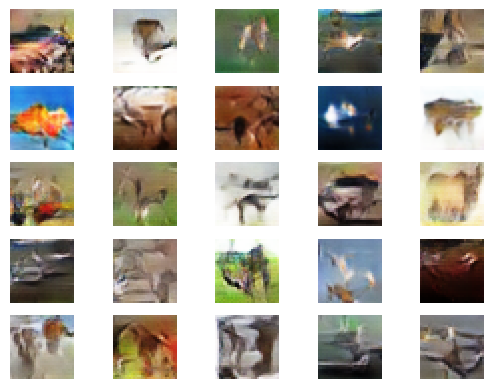

In [12]:
# Now, load the generator model and generate images

# Plot generated images function
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

# load model
#model = load_model('./cifar_GAN.50_epochs.model') #Model trained for n epochs

#model = load_model('./cifar_GAN.2005_epochs.model') #Model trained for n epochs
model = load_model('./cifar_GAN.200100_epochs.model') #Model trained for n epochs200100_epochs
# generate the latent vector 
latent_points = generate_latent_points(200, 100)  #Latent dim and n_samples

# generate images from the latent vector 
X = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# plot the generated images
# Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
show_plot(X, 5)

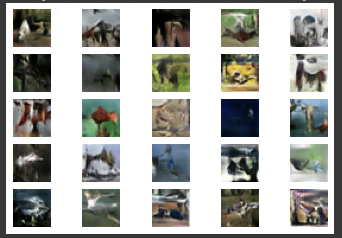
An example for 300 dimensions and 200 epochs. Somehow, Colab did not allow me to download the model, since it wasnt connected to drive. Even though you cant zoom nicely, I think you can observe quite a few patterns. Also in examples below, we can observe some birds.

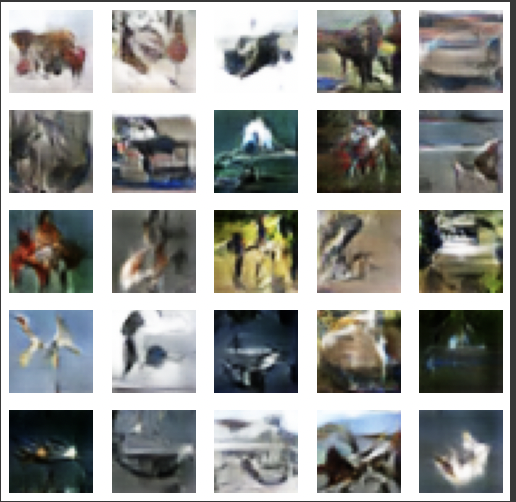


### Open Questions:
- What would be our maximum latent dimension?

We are sampling a random latent point z and apply our model to it. Did these pictures now correctly fool the discriminator?

### Using different hyperparameters:

#### Changing the latent dim and epochs:
- Latent dim of 200 and 5 epochs: crazy blurry photos. Nothing realistic
- Latent dim of 200 and 100 epochs: blurry photos. However, one can observe some kinds of animals and backgrounds e.g water or sky.
- Latent dim of 300 and 200 epochs: The photos got better. We can observe some forms of animals with imagination like birds, frogs and a Yacht.

### How do we optimize GAN performance?

Based on the paper ["Improved techniques for training gans"](https://proceedings.neurips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf) by the OpenAI team, several possibilities exist to improve general GAN performane.

Generally, the authors point out that GANs are a promising class of generative models however problems exists. They are unstable at training and there is no proper evaluation metric (state 2016). 

How can performance be enhanced:

- Feature matching
    - Preventing the generation from overtraining by specifying a new objective
    - The discriminator doesnt know, that the generator generates the same samples every epoch
    - We are now not trying to maximize the discriminator's output but try to generate data that matches the statistics of the real data.
    - So we are not anymore trying to fool by creating a perfect picture 
    
- Minibatch discrimination
    - GANs can collapse and then always emit the same point 
    - Discriminator: Converging to a distribution with the correct entropy is not possible. (Entropy -> randomness or measure of unpredictability)
    - Therefore: the discriminator now looks at several examples in combination. By doing so, the potential of collapsing is minimized.
    - Other examples are now a side informaton for the discriminator

- Historical averaging
    - The generator and discriminator are using the historical average of the parameters, which are updated
    - scales well with long time series
    
- One-sided label smoothing
    - Replacing 0 - 1 as targets with smoothed values .9 or .1.
    - However, only positive labels are smoothed to $\alpha$ and negative labels are 0.

- Virtual batch normalization
    - each example x is normalized based on statistics collected in a reference batch. These are chosen and fix at the start of the training process.
    
How can we assess the generated images?

This was also an interesting take for me. I was wondering how I could acess the loss function or the models history. However, the paper describes that there is no objective function. Therefore, the authors name human annotators and the Inception model as possible quality metrics. The Inception model could be used to get the label distribution. Images with a meaningful object should have a label with a low entropy. This was an especially cool idea in my opinion. We are using a model to generate images and compare the results to another model which has learned to classify real images by using other pre trained models.